In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from operator import attrgetter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prefixspan import PrefixSpan
import networkx as nx

from datetime import timedelta

In [2]:
def ingest_as_df(data_name):
    path = '/Users/thailinhpham/Downloads/Python/hftf/data/' + data_name
    xls = pd.ExcelFile(path)
    return pd.read_excel(xls)

In [3]:
data_bills = ingest_as_df('2. bills.xlsx')
data_users = ingest_as_df('3. users.xlsx')
data_products = ingest_as_df('4. products.xlsx') 
data_occasions = ingest_as_df('5. occasions.xlsx')
data_relationships = ingest_as_df('6. relationships.xlsx')
data_user_relationships = ingest_as_df('7. user_relationships.xlsx')
data_overview = [data_bills, data_users, data_products, data_occasions, data_relationships, data_user_relationships]
data_overview_dict = {
    'bills': data_bills,
    'users': data_users,
    'products': data_products,
    'occasions': data_occasions,
    'relationships': data_relationships,
    'user_relationships': data_user_relationships
}

In [4]:
# check
data_bills

_id               customer_id  \
0     5c2ca5fd819a4edc2e65eb36  5a5ea602652fe8de52ecb5cf   
1     5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   
2     5c2c9162819a4e681965eb4f  5bf60ee0819a4e76518c6393   
3     5c2f2fad819a4e865065eb39  5a1cf33e652fe8c33d030d6f   
4     5c35b574819a4e314f76c332  597f4d5c652fe882468b590b   
...                        ...                       ...   
6596  6535d8144a6a4d4fa005a6ae  6405c7adf2497cd09b02b0f6   
6597  6536340b685b663e520da7e2  65362f2f058e39e1cf0ae5f3   
6598  6536340b685b663e520da7e3  65362f2f058e39e1cf0ae5f3   
6599  6536501b213d349ce10e1512  65364da659ec9f648f021e06   
6600  653652fa3a65abd4a600739d  63974d67b1ac807cd104a280   

                     master_id country_id  summary.grand_total   \
0     6066c157066c9a03055f2b10         MO               150000d   
1     6066c157066c9a03055f2b10         VN              1350000d   
2     6066c157066c9a03055f2b10         VN             500000vnd   
3     6066c157066c9a03055f2b10         US             800000vnd   
4     6066c157066c9a03055f2b10         IL             500000vnd   
...                        ...        ...                   ...   
6596  6066c157066c9a03055f2b10         VN             210000vnd   
6597  6066cd65ca52cc506817d471         VN               178200d   
6598  6066c157066c9a03055f2b10         VN               691200d   
6599  6066c157066c9a03055f2b10         VN            1318000vnd   
6600  6066c157066c9a03055f2b10         SG               539000d   

      summary.discount.money  summary.commission   \
0                        0.0                30000   
1                        NaN               270000   
2                        NaN               100000   
3                        NaN               160000   
4                        NaN               100000   
...                      ...                  ...   
6596                     0.0                26000   
6597                     0.0                30450   
6598                     0.0               161200   
6599                     0.0               345000   
6600                     0.0                89000   

     to_user.location.province_id   to_user.relationship_id  \
0        5016fd6b7f8b9ac842000000                       NaN   
1        5016fd6b7f8b9ac842000000                       NaN   
2        5016fd6b7f8b9ac842000000                       NaN   
3        5016fd6b7f8b9ac842000000                       NaN   
4        5016fd6b7f8b9ac842000000                       NaN   
...                           ...                       ...   
6596     5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
6597     5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
6598     5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
6599     5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
6600     5016fd6c7f8b9ac842000014  62374af9d1578b0a925e404a   

           to_user.occasion_id       to_user.relative_id  \
0                          NaN  62bc900756bcb11219006029   
1                          NaN  62bc701a56bcb11219005312   
2                          NaN  62bc730756bcb11219005467   
3                          NaN  62bc99f556bcb112190063f8   
4                          NaN  62bca8b956bcb11219006a36   
...                        ...                       ...   
6596  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
6597  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
6598  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
6599  62374e382511770c643d9a5a  653650f02961ebea9c0a91e3   
6600  64439e349205569fe5081880  639752409d60e026fd08ab52   

                  to_user.date       create_info.created  
0     2019-01-09T02:00:00.000Z  2019-01-02T11:52:29.714Z  
1     2019-01-05T00:00:00.000Z  2019-01-04T08:22:36.831Z  
2     2019-01-01T03:00:00.000Z  2019-01-02T10:24:34.952Z  
3     2019-01-07T02:00:00.000Z  2019-01-04T10:04:29.107Z  
4     2019-01-10T02:00:00.000Z  2019-01-09T08:48:52.720Z  
...                        ...  

### 2.1. Rename columns

In [5]:
def data_overview():
    data_overview_dict = {
        'bills': data_bills,
        'users': data_users,
        'products': data_products,
        'occasions': data_occasions,
        'relationships': data_relationships,
        'user_relationships': data_user_relationships
    }
    for data_name, data_frame in data_overview_dict.items():
        df_name = 'data_' + data_name
        print('data name is: ', data_name.upper())
        print('dataframe name is: ', df_name)
        print('with info: ', '\n', data_frame.info())
        print('='*60)

In [6]:
data_overview()

data name is:  BILLS
dataframe name is:  data_bills
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6601 entries, 0 to 6600
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _id                           6601 non-null   object 
 1   customer_id                   6601 non-null   object 
 2   master_id                     6451 non-null   object 
 3   country_id                    6293 non-null   object 
 4    summary.grand_total          6601 non-null   object 
 5   summary.discount.money        5803 non-null   float64
 6    summary.commission           6163 non-null   object 
 7   to_user.location.province_id  6573 non-null   object 
 8   to_user.relationship_id       680 non-null    object 
 9   to_user.occasion_id           602 non-null    object 
 10  to_user.relative_id           5860 non-null   object 
 11  to_user.date                  6601 non-null   object 
 12  create_inf

In [7]:
# Remove head, tail space
data_bills.columns = data_bills.columns.str.strip()

# Rename the columns
data_bills.rename(columns={
    'summary.grand_total': 's_grand_total',
    'summary.discount.money': 's_discount_money',
    'summary.commission': 's_commission',
    'to_user.location.province_id': 'to_user_province_id',
    'to_user.relationship_id': 'to_user_relationship_id',
    'to_user.occasion_id': 'to_user_occasion_id',
    'to_user.relative_id': 'to_user_relative_id',
    'to_user.date': 'to_user_date',
    'create_info.created': 'create_info_created',
    'master_id': 'product_id'
}, inplace=True)

data_users.rename(columns={'_id': 'user_id', 'full_name': 'user_full_name'}, inplace=True)

data_products.rename(columns={'_id': 'product_id', 'name': 'product_name'}, inplace=True)

data_occasions.rename(columns={'_id': 'occasion_id', 'name': 'occasion_name'}, inplace=True)

data_relationships.rename(columns={'_id': 'relationship_id', 'name': 'relationship_name'}, inplace=True)

data_user_relationships.rename(columns={'_id': 'user_relationship_id', 'full_name': 'user_relationship_full_name'}, inplace=True)

In [8]:
data_overview()

data name is:  BILLS
dataframe name is:  data_bills
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6601 entries, 0 to 6600
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      6601 non-null   object 
 1   customer_id              6601 non-null   object 
 2   product_id               6451 non-null   object 
 3   country_id               6293 non-null   object 
 4   s_grand_total            6601 non-null   object 
 5   s_discount_money         5803 non-null   float64
 6   s_commission             6163 non-null   object 
 7   to_user_province_id      6573 non-null   object 
 8   to_user_relationship_id  680 non-null    object 
 9   to_user_occasion_id      602 non-null    object 
 10  to_user_relative_id      5860 non-null   object 
 11  to_user_date             6601 non-null   object 
 12  create_info_created      6601 non-null   object 
dtypes: float64(1), object(12)


### 2.2. Prepare data_bills

In [9]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'product_id' has 150 NaN values.
Column 'country_id' has 308 NaN values.
Column 's_discount_money' has 798 NaN values.
Column 's_commission' has 438 NaN values.
Column 'to_user_province_id' has 28 NaN values.
Column 'to_user_relationship_id' has 5921 NaN values.
Column 'to_user_occasion_id' has 5999 NaN values.
Column 'to_user_relative_id' has 741 NaN values.


Total   Percent
to_user_occasion_id       5999  0.908802
to_user_relationship_id   5921  0.896985
s_discount_money           798  0.120891
to_user_relative_id        741  0.112256
s_commission               438  0.066354

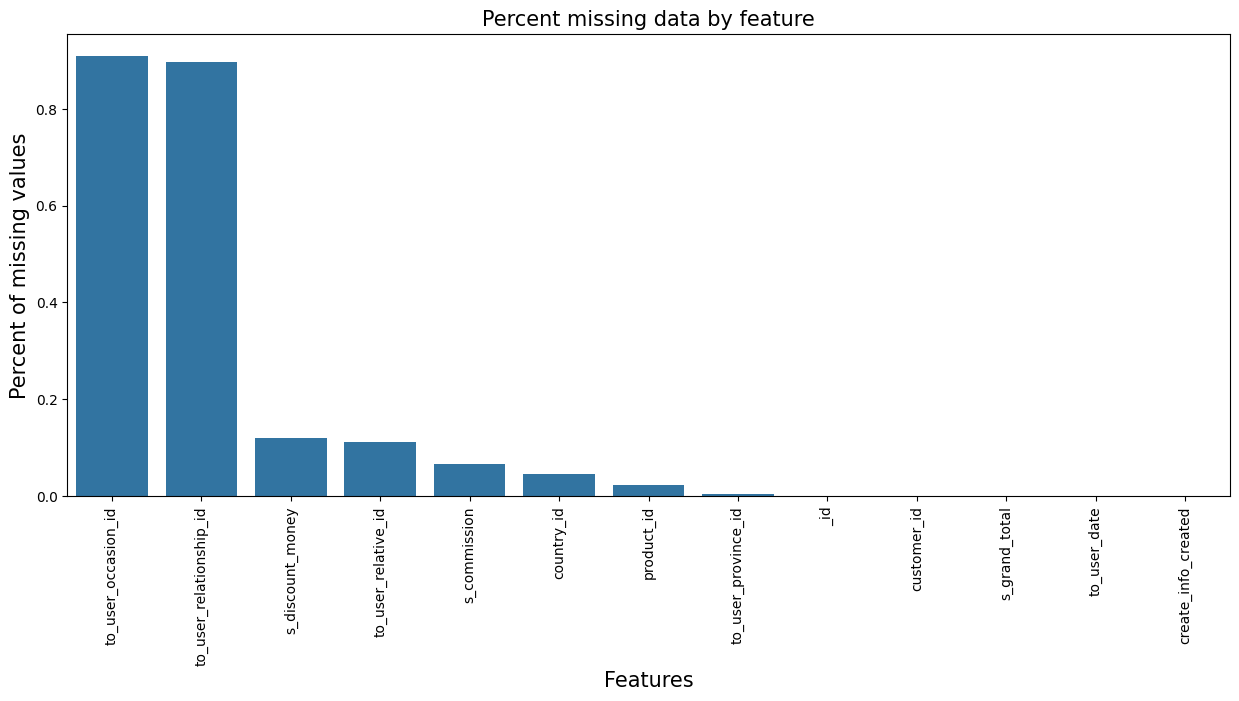

In [10]:
total = data_bills.isnull().sum().sort_values(ascending=False)
percent = (data_bills.isnull().sum()/data_bills.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [11]:
data_bills.head(3)

_id               customer_id  \
0  5c2ca5fd819a4edc2e65eb36  5a5ea602652fe8de52ecb5cf   
1  5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   
2  5c2c9162819a4e681965eb4f  5bf60ee0819a4e76518c6393   

                 product_id country_id s_grand_total  s_discount_money  \
0  6066c157066c9a03055f2b10         MO       150000d               0.0   
1  6066c157066c9a03055f2b10         VN      1350000d               NaN   
2  6066c157066c9a03055f2b10         VN     500000vnd               NaN   

  s_commission       to_user_province_id to_user_relationship_id  \
0        30000  5016fd6b7f8b9ac842000000                     NaN   
1       270000  5016fd6b7f8b9ac842000000                     NaN   
2       100000  5016fd6b7f8b9ac842000000                     NaN   

  to_user_occasion_id       to_user_relative_id              to_user_date  \
0                 NaN  62bc900756bcb11219006029  2019-01-09T02:00:00.000Z   
1                 NaN  62bc701a56bcb11219005312  2019-01-05T00:00:00.000Z   
2                 NaN  62bc730756bcb11219005467  2019-01-01T03:00:00.000Z   

        create_info_created  
0  2019-01-02T11:52:29.714Z  
1  2019-01-04T08:22:36.831Z  
2  2019-01-02T10:24:34.952Z

In [12]:
data_bills['country_id'].unique()

array(['MO', 'VN', 'US', 'IL', 'GB', 'FR', 'DE', 'HK', 'PL', 'ID', 'MY',
       'CA', 'MX', 'NL', 'SG', 'CH', 'AU', 'KR', 'TH', 'KH', 'RU', 'IT',
       'TW', 'SE', nan, 'LK', 'IN', 'PH', 'FI', 'JP', 'KZ', 'TR', 'DK',
       'EE', 'NO', 'EG', 'UA', 'RS', 'HU', 'BE', 'SK', 'CN', 'GU', 'NZ',
       'BR', 'CM', 'IE', 'IS', 'LU', 'BD'], dtype=object)

In [13]:
data_bills_original = data_bills.copy()

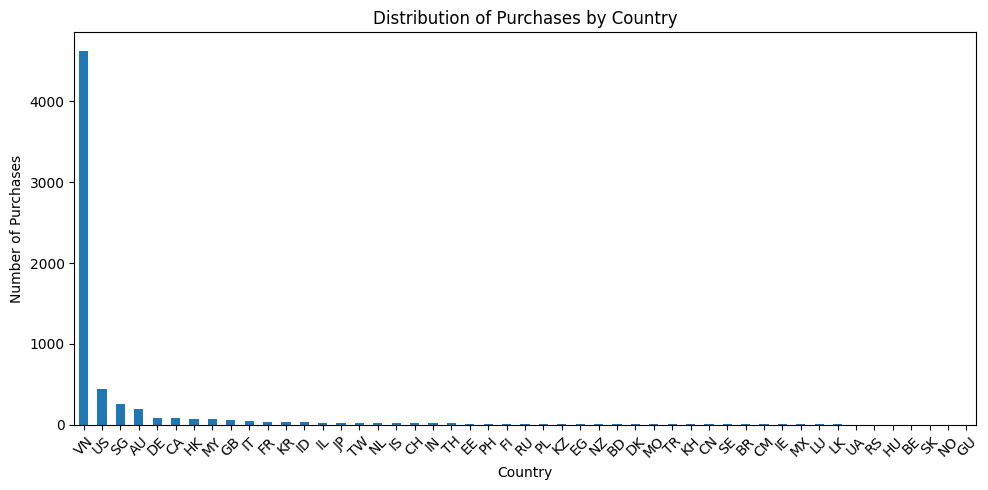

In [14]:
country_counts = data_bills['country_id'].value_counts()

country_counts.plot(kind='bar', figsize=(10, 5))

plt.title('Distribution of Purchases by Country')
plt.xlabel('Country')
plt.ylabel('Number of Purchases')

plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

In [15]:
# Lọc data_bills để chỉ giữ lại record thị trường VN
data_bills = data_bills[data_bills['country_id'] == 'VN'].copy()

In [16]:
data_provinces = pd.read_csv("provinces.csv") # data được cung cấp sau khi btc bổ sung

In [17]:
data_provinces.rename(columns={'_id': 'province_id', 'name': 'province_name'}, inplace=True)
data_provinces['province_id'] = data_provinces['province_id'].str.extract(r'ObjectId\((.*?)\)', expand=False)

In [18]:
data_bills = data_bills.merge(data_provinces, how='left', left_on='to_user_province_id', right_on='province_id')

data_bills.rename(columns={'province_name': 'to_province'}, inplace=True)

data_bills.head(1)

_id               customer_id  \
0  5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   

                 product_id country_id s_grand_total  s_discount_money  \
0  6066c157066c9a03055f2b10         VN      1350000d               NaN   

  s_commission       to_user_province_id to_user_relationship_id  \
0       270000  5016fd6b7f8b9ac842000000                     NaN   

  to_user_occasion_id       to_user_relative_id              to_user_date  \
0                 NaN  62bc701a56bcb11219005312  2019-01-05T00:00:00.000Z   

        create_info_created               province_id     to_province  
0  2019-01-04T08:22:36.831Z  5016fd6b7f8b9ac842000000  TP Hồ Chí Minh

In [19]:
data_bills.drop('province_id', axis=1, inplace=True)

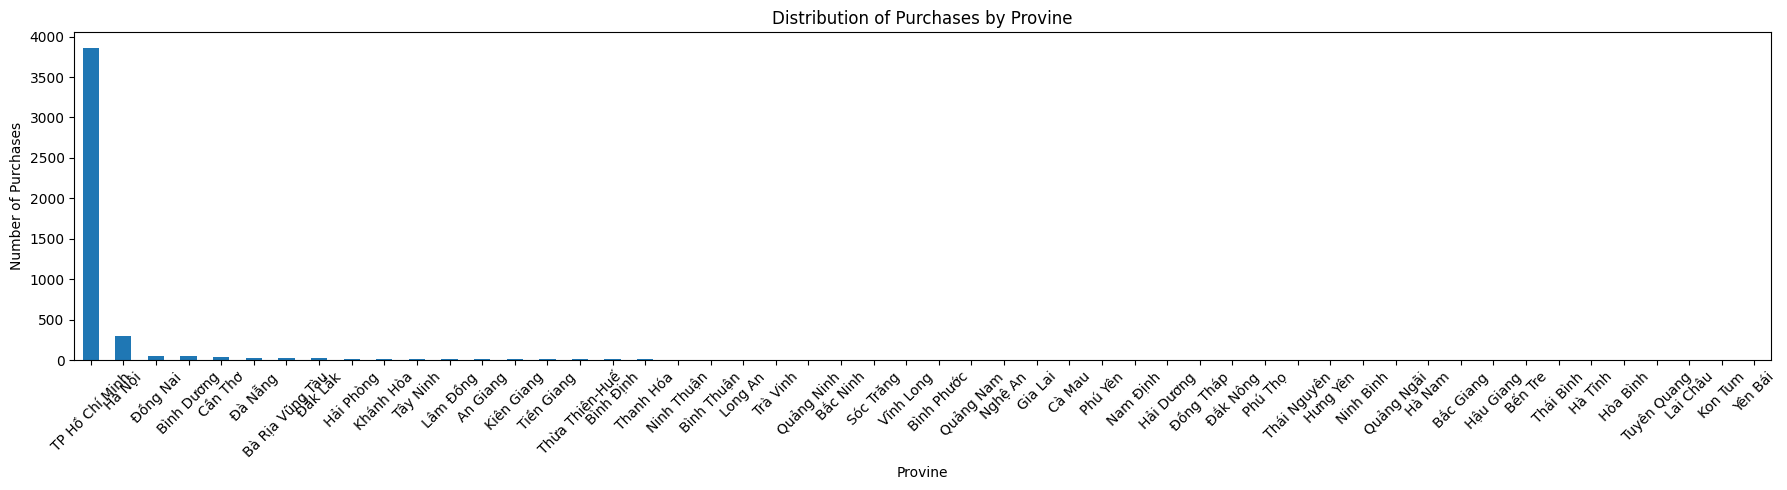

In [20]:
Provine_counts = data_bills['to_province'].value_counts()

Provine_counts.plot(kind='bar', figsize=(18, 5))

plt.title('Distribution of Purchases by Provine')
plt.xlabel('Provine')
plt.ylabel('Number of Purchases')

plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

* In this case, I will not filter the destination is HCM city only, because the sender can be everywhere, but It could not deny a hypothesis that the sender are almost located in HCM city
* I focus on VN because the user located in Vietnam has been occupied the most, and it could be also good for customer behaviour analysis

In [21]:
data_bills['s_grand_total'] = data_bills['s_grand_total'].str.extract('(\d+)').astype(float)
print(data_bills['s_grand_total'])

0       1350000.0
1        500000.0
2        350000.0
3       2000000.0
4       1800000.0
          ...    
4619     105000.0
4620     210000.0
4621     178200.0
4622     691200.0
4623    1318000.0
Name: s_grand_total, Length: 4624, dtype: float64


In [22]:
data_bills.head(3)

_id               customer_id  \
0  5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   
1  5c2c9162819a4e681965eb4f  5bf60ee0819a4e76518c6393   
2  5c302fd3819a4e230ef87988  5c2ce0de819a4eba2c65eb69   

                 product_id country_id  s_grand_total  s_discount_money  \
0  6066c157066c9a03055f2b10         VN      1350000.0               NaN   
1  6066c157066c9a03055f2b10         VN       500000.0               NaN   
2  6066c157066c9a03055f2b10         VN       350000.0               NaN   

  s_commission       to_user_province_id to_user_relationship_id  \
0       270000  5016fd6b7f8b9ac842000000                     NaN   
1       100000  5016fd6b7f8b9ac842000000                     NaN   
2        70000  5016fd6b7f8b9ac842000000                     NaN   

  to_user_occasion_id       to_user_relative_id              to_user_date  \
0                 NaN  62bc701a56bcb11219005312  2019-01-05T00:00:00.000Z   
1                 NaN  62bc730756bcb11219005467  2019-01-01T03:00:00.000Z   
2                 NaN  62bc706356bcb11219005334  2019-01-07T02:00:00.000Z   

        create_info_created     to_province  
0  2019-01-04T08:22:36.831Z  TP Hồ Chí Minh  
1  2019-01-02T10:24:34.952Z  TP Hồ Chí Minh  
2  2019-01-05T04:17:23.656Z  TP Hồ Chí Minh

In [23]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'product_id' has 70 NaN values.
Column 's_grand_total' has 11 NaN values.
Column 's_discount_money' has 379 NaN values.
Column 's_commission' has 145 NaN values.
Column 'to_user_province_id' has 14 NaN values.
Column 'to_user_relationship_id' has 4142 NaN values.
Column 'to_user_occasion_id' has 4194 NaN values.
Column 'to_user_relative_id' has 453 NaN values.
Column 'to_province' has 14 NaN values.


### Note: Ưu tiên xử lý các features quan trọng trước như s_commision, s_discount_money, s_grand_total
### Rồi sau đó lọc outlier rồi mới xử lý tiếp những NaN value

In [24]:
data_bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      4624 non-null   object 
 1   customer_id              4624 non-null   object 
 2   product_id               4554 non-null   object 
 3   country_id               4624 non-null   object 
 4   s_grand_total            4613 non-null   float64
 5   s_discount_money         4245 non-null   float64
 6   s_commission             4479 non-null   object 
 7   to_user_province_id      4610 non-null   object 
 8   to_user_relationship_id  482 non-null    object 
 9   to_user_occasion_id      430 non-null    object 
 10  to_user_relative_id      4171 non-null   object 
 11  to_user_date             4624 non-null   object 
 12  create_info_created      4624 non-null   object 
 13  to_province              4610 non-null   object 
dtypes: float64(2), object(12

In [25]:
def commission_conversion(row):
    if row['s_commission'] == ' -   ':
        # Calculate 20% of s_grand_total if s_commission is ' -   '
        return float(row['s_grand_total']) * 20 / 100
    else:
        return float(row['s_commission'])  # Otherwise, just convert to float

mask = data_bills['s_commission'] == ' -   '
data_bills.loc[mask, 's_commission'] = data_bills[mask].apply(commission_conversion, axis=1)

# Now let's ensure that the entire s_commission column is float
data_bills['s_commission'] = data_bills['s_commission'].astype(float)

In [26]:
mask = data_bills['s_grand_total'].isna()
data_bills.loc[mask, 's_grand_total'] = data_bills.loc[mask, 's_commission'] * 100 / 20

print(data_bills['s_grand_total'].unique())

[1350000.  500000.  350000. ...  957744.  340200. 1318000.]


In [27]:
data_bills['to_user_date'] = pd.to_datetime(data_bills['to_user_date'], errors='coerce', utc=True)
data_bills['create_info_created'] = pd.to_datetime(data_bills['create_info_created'], errors='coerce', utc=True)

In [28]:
data_bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   _id                      4624 non-null   object             
 1   customer_id              4624 non-null   object             
 2   product_id               4554 non-null   object             
 3   country_id               4624 non-null   object             
 4   s_grand_total            4615 non-null   float64            
 5   s_discount_money         4245 non-null   float64            
 6   s_commission             4473 non-null   float64            
 7   to_user_province_id      4610 non-null   object             
 8   to_user_relationship_id  482 non-null    object             
 9   to_user_occasion_id      430 non-null    object             
 10  to_user_relative_id      4171 non-null   object             
 11  to_user_date             4624 

In [29]:
data_bills_no_outliers = data_bills.copy()  

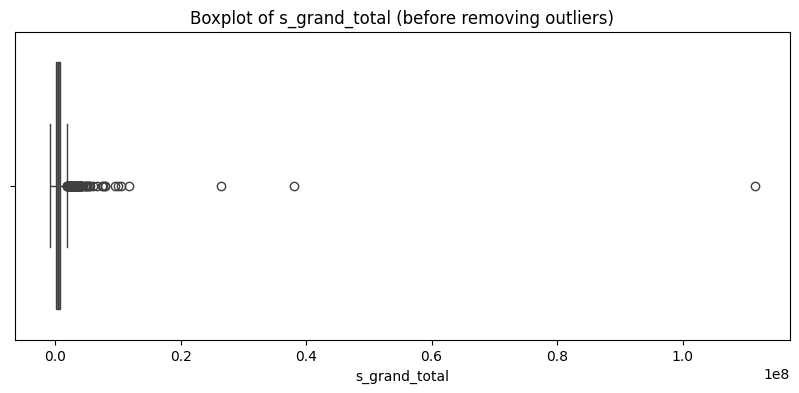

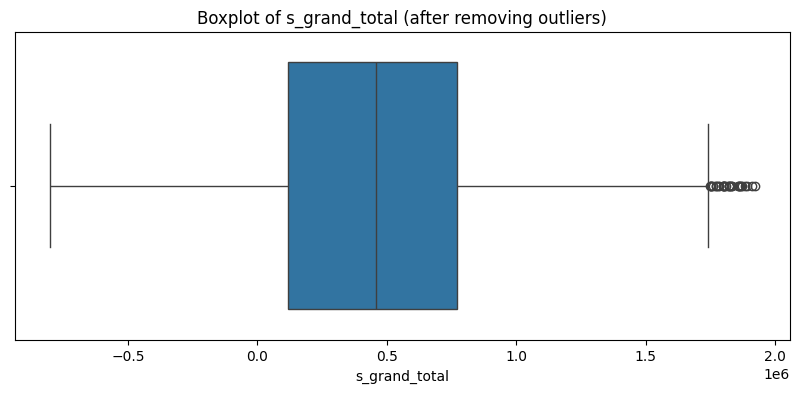

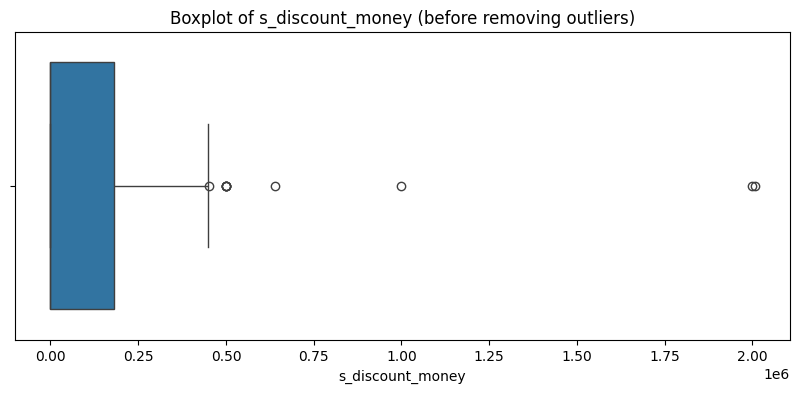

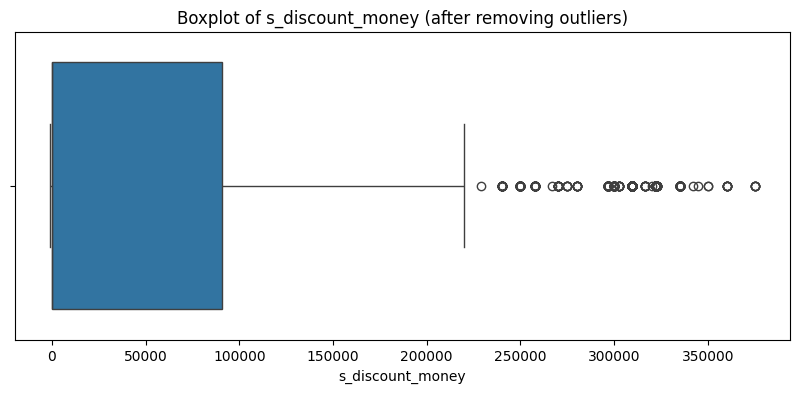

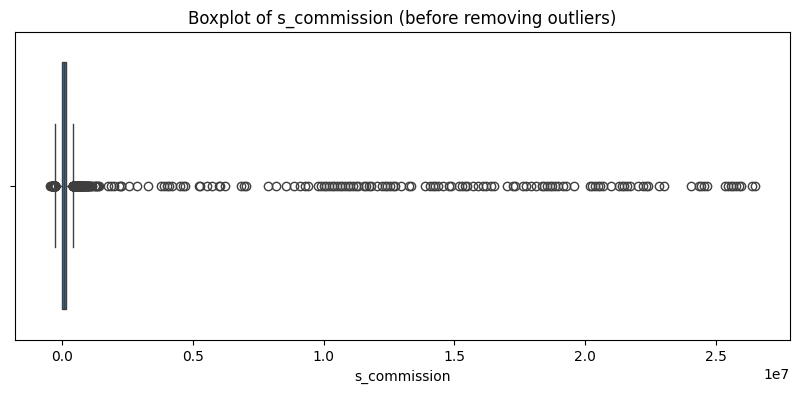

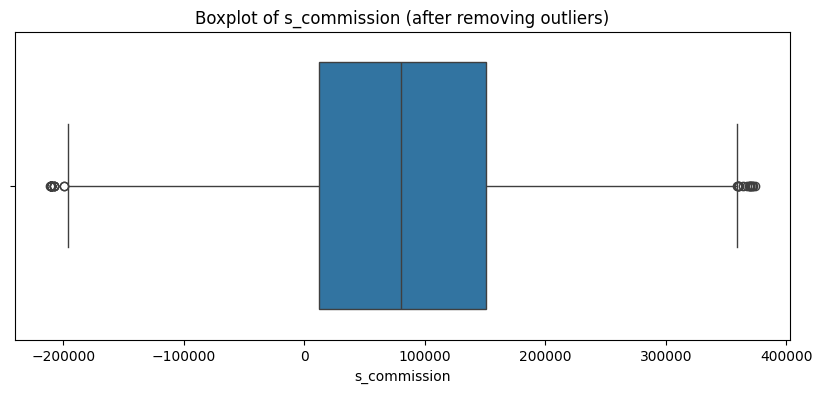

In [30]:
# lower and upper bounds for outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data_bills_no_outliers = remove_outliers_iqr(data_bills_no_outliers, 's_grand_total')

data_bills_no_outliers = remove_outliers_iqr(data_bills_no_outliers, 's_discount_money')

data_bills_no_outliers = remove_outliers_iqr(data_bills_no_outliers, 's_commission')

for column in ['s_grand_total', 's_discount_money', 's_commission']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data_bills[column])
    plt.title(f'Boxplot of {column} (before removing outliers)')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data_bills_no_outliers[column])
    plt.title(f'Boxplot of {column} (after removing outliers)')
    plt.show()

In [31]:
# I accept the result, now i will make it to main dataframe
data_bills = data_bills_no_outliers.copy()

In [32]:
def check_negative(col):
    negative_values = data_bills.loc[data_bills[col] < 0, col]
    
    if not negative_values.empty:
        print("Having negative values in ", col)
        if len(negative_values) < 600:
            print(negative_values.unique()) 
    else:
        print("No negative values in ", col)

check_list = ['s_grand_total', 's_discount_money', 's_commission']

for col in check_list:
    check_negative(col)

Having negative values in  s_grand_total
[-800000.]
Having negative values in  s_discount_money
[-1000.]
Having negative values in  s_commission
[-5.4400e+04 -2.8000e+03 -1.0200e+04 -2.8000e+04 -1.5920e+05 -1.1680e+05
 -1.1920e+05 -1.4900e+05 -1.9900e+05 -1.9620e+05 -1.8900e+05 -8.6000e+04
 -2.1000e+05 -1.4700e+05 -1.6000e+05 -1.8760e+05 -2.0760e+05 -1.4000e+05
 -1.6500e+05 -1.9000e+05 -1.3760e+05 -9.0000e+04 -1.4580e+05 -9.7640e+03
 -1.0420e+05 -1.8620e+05 -1.4340e+05 -1.4660e+05 -1.3200e+03 -1.8680e+04
 -8.1400e+03 -2.3200e+04 -2.0240e+04 -3.0200e+04 -2.0000e+02 -2.3500e+04
 -2.5480e+04 -8.4000e+03 -7.0000e+03 -1.0000e+04 -1.4000e+04 -2.2000e+03
 -2.0000e+04 -1.7400e+04 -2.9600e+02 -3.8000e+04 -4.9950e+04 -2.1083e+05
 -2.2575e+04 -2.0650e+04 -1.3750e+04 -2.3100e+04 -2.0200e+04 -2.5600e+04
 -2.2050e+04 -1.3325e+04 -1.6000e+03 -2.9850e+04 -3.2000e+04 -2.1300e+04]


In [33]:
# remove 1 rows 
data_bills = data_bills[data_bills['s_discount_money'] >= 0]

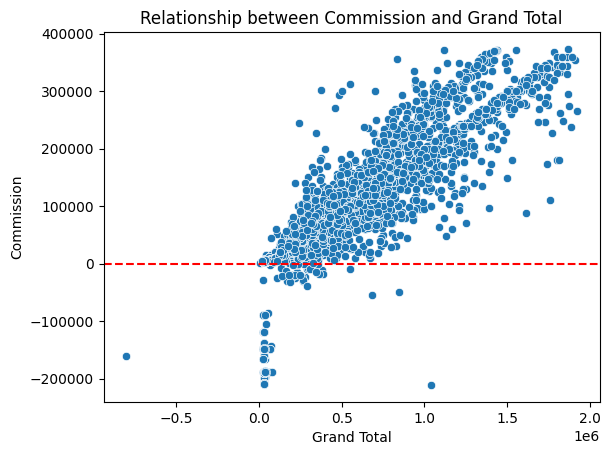

In [34]:
test_s_commission = data_bills[['s_commission', 's_grand_total']].copy()

sns.scatterplot(data=test_s_commission, x='s_grand_total', y='s_commission')
plt.title('Relationship between Commission and Grand Total')
plt.xlabel('Grand Total')
plt.ylabel('Commission')

plt.axhline(0, color='red', linestyle='--')

plt.show()

In [35]:
data_bills[data_bills['s_commission'] < 0].count()

_id                        177
customer_id                177
product_id                 177
country_id                 177
s_grand_total              177
s_discount_money           177
s_commission               177
to_user_province_id        177
to_user_relationship_id      5
to_user_occasion_id          6
to_user_relative_id        171
to_user_date               177
create_info_created        177
to_province                177
dtype: int64

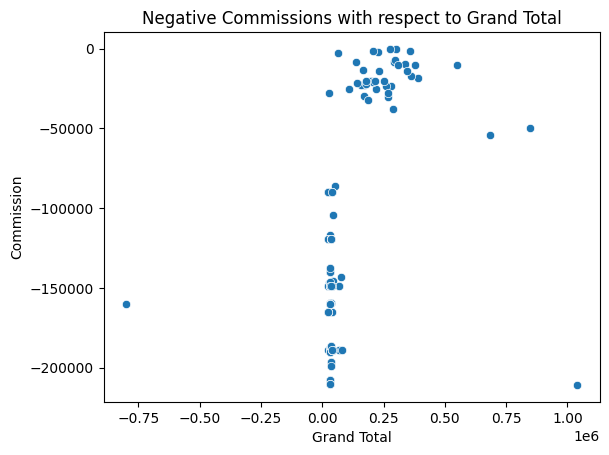

In [36]:
test_s_commission_negatives = data_bills[data_bills['s_commission'] < 0][['s_commission', 's_grand_total']].copy()

sns.scatterplot(data=test_s_commission_negatives, x="s_grand_total", y="s_commission")
plt.title('Negative Commissions with respect to Grand Total')
plt.xlabel('Grand Total')
plt.ylabel('Commission')
plt.show()

In [37]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'product_id' has 6 NaN values.
Column 'to_user_province_id' has 13 NaN values.
Column 'to_user_relationship_id' has 3253 NaN values.
Column 'to_user_occasion_id' has 3298 NaN values.
Column 'to_user_relative_id' has 349 NaN values.
Column 'to_province' has 13 NaN values.


In [38]:
data_bills['product_id'].fillna('6066c157066c9a03055f2b10', inplace=True) # Hoa (dễ thấy ở các visualization sau)
data_bills['to_user_province_id'].fillna('5016fd6b7f8b9ac842000000', inplace=True) # hypothesis TPHCM
# data_bills['to_user_relationship_id'].fillna('62b43ee94a645a789f05dac2', inplace=True) # 'Một ai đó' 
# data_bills['to_user_relative_id'].fillna('62bc674256bcb11219004f32', inplace=True) # match ngược rela trả về 'Một ai đó' 
data_bills['to_province'].fillna('TP Hồ Chí Minh', inplace=True) # vì dữ liệu cho thấy đa số là tphcm
# data_bills['to_user_occasion_id'].fillna('62b44615e7faf931dd003dd6', inplace=True) # 'Dịp khác' 
fill_values = {
    'product_id': '6066c157066c9a03055f2b10',
    'to_user_province_id': '5016fd6b7f8b9ac842000000',
    # 'to_user_relationship_id': '62b43ee94a645a789f05dac2', 
    # 'to_user_relative_id': '62bc674256bcb11219004f32',
    'to_province': 'TP Hồ Chí Minh',
    # 'to_user_occasion_id': '62b44615e7faf931dd003dd6' 
}

data_bills.fillna(value=fill_values, inplace=True)

In [39]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'to_user_relationship_id' has 3253 NaN values.
Column 'to_user_occasion_id' has 3298 NaN values.
Column 'to_user_relative_id' has 349 NaN values.


In [40]:
# in case rerun a part of code
if 's_profit' not in data_bills:
    data_bills['s_profit'] = pd.Series(0, index=data_bills.index)
    
data_bills['s_profit'] = data_bills['s_profit'].astype(float)

# data_bills['s_discount_money'] = data_bills['s_discount_money'].fillna(0)

data_bills['s_grand_total'] = data_bills['s_grand_total'].astype(float)
data_bills['s_commission'] = data_bills['s_commission'].astype(float)

In [41]:
data_bills.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3705 entries, 24 to 4623
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   _id                      3705 non-null   object             
 1   customer_id              3705 non-null   object             
 2   product_id               3705 non-null   object             
 3   country_id               3705 non-null   object             
 4   s_grand_total            3705 non-null   float64            
 5   s_discount_money         3705 non-null   float64            
 6   s_commission             3705 non-null   float64            
 7   to_user_province_id      3705 non-null   object             
 8   to_user_relationship_id  452 non-null    object             
 9   to_user_occasion_id      407 non-null    object             
 10  to_user_relative_id      3356 non-null   object             
 11  to_user_date             3705 non-

In [42]:
data_bills.loc[data_bills['s_commission'] > 0, 's_profit'] = (
    data_bills['s_commission'] - data_bills['s_discount_money']
).astype(float)

data_bills.loc[data_bills['s_commission'] < 0, 's_profit'] = (
    0.2 * data_bills['s_grand_total'] - data_bills['s_discount_money'] - abs(data_bills['s_commission'])
).astype(float)

In [43]:
data_bills.head(3)

_id               customer_id  \
24   5c4b83c7819a4e90043ec806  5bdafe20819a4eb22342cfaf   
179  5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   
180  5e3cb59cf8063622188b4569  5e3cb59bf8063622188b4567   

                   product_id country_id  s_grand_total  s_discount_money  \
24   6066c157066c9a03055f2b10         VN       590000.0               0.0   
179  6066c157066c9a03055f2b10         VN       345000.0               0.0   
180  6066c157066c9a03055f2b10         VN       697500.0               0.0   

     s_commission       to_user_province_id to_user_relationship_id  \
24       118000.0  5016fd6b7f8b9ac842000000                     NaN   
179       63000.0  5016fd6b7f8b9ac842000000                     NaN   
180      136500.0  5016fd6b7f8b9ac842000000                     NaN   

    to_user_occasion_id       to_user_relative_id              to_user_date  \
24                  NaN  62bc755256bcb11219005567 2019-01-26 04:00:00+00:00   
179                 NaN  62bc673e56bcb11219004f30 2020-02-07 04:00:00+00:00   
180                 NaN  62bc673a56bcb11219004f2e 2020-02-07 05:00:00+00:00   

                 create_info_created     to_province  s_profit  
24  2019-01-25 21:46:46.233000+00:00  TP Hồ Chí Minh  118000.0  
179 2020-02-06 11:01:19.401000+00:00  TP Hồ Chí Minh   63000.0  
180 2020-02-07 00:55:55.123000+00:00  TP Hồ Chí Minh  136500.0

In [213]:
date_range(start='1/1/2018', end='1/08/2018')


_id               customer_id  \
4614  65334fc9013dbb75400d81af  65334e6a1f53361b710da7c7   
4615  65339c554318e972f10547cb  6532d33906c22081e60fb6d3   
4616  6534c94d26d2861fd7055847  6534c923b389fcc1f10b41e8   
4617  65350bf9f16eb7e36602b785  65350ae183b945e45308ccd2   
4619  6535d8144a6a4d4fa005a6ad  6405c7adf2497cd09b02b0f6   
4620  6535d8144a6a4d4fa005a6ae  6405c7adf2497cd09b02b0f6   
4618  6535d8144a6a4d4fa005a6ac  6405c7adf2497cd09b02b0f6   
4622  6536340b685b663e520da7e3  65362f2f058e39e1cf0ae5f3   
4621  6536340b685b663e520da7e2  65362f2f058e39e1cf0ae5f3   
4623  6536501b213d349ce10e1512  65364da659ec9f648f021e06   

                    product_id country_id  s_grand_total  s_discount_money  \
4614  60c039663273bc0f1c215081         VN       340200.0               0.0   
4615  6066ce86bf54fc4669392ede         VN       324000.0               0.0   
4616  61e7fc43b347830b69615e42         VN       970000.0               0.0   
4617  62b970c025c493ded10e1ea5         VN       800000.0               0.0   
4619  6066ce023a550774f46d43e3         VN       105000.0               0.0   
4620  6066c157066c9a03055f2b10         VN       210000.0               0.0   
4618  6066ce023a550774f46d43e3         VN       315000.0               0.0   
4622  6066c157066c9a03055f2b10         VN       691200.0               0.0   
4621  6066cd65ca52cc506817d471         VN       178200.0               0.0   
4623  6066c157066c9a03055f2b10         VN      1318000.0               0.0   

      s_commission       to_user_province_id   to_user_relationship_id  \
4614       83200.0  5016fd6c7f8b9ac84200003e  62374d46b2ab6f5f8d470e26   
4615       74750.0  5016fd6b7f8b9ac842000000                       NaN   
4616      180000.0  5016fd6b7f8b9ac842000006                       NaN   
4617       70000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4619       61000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4620       26000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4618       70500.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4622      161200.0  5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
4621       30450.0  5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
4623      345000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   

           to_user_occasion_id       to_user_relative_id  \
4614  62374e382511770c643d9a5a  65334fc2a6ff0c47190ef036   
4615                       NaN  65339c584ca630471a08557a   
4616                       NaN  62b59927eb80e3a3fa0dd5ae   
4617  64439e349205569fe5081880  65350b2fff1d210ac90f915e   
4619  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
4620  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
4618  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
4622  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
4621  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
4623  62374e382511770c643d9a5a  653650f02961ebea9c0a91e3   

                  to_user_date              create_info_created  \
4614 2023-10-21 08:00:00+00:00 2023-10-21 04:15:32.888000+00:00   
4615 2023-10-22 02:00:00+00:00 2023-10-21 10:21:15.509000+00:00   
4616 2023-10-25 07:00:00+00:00 2023-10-22 07:18:34.258000+00:00   
4617 2023-10-23 01:00:00+00:00 2023-10-22 11:51:54.813000+00:00   
4619 2023-10-23 11:00:00+00:00 2023-10-23 02:19:00.226000+00:00   
4620 2023-10-23 09:00:00+00:00 2023-10-23 02:19:00.226000+00:00   
4618 2023-10-23 11:00:00+00:00 2023-10-23 02:20:19.189000+00:00   
4622 2023-10-24 01:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
4621 2023-10-24 11:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
4623 2023-10-23 12:57:41+00:00 2023-10-23 10:59:44.912000+00:00   

         to_province  s_profit  s_profit_in_USD  
4614          Hà Nội   83200.0         3.448991  
4615  TP Hồ Chí Minh   74750.0         3.098702  
4616        Bắc Ninh  180000.0         7.461758  
4617  TP Hồ Chí Minh   70000.0         2.901795  
4619  TP Hồ Chí Minh   61000.0         2.52

In [44]:
exchange_rate = 24123.00  # từ đề bài

data_bills['s_profit_in_USD'] = data_bills['s_profit'] / exchange_rate

data_bills['s_profit_in_USD'] = data_bills['s_profit_in_USD'].astype(float)

data_bills.head(1)

_id               customer_id  \
24  5c4b83c7819a4e90043ec806  5bdafe20819a4eb22342cfaf   

                  product_id country_id  s_grand_total  s_discount_money  \
24  6066c157066c9a03055f2b10         VN       590000.0               0.0   

    s_commission       to_user_province_id to_user_relationship_id  \
24      118000.0  5016fd6b7f8b9ac842000000                     NaN   

   to_user_occasion_id       to_user_relative_id              to_user_date  \
24                 NaN  62bc755256bcb11219005567 2019-01-26 04:00:00+00:00   

                create_info_created     to_province  s_profit  s_profit_in_USD  
24 2019-01-25 21:46:46.233000+00:00  TP Hồ Chí Minh  118000.0         4.891597

In [45]:
data_bills_detail = data_bills.copy()

data_bills_detail['to_user_year'] = data_bills_detail['to_user_date'].dt.year
data_bills_detail['to_user_month'] = data_bills_detail['to_user_date'].dt.month
data_bills_detail['to_user_day'] = data_bills_detail['to_user_date'].dt.day
data_bills_detail['to_user_hour'] = data_bills_detail['to_user_date'].dt.hour

data_bills_detail['to_user_minute'] = data_bills_detail['to_user_date'].dt.minute
data_bills_detail['to_user_second'] = data_bills_detail['to_user_date'].dt.second

data_bills_detail['created_year'] = data_bills_detail['create_info_created'].dt.year
data_bills_detail['created_month'] = data_bills_detail['create_info_created'].dt.month
data_bills_detail['created_day'] = data_bills_detail['create_info_created'].dt.day
data_bills_detail['created_hour'] = data_bills_detail['create_info_created'].dt.hour

data_bills_detail['created_minute'] = data_bills_detail['create_info_created'].dt.minute
data_bills_detail['created_second'] = data_bills_detail['create_info_created'].dt.second

In [46]:
data_bills_detail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3705 entries, 24 to 4623
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   _id                      3705 non-null   object             
 1   customer_id              3705 non-null   object             
 2   product_id               3705 non-null   object             
 3   country_id               3705 non-null   object             
 4   s_grand_total            3705 non-null   float64            
 5   s_discount_money         3705 non-null   float64            
 6   s_commission             3705 non-null   float64            
 7   to_user_province_id      3705 non-null   object             
 8   to_user_relationship_id  452 non-null    object             
 9   to_user_occasion_id      407 non-null    object             
 10  to_user_relative_id      3356 non-null   object             
 11  to_user_date             3705 non-

#### Export to CSV for further analytics using other tools

In [47]:
def to_csv(data_dict):
    for data_name, data_frame in data_dict.items():
        file_name = data_name + '.csv'
        data_frame.to_csv(file_name)
        print('Export to CSV. Done! File ', file_name, 'is ready to use')


to_csv(data_overview_dict)

Export to CSV. Done! File  bills.csv is ready to use
Export to CSV. Done! File  users.csv is ready to use
Export to CSV. Done! File  products.csv is ready to use
Export to CSV. Done! File  occasions.csv is ready to use
Export to CSV. Done! File  relationships.csv is ready to use
Export to CSV. Done! File  user_relationships.csv is ready to use


In [214]:
data_bills.to_csv("biils.csv")
data_users.to_csv("users.csv")
data_products.to_csv("products.csv")
data_occasions.to_csv("occasions.csv")
data_relationships.to_csv("relationships.csv")
data_user_relationships.to_csv("user_relationships.csv")

Statistics for S_GRAND_TOTAL:
Mean: 517145.69986504724
Median: 458650.0
Min: -800000.0
Max: 1920000.0
Standard Deviation: 416629.5327507031


Statistics for S_DISCOUNT_MONEY:
Mean: 72108.73232118758
Median: 0.0
Min: 0.0
Max: 375000.0
Standard Deviation: 118858.9464536023


Statistics for S_COMMISSION:
Mean: 91638.05614035088
Median: 80000.0
Min: -210830.0
Max: 373640.0
Standard Deviation: 101423.2291548977


Statistics for S_PROFIT:
Mean: 20371.050512820515
Median: 72000.0
Min: -520000.0
Max: 373640.0
Standard Deviation: 193499.74027911178




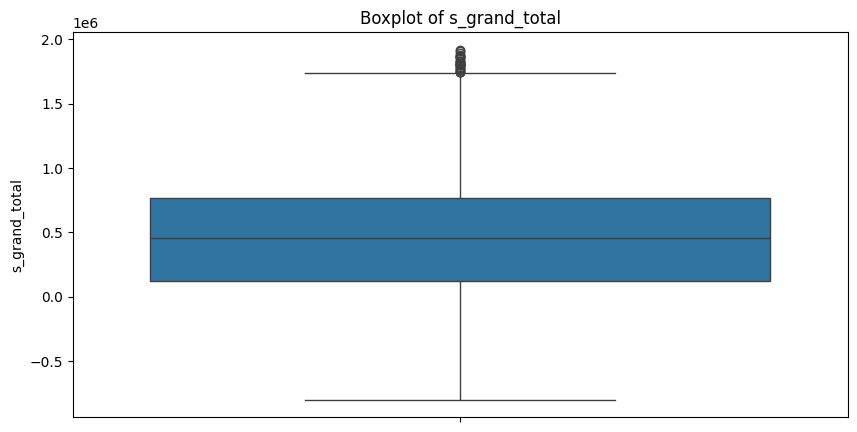

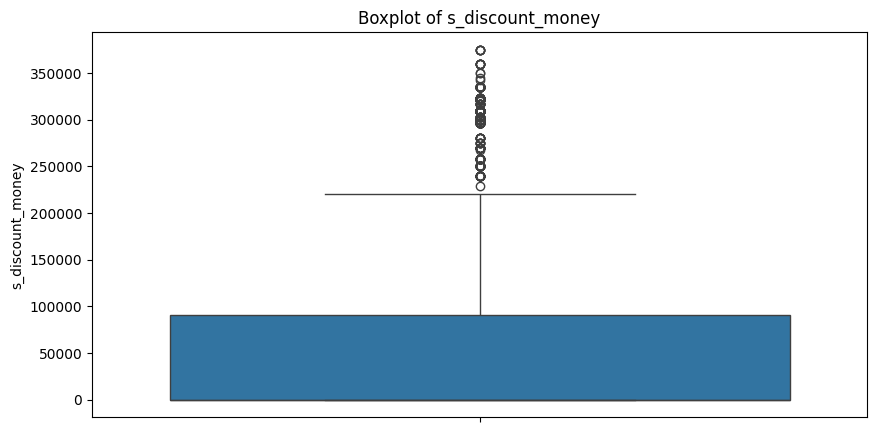

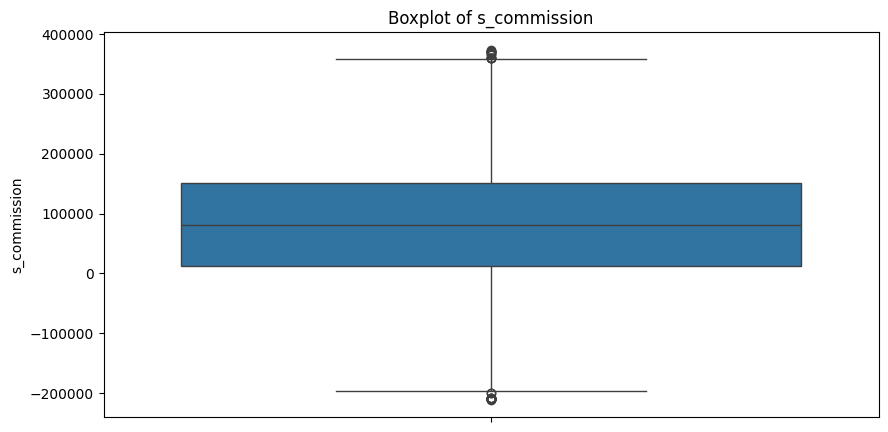

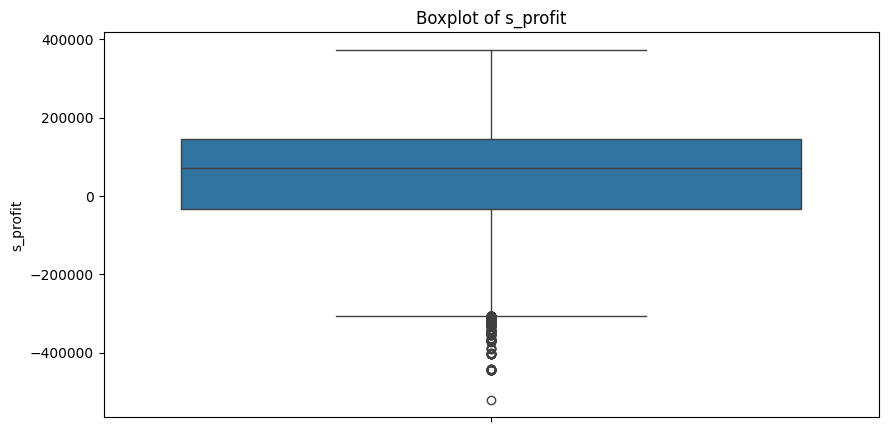

In [48]:
def print_stats(dataframe, column):
    print(f"Statistics for {column.upper()}:")
    print("Mean:", dataframe[column].mean())
    print("Median:", dataframe[column].median())
    print("Min:", dataframe[column].min())
    print("Max:", dataframe[column].max())
    print("Standard Deviation:", dataframe[column].std())
    print('\n')

def plot_box(dataframe, column):
    plt.figure(figsize=(10, 5))
    sns.boxplot(dataframe[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

metrics = ['s_grand_total', 's_discount_money', 's_commission', 's_profit']

for metric in metrics:
    print_stats(data_bills, metric)

for metric in metrics:
    plot_box(data_bills, metric)


**`S_GRAND_TOTAL`:**
The statistics for `S_GRAND_TOTAL` remain relatively similar. The mean and median values of approximately 517,145 and 458,650, respectively, demonstrate a wide spread of transaction amounts, indicating a roughly symmetrical distribution with a slight possibility of right skew. The wide range between the minimum and maximum transaction values (from -800,000 to 1,920,000) points to a diverse array of transaction amounts, reflecting notable variability in transaction values as indicated by the standard deviation of 416,629.

**`S_DISCOUNT_MONEY`:**
The mean of approximately 72,109 and median of 0 still imply a significant right skew, indicating that most transactions do not include a discount, with some transactions featuring substantial discounts, as shown by a maximum discount of 375,000. The large standard deviation of 118,859 reinforces the presence of outliers with high discounts.

**`S_COMMISSION`:**
The mean commission of around 91,638 overshooting the median of 80,000 still suggests a moderate right skew. The occurrence of negative values as low as -210,830 highlights the presence of refunds or other adjustments. The standard deviation of 101,423 indicates a notable spread in commission values, reflecting various deal structures or anomalies.

**`S_PROFIT`:**
The mean profit remains approximately 20,371, which is substantially lower than the median of 72,000, potentially indicating a left skew or an unusual distribution of profit values. The range from -520,000 to 373,640, combined with a large standard deviation of 193,500, intimates considerable variability in profitability.

**Insight:**
The statistics highlight the need for a detailed examination of the transactional data, particularly for extreme values driving wide ranges and variability. It is crucial to investigate negative commission and profit values and scrutinize the high standard deviation values across these columns to gain a comprehensive understanding of transaction behaviors and to ensure accurate financial analysis and strategic planning.

                  s_grand_total  s_discount_money  s_commission  s_profit
s_grand_total          1.000000         -0.588754      0.878068  0.820289
s_discount_money      -0.588754          1.000000     -0.548451 -0.902023
s_commission           0.878068         -0.548451      1.000000  0.854184
s_profit               0.820289         -0.902023      0.854184  1.000000


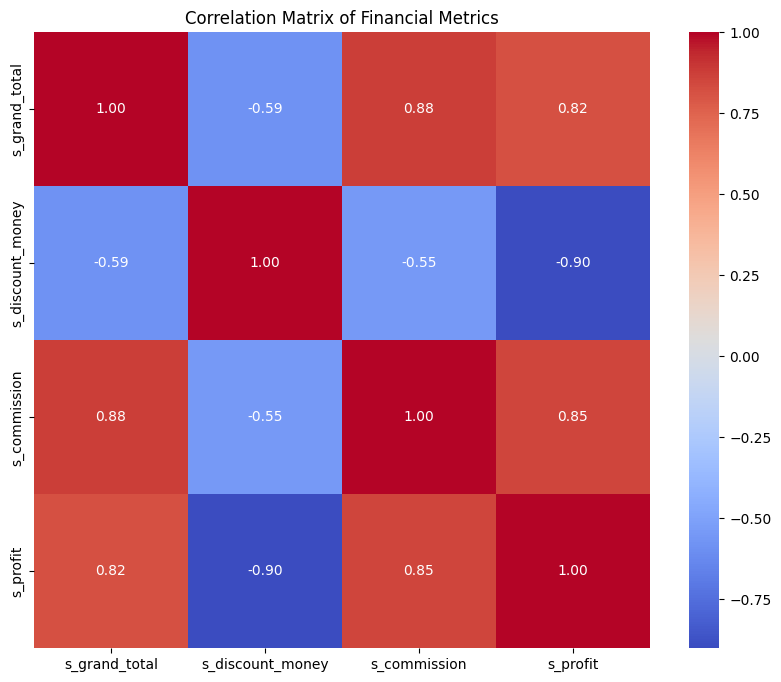

In [49]:
cols = ['s_grand_total', 's_discount_money', 's_commission', 's_profit']

correlation_matrix = data_bills[cols].corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Financial Metrics')
plt.show()

1. **`s_grand_total` and `s_profit`**:
   The correlation coefficient of 0.820289 continues to show a strong positive relationship. As grand total sales increase, profit tends to increase correspondingly, indicating a robust connection between sales and profitability.

2. **`s_grand_total` and `s_commission`**:
   The correlation of 0.878068 also indicates a strong positive link between total sales and commissions. Higher sales figures continue to be associated with higher commissions, reinforcing the existing understanding of their relationship.

3. **`s_grand_total` and `s_discount_money`**:
   The updated negative correlation of -0.588754 maintains a moderate inverse relationship. Transactions with higher total sales are still associated with fewer discounts, suggesting a continued strategy where larger sales are less reliant on discounts to attract buyers.

4. **`s_commission` and `s_profit`**:
   The correlation of 0.854184 still indicates a strong positive correlation. This relationship suggests that higher commissions continue to correlate with higher profits, reinforcing the idea that effective sales incentivization can drive profitability.

5. **`s_discount_money` and `s_profit`**:
   The correlation remains substantially negative at -0.902023, pointing to a strong inverse relationship. Higher discounts continue to be associated with a significant reduction in profits, reflecting the potential impact of decreased revenue per sale due to higher discounts.

6. **`s_discount_money` and `s_commission`**:
   The correlation of -0.548451 continues to suggest a moderate negative relationship, where higher discounts might be associated with lower commissions. This relationship highlights the impact of discounts on the base amount used for calculating commissions.


**Insight**:
The correlations provide insightful indicators for sales performance management. The direct positive relationships between `s_grand_total`, `s_commission`, and `s_profit` reinforce the importance of overall sales volume in driving commission-based incentives and profitability. The negative impacts of discounts on profit and commission highlight the delicate balance required in discount strategies. These quantitative insights should be complemented with qualitative business intelligence for strategic decisions in pricing, sales, and marketing to ensure they align with broader business goals. Care should be taken to avoid confusing correlation with causation; further analysis is necessary to identify the driving forces behind these correlations.

In [50]:
merged_data = data_bills.merge(
    data_occasions, left_on='to_user_occasion_id', right_on='occasion_id', how='left'
).merge(
    data_relationships, left_on='to_user_relationship_id', right_on='relationship_id', how='left'
)

merged_data['month'] = merged_data['to_user_date'].dt.month

analysis = merged_data.groupby(['occasion_name', 'relationship_name', 'month']).size().reset_index(name='gift_count')

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/171853444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')


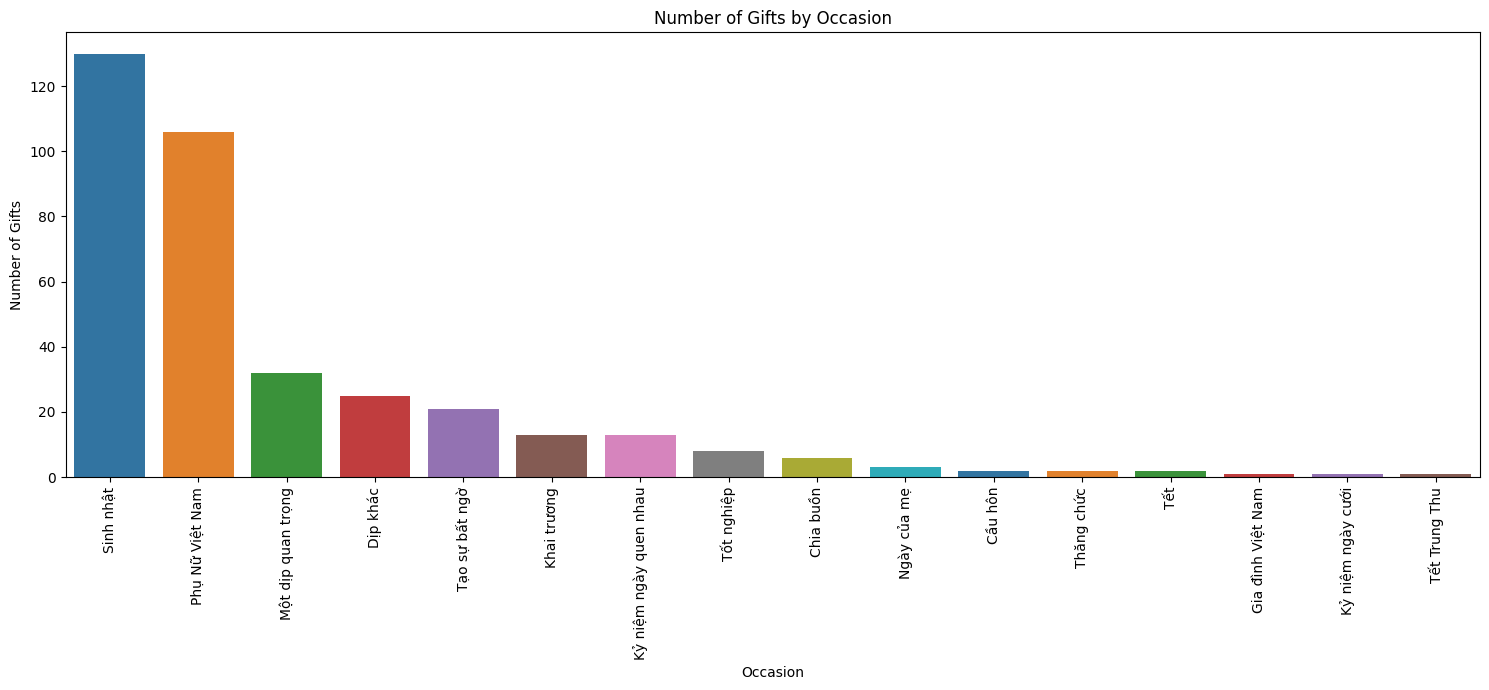

In [51]:
gifts_by_occasion = analysis.groupby('occasion_name')['gift_count'].sum().reset_index()
gifts_by_occasion = gifts_by_occasion.sort_values('gift_count', ascending=False)

plt.figure(figsize=(15, 7))
sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')
plt.xticks(rotation=90) 
plt.title('Number of Gifts by Occasion')
plt.xlabel('Occasion')
plt.ylabel('Number of Gifts')
plt.tight_layout() 
plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3364681679.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')


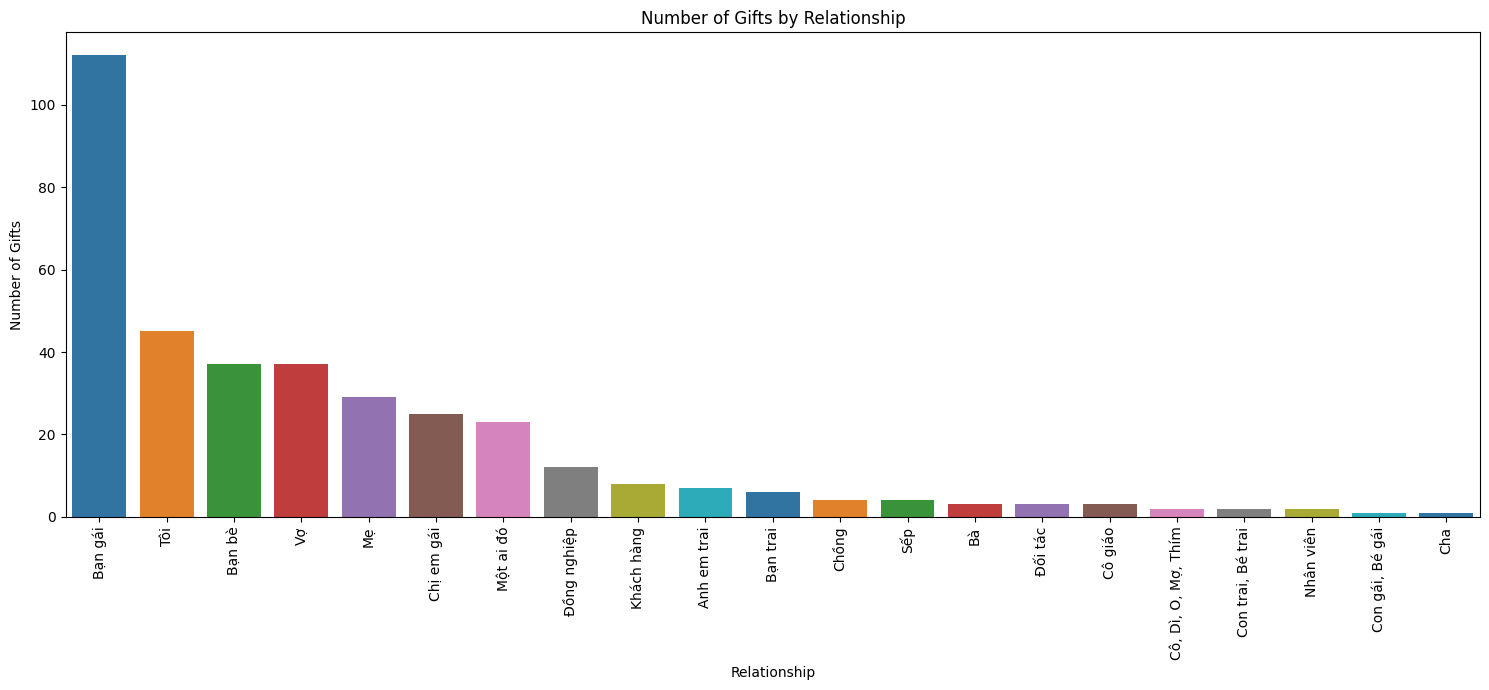

In [52]:
gifts_by_relationship = analysis.groupby('relationship_name')['gift_count'].sum().reset_index()
gifts_by_relationship = gifts_by_relationship.sort_values('gift_count', ascending=False)

plt.figure(figsize=(15, 7))
sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')
plt.xticks(rotation=90)
plt.title('Number of Gifts by Relationship')
plt.xlabel('Relationship')
plt.ylabel('Number of Gifts')
plt.tight_layout() 
plt.show()

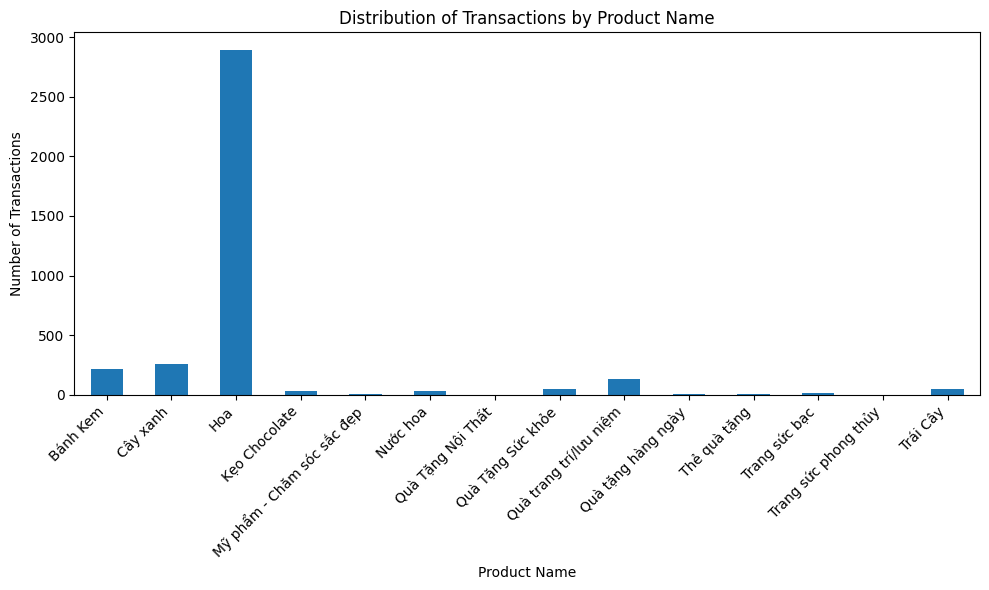

In [53]:
merged_data = pd.merge(data_bills, data_products, on='product_id', how='left')

grouped_product_transactions = merged_data.groupby('product_name').size()

plt.figure(figsize=(10, 6))
grouped_product_transactions.plot(kind='bar')
plt.title('Distribution of Transactions by Product Name')
plt.xlabel('Product Name')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

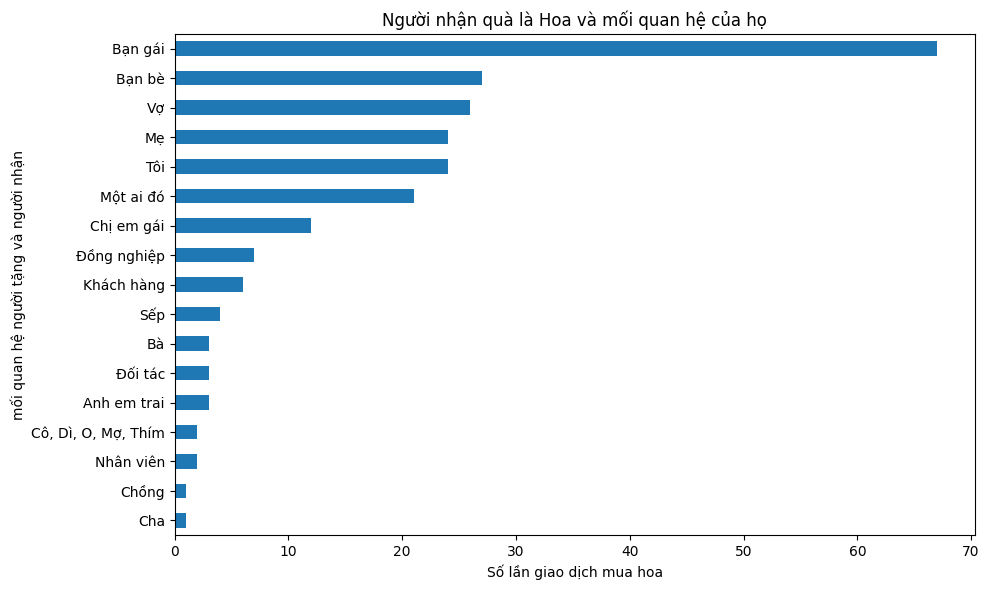

In [54]:
flowers_transactions = merged_data[merged_data['product_name'] == 'Hoa']

flowers_with_relationships = pd.merge(flowers_transactions, data_relationships, left_on='to_user_relationship_id', right_on='relationship_id', how='left')

grouped_relationship_trans = flowers_with_relationships.groupby('relationship_name').size()

grouped_relationship_trans_sorted = grouped_relationship_trans.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
grouped_relationship_trans_sorted.plot(kind='barh')  
plt.title('Người nhận quà là Hoa và mối quan hệ của họ')
plt.xlabel('Số lần giao dịch mua hoa')
plt.ylabel('mối quan hệ người tặng và người nhận')
plt.tight_layout()  
plt.gca().invert_yaxis()
plt.show()

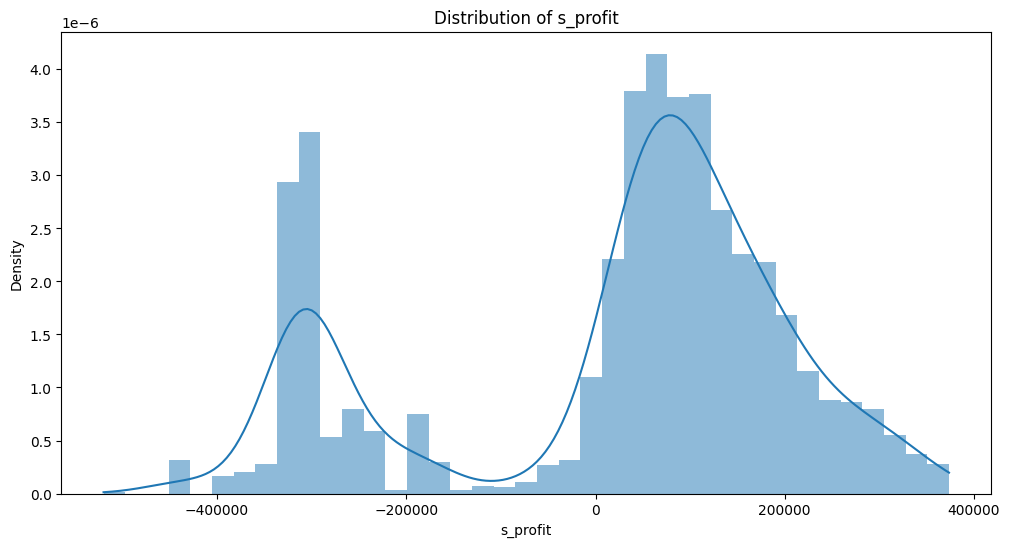

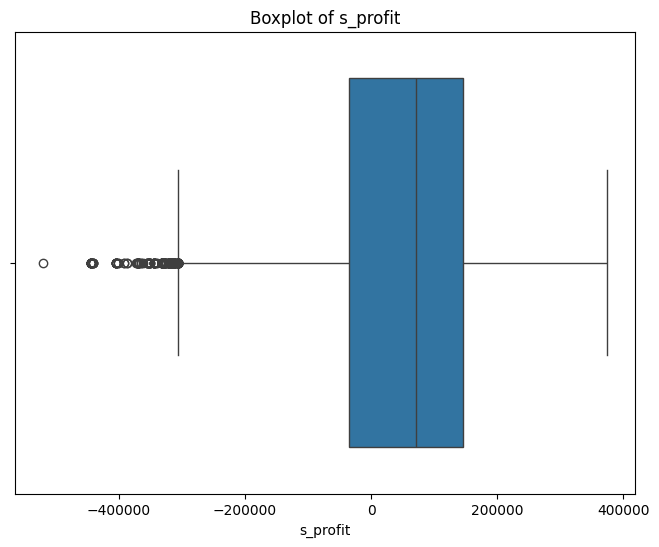

In [55]:
# df for testing
df = data_bills.copy()
plt.figure(figsize=(12, 6))
sns.histplot(df['s_profit'], kde=True, stat="density", linewidth=0)
plt.title('Distribution of s_profit')
plt.xlabel('s_profit')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['s_profit'])
plt.title('Boxplot of s_profit')
plt.xlabel('s_profit')
plt.show()

In [56]:
data_bills.sort_values('create_info_created', inplace=True)

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3406076999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_bills['s_profit_rolling'] = filtered_data_bills['s_profit'].rolling(window=30).mean()


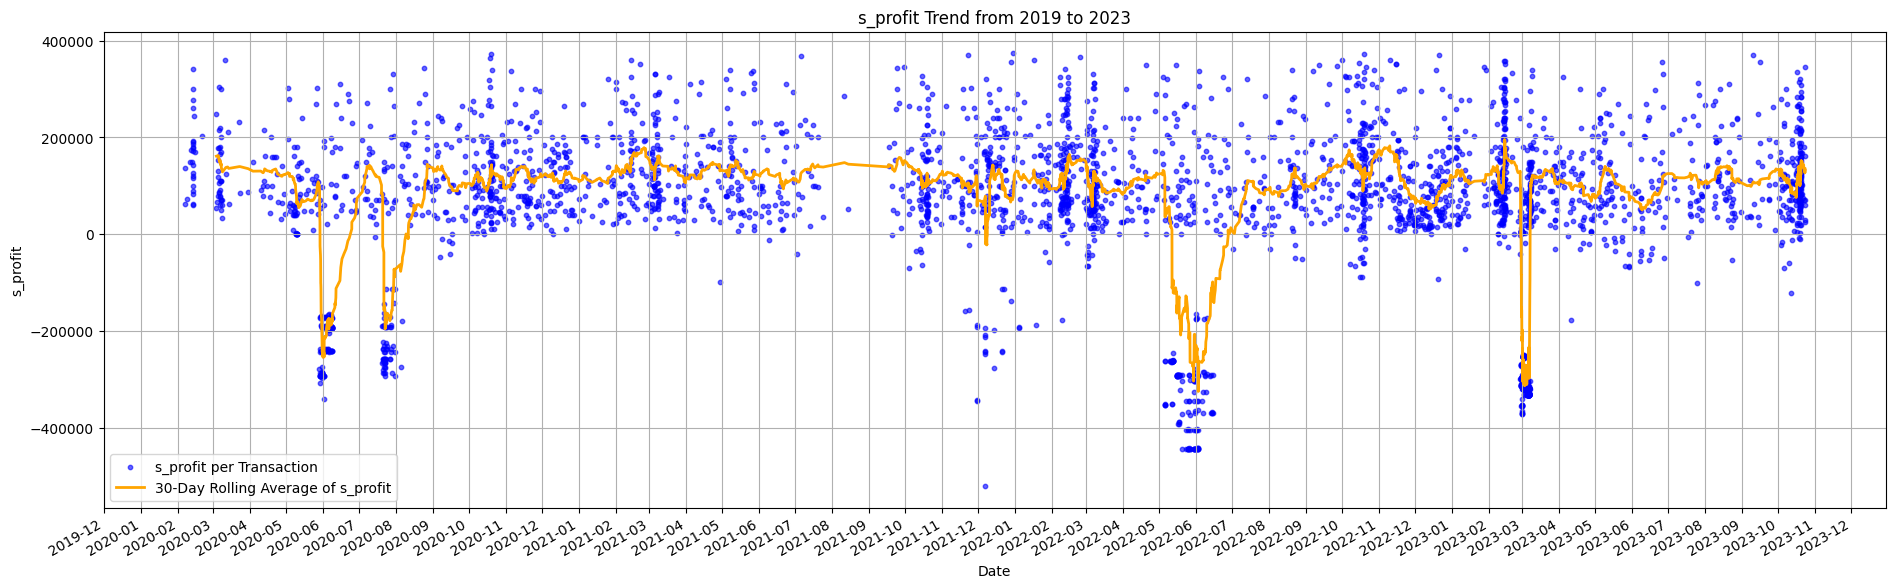

In [57]:
plt.figure(figsize=(23, 7))

start_date = pd.Timestamp('2020-01-01', tz='UTC')

# có 1 data point bị lạc nên bỏ luôn
filtered_data_bills = data_bills[data_bills['create_info_created'] > start_date]

plt.scatter(filtered_data_bills['create_info_created'], filtered_data_bills['s_profit'], 
            alpha=0.6, label='s_profit per Transaction', color='blue', s=10)

filtered_data_bills['s_profit_rolling'] = filtered_data_bills['s_profit'].rolling(window=30).mean()

plt.plot(filtered_data_bills['create_info_created'], filtered_data_bills['s_profit_rolling'], 
         label='30-Day Rolling Average of s_profit', color='orange', linewidth=2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

plt.gcf().autofmt_xdate()

plt.title('s_profit Trend from 2019 to 2023')
plt.xlabel('Date')
plt.ylabel('s_profit')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# visualize using Google Bigquery
data_bills.to_csv("for_bq.csv")

In [216]:
data_bills

_id               customer_id  \
24    5c4b83c7819a4e90043ec806  5bdafe20819a4eb22342cfaf   
179   5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   
180   5e3cb59cf8063622188b4569  5e3cb59bf8063622188b4567   
181   5e3e59d5f80636da078b4568  5e3a76db9d9b35bf7a8b4567   
182   5e4166d99d9b3597138b4568  5e3edbc69d9b35f4708b4567   
...                        ...                       ...   
4620  6535d8144a6a4d4fa005a6ae  6405c7adf2497cd09b02b0f6   
4618  6535d8144a6a4d4fa005a6ac  6405c7adf2497cd09b02b0f6   
4622  6536340b685b663e520da7e3  65362f2f058e39e1cf0ae5f3   
4621  6536340b685b663e520da7e2  65362f2f058e39e1cf0ae5f3   
4623  6536501b213d349ce10e1512  65364da659ec9f648f021e06   

                    product_id country_id  s_grand_total  s_discount_money  \
24    6066c157066c9a03055f2b10         VN       590000.0               0.0   
179   6066c157066c9a03055f2b10         VN       345000.0               0.0   
180   6066c157066c9a03055f2b10         VN       697500.0               0.0   
181   6066c157066c9a03055f2b10         VN       420000.0               0.0   
182   6066c157066c9a03055f2b10         VN       810000.0               0.0   
...                        ...        ...            ...               ...   
4620  6066c157066c9a03055f2b10         VN       210000.0               0.0   
4618  6066ce023a550774f46d43e3         VN       315000.0               0.0   
4622  6066c157066c9a03055f2b10         VN       691200.0               0.0   
4621  6066cd65ca52cc506817d471         VN       178200.0               0.0   
4623  6066c157066c9a03055f2b10         VN      1318000.0               0.0   

      s_commission       to_user_province_id   to_user_relationship_id  \
24        118000.0  5016fd6b7f8b9ac842000000                       NaN   
179        63000.0  5016fd6b7f8b9ac842000000                       NaN   
180       136500.0  5016fd6b7f8b9ac842000000                       NaN   
181        72000.0  5016fd6b7f8b9ac842000000                       NaN   
182       150000.0  5016fd6b7f8b9ac842000000                       NaN   
...            ...                       ...                       ...   
4620       26000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4618       70500.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   
4622      161200.0  5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
4621       30450.0  5016fd6c7f8b9ac84200003e  62374c93d092b077820bd62f   
4623      345000.0  5016fd6b7f8b9ac842000000  62374c93d092b077820bd62f   

           to_user_occasion_id       to_user_relative_id  \
24                         NaN  62bc755256bcb11219005567   
179                        NaN  62bc673e56bcb11219004f30   
180                        NaN  62bc673a56bcb11219004f2e   
181                        NaN  62bc675e56bcb11219004f3e   
182                        NaN  62bc66f956bcb11219004f11   
...                        ...                       ...   
4620  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
4618  62374e382511770c643d9a5a  6535d6f8496e105c1601e91b   
4622  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
4621  62374e382511770c643d9a5a  653632ec06ca66f2ec0d0b57   
4623  62374e382511770c643d9a5a  653650f02961ebea9c0a91e3   

                  to_user_date              create_info_created  \
24   2019-01-26 04:00:00+00:00 2019-01-25 21:46:46.233000+00:00   
179  2020-02-07 04:00:00+00:00 2020-02-06 11:01:19.401000+00:00   
180  2020-02-07 05:00:00+00:00 2020-02-07 00:55:55.123000+00:00   
181  2020-02-08 12:00:00+00:00 2020-02-08 06:48:52.854000+00:00   
182  2020-02-14 12:00:00+00:00 2020-02-10 14:21:12.467000+00:00   
...                        ...                              ...   
4620 2023-10-23 09:00:00+00:00 2023-10-23 02:19:00.226000+00:00   
4618 2023-10-23 11:00:00+00:00 2023-10-23 02:20:19.189000+00:00   
4622 2023-10-24 01:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
4621 2023-10-24 11:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
4623 2023-10-23 12:57:

In [59]:
data_bills_deep_analytics = data_bills.copy()

In [60]:
start_date = pd.to_datetime('2020-01-01').tz_localize('UTC')
data_bills_deep_analytics = data_bills[data_bills['create_info_created'] >= start_date]

In [61]:
data_1 = data_bills_deep_analytics.copy()

In [62]:
data_1['create_info_created'] = pd.to_datetime(data_1['create_info_created'])

first_purchase = data_1.groupby('customer_id')['create_info_created'].min().reset_index()
first_purchase.columns = ['customer_id', 'FirstPurchaseDate']

first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')

data_1 = pd.merge(data_1, first_purchase, on='customer_id', how='left')
data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')

cohort_data = data_1.groupby(['FirstPurchaseMonth', 'OrderPeriod']).agg(n_customers=('customer_id', 'nunique')).reset_index()

cohort_data['PeriodNumber'] = (cohort_data['OrderPeriod'] - cohort_data['FirstPurchaseMonth']).apply(attrgetter('n'))

cohort_counts = cohort_data.pivot_table(index='FirstPurchaseMonth', columns='PeriodNumber', values='n_customers')

print(cohort_counts)

PeriodNumber           0     1    2    3    4    5    6    7    8    9   ...  \
FirstPurchaseMonth                                                       ...   
2020-02              28.0   1.0  1.0  3.0  1.0  2.0  1.0  1.0  2.0  1.0  ...   
2020-03              38.0   NaN  NaN  NaN  NaN  NaN  1.0  3.0  1.0  NaN  ...   
2020-04              21.0   NaN  NaN  3.0  NaN  NaN  2.0  1.0  NaN  NaN  ...   
2020-05              99.0   1.0  4.0  2.0  4.0  3.0  1.0  2.0  1.0  1.0  ...   
2020-06             100.0   3.0  1.0  1.0  3.0  2.0  1.0  NaN  2.0  3.0  ...   
2020-07              80.0   4.0  2.0  4.0  NaN  NaN  NaN  1.0  1.0  NaN  ...   
2020-08              26.0   NaN  2.0  1.0  2.0  2.0  2.0  2.0  2.0  1.0  ...   
2020-09              33.0   1.0  3.0  3.0  NaN  2.0  1.0  1.0  1.0  NaN  ...   
2020-10              78.0   4.0  2.0  2.0  3.0  6.0  1.0  2.0  2.0  1.0  ...   
2020-11              46.0   1.0  3.0  5.0  1.0  1.0  1.0  NaN  1.0  NaN  ...   
2020-12              34.0   NaN  3.0  2.

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/788360346.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/788360346.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


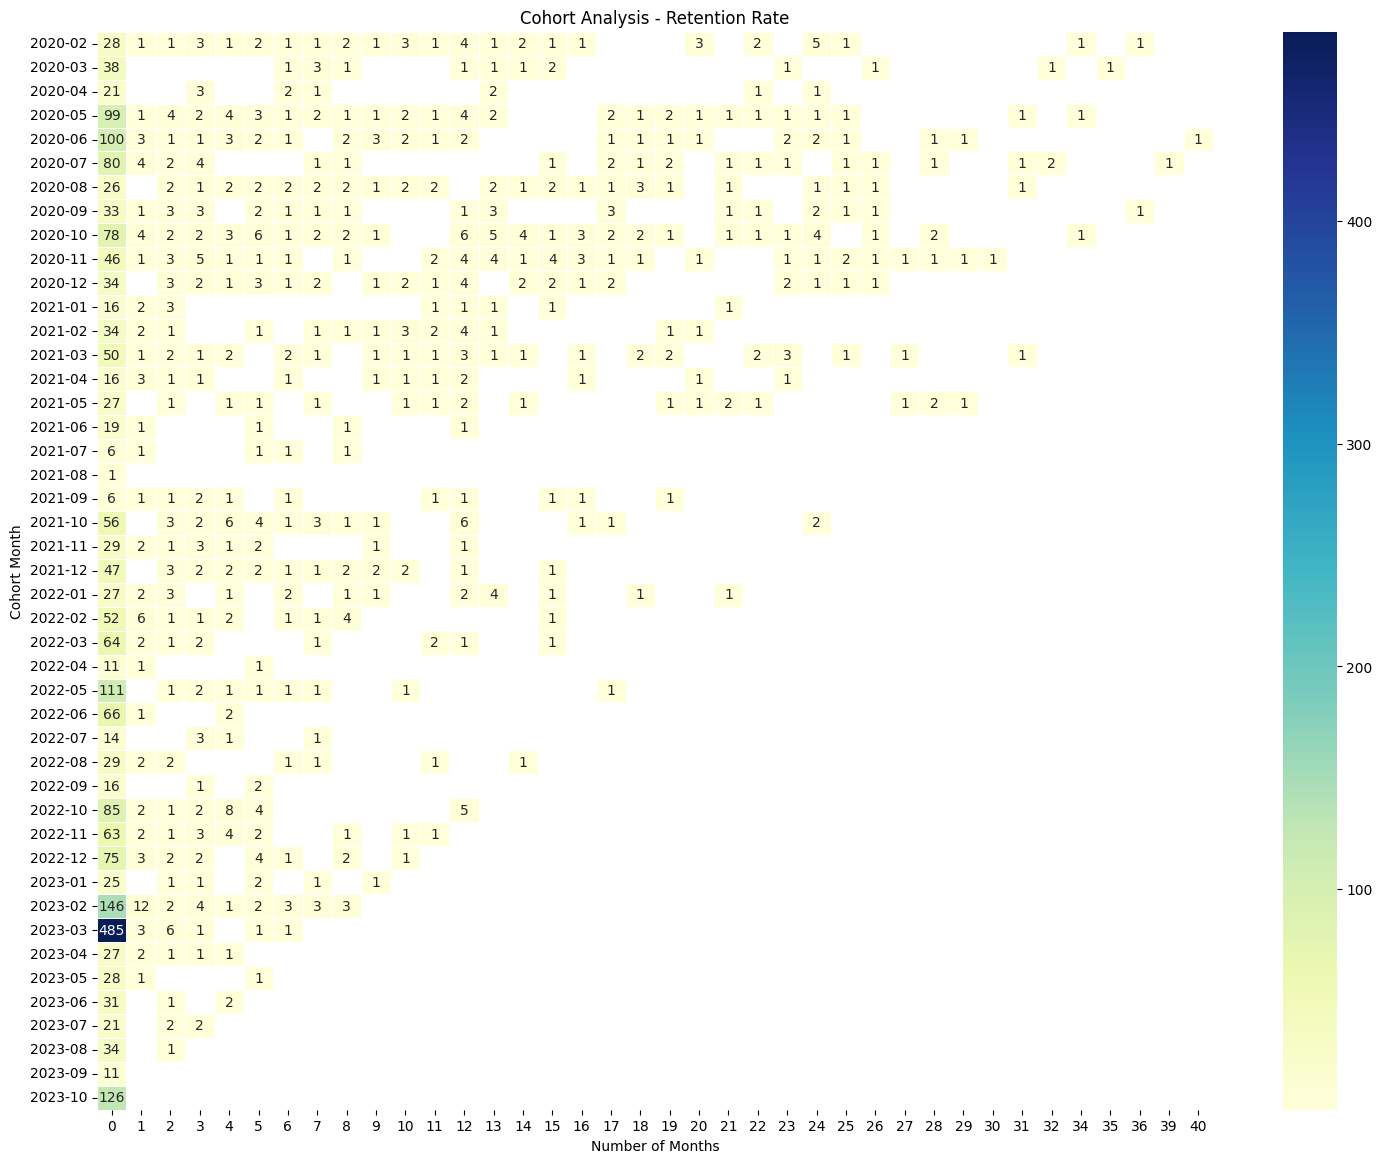

In [63]:
plt.figure(figsize=(18, 14))
sns.heatmap(cohort_counts, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Cohort Analysis - Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Number of Months')
plt.show()

<img src="overview2.jpg"/> 

Các giá trị và màu sắc trên biểu đồ heatmap phân tích Cohort cho ta thông tin về tỷ lệ giữ chân khách hàng cùng với các metric tài chính nhất định. Kết hợp với đồ thị tôi làm từ PowerBI để thấy rõ hơn bối cảnh toàn cục, ta chọn điểm dữ liệu tại x = 0 và y = 2023-03 dễ được thấy, sau đây là một số phân tích:

1. **Giá trị 485 và màu rất đậm:** Cho thấy rằng gấp 4.85 gần 5 lần số khách hàng từ nhóm bắt đầu vào tháng 3 năm 2023 đã mua hàng hoặc tương tác lại trong cùng tháng (x = 0, tức tháng khởi đầu), và một số lượng lớn khách hàng thực hiện hành động mua hàng biểu hiện qua màu sắc đậm, cho biết tỷ lệ giữ chân lớn.

2. **Discount cao và phát voucher free quà:** Đây có thể là chiến dịch marketing nhằm thu hút khách hàng mới hoặc khuyến khích khách hàng hiện tại mua sắm nhiều hơn. Mặc dù chiến lược này thành công trong việc tạo ra doanh số (số lượng hóa đơn tăng), nhưng nó cũng dẫn đến chi phí lớn hơn do giảm giá và phát quà.

3. **Revenue cao (s_grand_total):** Doanh thu cao chỉ ra rằng tổng giá trị của các giao dịch là lớn, nhưng điều này không nhất thiết phản ánh lợi nhuận ròng, bởi vì doanh thu không tính đến chi phí liên quan.

4. **Lợi nhuận âm (s_profit):** Điều này có nghĩa là tổng chi phí, bao gồm chiết khấu và phát quà, đã vượt quá doanh thu thu được. Kết quả là, mặc dù có sức mua cao và tỷ lệ giữ chân tốt, chiến lược giảm giá quá mức đã làm tiêu hao lợi nhuận ròng.

Tình huống này yêu cầu một sự đánh giá chi tiết về chiến lược giá và khuyến mãi. Doanh nghiệp cần cân nhắc giữa việc thu hút và giữ chân khách hàng so với việc duy trì một lợi nhuận khả quan để bảo đảm sự phát triển bền vững.

Prepare -> Scale -> Cluster Optimization -> Fit model & Visualization

In [64]:
data_2 = data_bills_deep_analytics.copy()

In [65]:
start_date = pd.to_datetime('2020-01-01').tz_localize('UTC')

data_2 = data_bills[data_bills['create_info_created'] >= start_date]

In [66]:
# Tính tần suất mua hàng cho mỗi khách hàng
frequency = data_2.groupby('customer_id').size().reset_index(name='frequency')

# Tính tổng số tiền chi tiêu cho mỗi khách hàng
total_spent = data_2.groupby('customer_id')['s_grand_total'].sum().reset_index()

# Tính tổng số tiền giảm giá cho mỗi khách hàng
total_discount = data_2.groupby('customer_id')['s_discount_money'].sum().reset_index()

# Gộp các khoản tính toán để tạo dataframe mới cho các features
customer_features = frequency.merge(total_spent, on='customer_id').merge(total_discount, on='customer_id')

# Loại bỏ khách hàng ID từ features trước khi điều chỉnh mô hình
X = customer_features.drop('customer_id', axis=1)

In [67]:
X.head(3)

frequency  s_grand_total  s_discount_money
0         13     11460000.0               0.0
1          1       483000.0            7000.0
2          1       514000.0               0.0

In [68]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

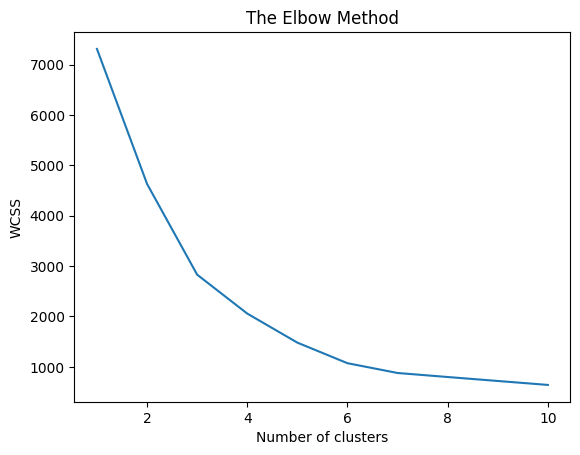

In [69]:
# test theo pp Elbow
wcss = []  # Within Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

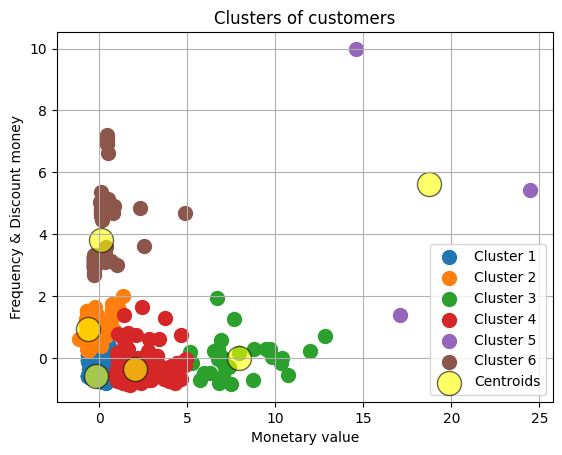

In [70]:
def plot_clusters(X, kmeans, n_clusters):
    # reduce dimensions for better visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # data points and marked cluster_id
    for cluster_id in range(n_clusters):
        plt.scatter(
            X_pca[kmeans.labels_ == cluster_id, 0], 
            X_pca[kmeans.labels_ == cluster_id, 1], 
            s=100, 
            label=f'Cluster {cluster_id+1}'
        )

    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(
        centroids[:, 0], 
        centroids[:, 1], 
        s=300, 
        c='yellow', 
        label='Centroids', 
        alpha=0.6, 
        edgecolors='black'
    )
    
    plt.title('Clusters of customers')
    plt.xlabel('Monetary value')
    plt.ylabel('Frequency & Discount money')
    plt.legend()
    plt.grid(True)
    plt.show()

n_clusters_chosen = 6
kmeans = KMeans(n_clusters=n_clusters_chosen, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_scaled)

plot_clusters(X_scaled, kmeans, n_clusters_chosen)

In [71]:
def print_cluster_centers(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    
    centroids = kmeans.cluster_centers_

    for i, center in enumerate(centroids):
        print(f"Centroid của cluster {i + 1}: {center}")

print_cluster_centers(X_scaled, n_clusters=n_clusters_chosen)

Centroid của cluster 1: [-0.21107735 -0.05835685 -0.57674896]
Centroid của cluster 2: [-0.26825974 -0.56221066  0.91893662]
Centroid của cluster 3: [ 5.32769857  5.93734024 -0.1440809 ]
Centroid của cluster 4: [ 1.27915013  1.59397739 -0.39300958]
Centroid của cluster 5: [15.97849522 10.70529364  4.2430963 ]
Centroid của cluster 6: [ 0.71210084 -0.39082008  3.72319586]


/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Dựa trên biểu đồ phân nhóm, những gợi ý sau có thể giúp cải thiện việc thu hút và giữ chân khách hàng:

1. **Cluster 1 - Thấp ở tất cả các khía cạnh:**
   - **Kích thích Tần Suất:** Phát triển chương trình khách hàng thân thiết, cung cấp quyền lợi cho khách hàng theo số lần mua hàng.
   - **Marketing Targeted:** Tập trung vào việc nhắm đến loại khách hàng này với thông tin sản phẩm và khuyến mãi hấp dẫn để thúc đẩy họ chi tiêu nhiều hơn.

2. **Cluster 2 - Tần suất mua hàng cao nhưng tiền chi tiêu và chiết khấu thấp:**
   - **Chăm sóc Khách Hàng Đặc Biệt:** Khảo sát nhóm này để hiểu rõ hơn về nhu cầu và cung cấp các dịch vụ hoặc sản phẩm phù hợp hơn.
   - **Đánh giá Chính Sách Giảm Giá:** Nghiên cứu liệu có cần thiết phải tăng mức chiết khấu để khuyến khích họ chi tiêu nhiều hơn nữa hay không.

3. **Cluster 3 - Tiêu dùng và ưu đãi cả hai đều cao:**
   - **Tối ưu Chiết Khấu:** Xem xét lại các chương trình ưu đãi để đảm bảo rằng chúng không ảnh hưởng tiêu cực đến lợi nhuận.
   - **Tăng Cường Trung Thành:** Xây dựng chương trình trung thành mạnh mẽ để giữ chân khách hàng mà không phải dựa hoàn toàn vào chiết khấu.

4. **Cluster 4 - Tiêu dùng và tần suất mua hàng thấp, chiết khấu vừa phải:**
   - **Chủ Động Marketing:** Phát triển các chiến dịch nhằm tăng tần suất mua hàng và nâng cao giá trị đơn hàng.
   - **Phân tích Đối Tượng:** Hiểu rõ hơn về lý do của việc tiêu dùng thấp, có thể thông qua khảo sát hoặc phân tích dữ liệu mua hàng.

5. **Cluster 5 - Mọi chỉ số đều rất cao:**
   - **Quản Lý Chiết Khấu:** Kiểm tra và quản lý chiết khấu để tránh gây tổn hại tới lợi nhuận tổng thể.
   - **Phân tích Chất Lượng Khách Hàng:** Đảm bảo rằng khách hàng không lạm dụng các chương trình ưu đãi.

6. **Cluster 6 - Tiêu dùng và chiết khấu cao, tần suất mua hàng vừa phải:**
   - **Cá nhân Hóa Ưu Đãi:** Cung cấp giảm giá và ưu đãi dựa trên hành vi mua sắm cụ thể của khách hàng để thúc đẩy sự trung thành.
   - **Phân tích Sở Thích:** Sử dụng dữ liệu để hiểu rõ sở thích mua sắm và cung cấp sản phẩm hoặc dịch vụ phù hợp với những sở thích đó.

Đối với mỗi cluster, việc hiểu rõ khách hàng và thiết kế các chương trình marketing cũng như chăm sóc khách hàng có mục tiêu và cá nhân hóa sẽ là chìa khóa để tăng cả sự trung thành và lợi nhuận. Kết hợp data analysis với feedback từ khách hàng để thông tin cho chiến lược cá nhân hóa có thể giúp công ty phân phối ngân sách và nguồn lực một cách đắc lực nhất.

In [72]:
data_3 = data_bills_deep_analytics.copy()

In [73]:
data_3 = data_3.sort_values(['customer_id', 'create_info_created'])
data_3['create_info_created'] = pd.to_datetime(data_3['create_info_created'])

# Tạo cột 'next_purchase' thể hiện thời gian cho lần mua tiếp theo
data_3['next_purchase'] = data_3.groupby('customer_id')['create_info_created'].shift(-1)

# Tính 'duration' là khoảng thời gian giữa lần mua này và lần mua tiếp theo
data_3['duration'] = (data_3['next_purchase'] - data_3['create_info_created']).dt.days

# Tạo cột 'event_observed' mà trong đó 1 nếu có lần mua tiếp theo, còn lại là 0
data_3['event_observed'] = 1
data_3['event_observed'] = data_3['event_observed'].where(data_3['next_purchase'].notnull(), 0)

<Axes: xlabel='timeline'>

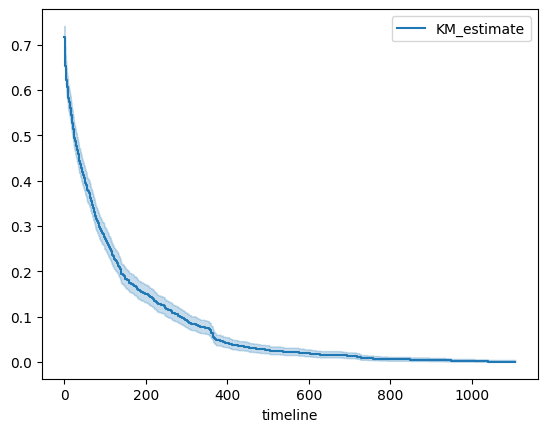

In [74]:
data_for_survival = data_3[['_id', 'create_info_created', 'next_purchase', 'duration', 'event_observed']].copy()

# Loại bỏ các dòng có giá trị NaN trong cột 'duration' hoặc 'next_purchase'
data_for_survival.dropna(subset=['duration', 'next_purchase'], inplace=True)

from lifelines import KaplanMeierFitter

# KaplanMeierFitter
kmf = KaplanMeierFitter()
T = data_for_survival['duration']
E = data_for_survival['event_observed']

kmf.fit(T, event_observed=E)

kmf.plot_survival_function()

Phân tích biểu đồ survival:

1. **Giai đoạn đầu (0 - 200 ngày):** Tỷ lệ survival giảm rất nhanh từ 0,7 xuống còn 0,15, cho thấy sau khi khách hàng mua hàng lần đầu, sự giữ chân khách hàng và tái mua hàng giảm xuống mạnh mẽ. Điều này có thể liên quan đến:
    - Sự hài lòng của khách hàng sau mua hàng đầu tiên không cao.
    - Không có đủ chương trình khách hàng thân thiết để khuyến khích họ quay lại.
    - Sản phẩm hoặc dịch vụ có thể không đáp ứng được kỳ vọng, hoặc không cạnh tranh được so với thị trường.

2. **Giai đoạn trung gian (200 - 600 ngày):** Tỷ lệ này tiếp tục giảm nhưng với tốc độ chậm hơn, điều này cho thấy những khách hàng còn lại sau giai đoạn đầu có xu hướng trung thành tốt hơn, nhưng tỷ lệ giữ chân vẫn tiếp tục giảm. Có thể đây là nhóm khách hàng hài lòng nhưng cần thêm động lực để tái mua.

3. **Giai đoạn dài hạn (600 ngày trở lên):** Tỷ lệ survival tựa như tiệm cận đến mức 0,03 và giữ vững ở đấy khi đi qua 1000 ngày, cho thấy một nhóm rất nhỏ khách hàng vẫn còn trung thành sau một thời gian dài. Đây có thể là các khách hàng gắn bó, hoặc những người hưởng lợi từ các dịch vụ/ sản phẩm không thể so sánh được.

Dựa trên thông tin này, công ty cần tập trung vào việc cải thiện trải nghiệm khách hàng ngay từ giao dịch đầu tiên để giảm tốc độ suy giảm của tỷ lệ survival trong giai đoạn đầu, đồng thời xây dựng các chương trình nhằm tăng cường sự gắn bó và công nhận đối với khách hàng trung thành. Một số chiến lược có thể bao gồm:

- Cải thiện chất lượng sản phẩm/dịch vụ để đạt kỳ vọng khách hàng ngay từ lần mua hàng đầu tiên.
- Tiến hành khảo sát hiệu chỉnh để hiểu rõ lý do khiến họ không quay lại mua sắm.
- Xây dựng chương trình loại bỏ những rào cản tái mua thông qua ưu đãi, chương trình tích điểm, hoặc thành viên VIP.
- Cung cấp quảng bá, hỗ trợ, và chăm sóc sau bán hàng để duy trì mối quan hệ với khách hàng sau giao dịch đầu tiên.
- Phát triển chiến lược nội dung và tiếp thị để tạo dựng một cộng đồng khách hàng gắn kết và trung thành.

In [75]:
data_4 = data_bills_deep_analytics.copy()

In [76]:
data_4.head(1)

_id               customer_id  \
179  5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   

                   product_id country_id  s_grand_total  s_discount_money  \
179  6066c157066c9a03055f2b10         VN       345000.0               0.0   

     s_commission       to_user_province_id to_user_relationship_id  \
179       63000.0  5016fd6b7f8b9ac842000000                     NaN   

    to_user_occasion_id       to_user_relative_id              to_user_date  \
179                 NaN  62bc673e56bcb11219004f30 2020-02-07 04:00:00+00:00   

                 create_info_created     to_province  s_profit  \
179 2020-02-06 11:01:19.401000+00:00  TP Hồ Chí Minh   63000.0   

     s_profit_in_USD  
179         2.611615

In [77]:
merged_data = pd.merge(data_4, data_products, on='product_id', how='left')

# sx dữ liệu theo 'customer_id' và 'to_user_date'
merged_data_sorted = merged_data.sort_values(by=['customer_id', 'to_user_date'])

transactions_with_names = merged_data_sorted.groupby('customer_id')['product_name'].apply(list)

sequences_with_names = transactions_with_names.tolist()

# Sequential Pattern Mining với PrefixSpan
ps = PrefixSpan(sequences_with_names)

# Tìm common patterns với minimum support
patterns_with_names = ps.frequent(2)  # Ví dụ: đặt minimum support là 2

# In ra các mẫu tìm được
for pattern in patterns_with_names:
    print(pattern)


(1960, ['Hoa'])
(438, ['Hoa', 'Hoa'])
(177, ['Hoa', 'Hoa', 'Hoa'])
(101, ['Hoa', 'Hoa', 'Hoa', 'Hoa'])
(67, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(46, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(29, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(19, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(12, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(10, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(9, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(7, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(6, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(4, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(3, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', '

In [78]:
# !pip install networkx

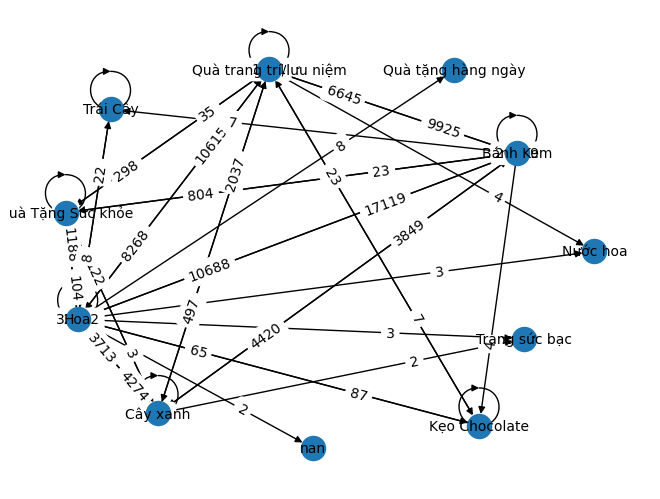

In [79]:
# Vẽ network graph
G = nx.DiGraph()

# Đảm bảo rằng mỗi cạnh được thêm vào có weight là số lần xuất hiện của mẫu
for support, items in patterns_with_names:
    for i in range(len(items)-1):
        # Check xem cạnh đã có trong graph hay chưa để cộng dồn support
        if G.has_edge(items[i], items[i+1]):
            # Tăng weight (support) của cạnh nếu nó đã tồn tại
            G[items[i]][items[i+1]]['weight'] += support
        else:
            # Tạo cạnh mới với weight bằng support nếu nó chưa tồn tại
            G.add_edge(items[i], items[i+1], weight=support)

pos = nx.spring_layout(G, k=200) # có thể tăng giá trị 'k' để tăng khoảng cách

node_size = 300
font_size = 10
nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=font_size)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3) # Thử điều chỉnh label_pos để thay đổi vị trí nhãn cạnh

plt.show()

      Support                         Pattern  Length
0        1960                           [Hoa]       1
1         438                      [Hoa, Hoa]       2
7898      237                      [Cây xanh]       1
2         177                 [Hoa, Hoa, Hoa]       3
8254      157                      [Bánh Kem]       1
6728      106        [Quà trang trí/lưu niệm]       1
3         101            [Hoa, Hoa, Hoa, Hoa]       4
4          67       [Hoa, Hoa, Hoa, Hoa, Hoa]       5
4823       49                 [Hoa, Bánh Kem]       2
5          46  [Hoa, Hoa, Hoa, Hoa, Hoa, Hoa]       6


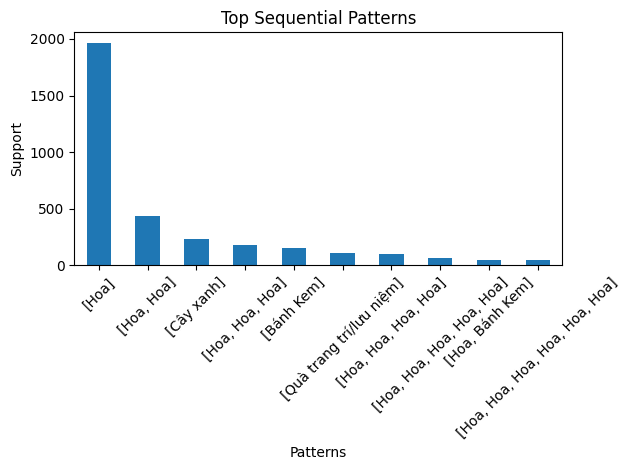

In [80]:
patterns_df = pd.DataFrame(patterns_with_names, columns=['Support', 'Pattern'])
patterns_df['Length'] = patterns_df['Pattern'].apply(len)  # add cột Length vào dataframe

print(patterns_df.sort_values(by='Support', ascending=False).head(10))  

# Visualize: ví dụ dùng bar plot cho support
patterns_df.sort_values(by='Support', ascending=False).head(10).plot(
    x='Pattern', 
    y='Support', 
    kind='bar', 
    legend=None,
    title='Top Sequential Patterns'
)
plt.xlabel('Patterns')
plt.ylabel('Support')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

Kết quả từ sequential pattern mining phản ánh một số thông tin chính về xu hướng mua sắm và hành vi của khách hàng tại MyCompany:

1. **Sản phẩm "Hoa" rất phổ biến**: Điều này được chứng minh bởi việc "Hoa" xuất hiện không chỉ ở các mẫu đơn lẻ với support cao nhất mà còn ở nhiều kết hợp chuỗi khác nhau và có sự lặp lại. Điều này cho thấy khách hàng không chỉ mua "Hoa" một lần mà còn mua lặp lại nhiều lần.

2. **Có sự gia tăng tỷ lệ mua hàng liên tiếp**: Các patterns với độ dài từ 2-6 phần (ví dụ: "Hoa, Hoa", "Hoa, Hoa, Hoa", ... đến "Hoa, Hoa, Hoa, Hoa, Hoa, Hoa") có tỷ lệ support giảm dần theo độ dài của chuỗi, nhưng vẫn đủ đáng kể để lưu ý. Mọi người đã không chỉ mua hoa một lần mà còn mua lặp đi lặp lại theo thời gian, điều này là dấu hiệu của sự trung thành và thói quen mua sắm.

3. **Các sản phẩm khác như "Cây xanh" và "Bánh Kem" cũng có mức độ phổ biến nhất định**, nhưng không cao bằng "Hoa". Điều này có thể phản ánh một thị hiếu hoặc nhu cầu phụ, hoặc các sản phẩm mùa vụ/tùy từng dịp.

4. **Có sự kết hợp giữa "Hoa" và "Bánh Kem"**: Mặc dù ít phổ biến hơn các patterns chỉ có "Hoa", sự kết hợp này có thể phản ánh một xu hướng tặng quà kết hợp, như hoa và bánh kem trong các dịp đặc biệt.

Dựa trên những phân tích này, chiến lược có thể đề xuất:

- **Tối ưu chiến dịch marketing**: Hướng dẫn khách hàng về việc lựa chọn hoa làm quà tặng cho các dịp đặc biệt.
- **Tập trung vào các sản phẩm phổ biến**: Duy trì sự sẵn có và đa dạng của những sản phẩm "Hoa" để đáp ứng nhu cầu cao từ khách hàng.
- **Bundling (gói kết hợp sản phẩm)**: Tạo các gói sản phẩm kết hợp "Hoa" và "Bánh Kem" hoặc "Hoa" với "Cây xanh" để tăng doanh thu từ bán hàng chéo.
- **Nhắm mục tiêu đặc biệt vào các đợt khuyến mãi**: Điều chỉnh chiến lược giảm giá và khuyến mãi để khuyến khích khách hàng mua các sản phẩm phổ biến nhiều hơn.
- **Chương trình khách hàng trung thành**: Phát triển chương trình để khuyến khích khách hàng mua lại bằng cách cung cấp ưu đãi đặc biệt sau một số giao dịch nhất định hoặc qua việc tích lũy điểm thưởng.

In [81]:
data_5 = data_bills_deep_analytics.copy()
data_5.head(1)

_id               customer_id  \
179  5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   

                   product_id country_id  s_grand_total  s_discount_money  \
179  6066c157066c9a03055f2b10         VN       345000.0               0.0   

     s_commission       to_user_province_id to_user_relationship_id  \
179       63000.0  5016fd6b7f8b9ac842000000                     NaN   

    to_user_occasion_id       to_user_relative_id              to_user_date  \
179                 NaN  62bc673e56bcb11219004f30 2020-02-07 04:00:00+00:00   

                 create_info_created     to_province  s_profit  \
179 2020-02-06 11:01:19.401000+00:00  TP Hồ Chí Minh   63000.0   

     s_profit_in_USD  
179         2.611615

In [82]:
# Lấy ngày gần nhất trong dataset để tính toán Recency
# Giả định rằng 'to_user_date' cung cấp thông tin về lần mua hàng gần nhất
latest_date = data_5['to_user_date'].max() + timedelta(days=1)

rfm = data_5.groupby('customer_id').agg({
    'to_user_date': lambda x: (latest_date - x.max()).days,  # Recency
    'customer_id': 'size',                                  # Frequency
    's_profit': 'sum',                                 # Monetary value
}).rename(columns={'to_user_date': 'Recency',
                   'customer_id': 'Frequency',
                   's_profit': 'MonetaryValue'})

In [83]:
rfm.head(2)

Recency  Frequency  MonetaryValue
customer_id                                                
571c3c1d7f8b9ae9557fd9c5      350         13      2292000.0
57677b207f8b9a2b763b525a     1320          1        61600.0

In [84]:
quantiles = rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

# Hàm để tính điểm Recency (nhỏ hơn là tốt)
def RScore(x, p, d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 2
    else:
        return 1

# Hàm để tính điểm Frequency và Monetary (lớn hơn là tốt)
def FMScore(x, p, d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]:
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

In [85]:
rfm['R_Quartile'] = rfm['Recency'].apply(RScore, args=('Recency', quantiles,))
rfm['F_Quartile'] = rfm['Frequency'].apply(FMScore, args=('Frequency', quantiles,))
rfm['M_Quartile'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue', quantiles,))

rfm['RFM_Segment'] = rfm['R_Quartile'].map(str) + rfm['F_Quartile'].map(str) + rfm['M_Quartile'].map(str)
rfm['RFM_Score'] = rfm['R_Quartile'] + rfm['F_Quartile'] + rfm['M_Quartile']

rfm = rfm.sort_values(by=['RFM_Score'], ascending=[False])

rfm.head(1)

Recency  Frequency  MonetaryValue  R_Quartile  \
customer_id                                                               
5eb8291f9d9b357a3b8b4569       37          6       939345.0           5   

                          F_Quartile  M_Quartile RFM_Segment  RFM_Score  
customer_id                                                              
5eb8291f9d9b357a3b8b4569           5           5         555         15

<img src="rfm_matching_scores.png"/>

In [86]:
# Define the segments and corresponding scores
# ref: https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
segments = {
    'Champions': ['555', '554', '544', '545', '454', '455', '445'],
    'Loyal': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalists': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About To Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'Cannot Lose Them But Losing': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
    'Hibernating Customers': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Losing But Engaged': ['111', '112', '121', '131', '141', '151'],
    'Lost Customers': ['111', '112', '121', '131', '141', '151']
}

In [87]:
rfm['Segment'] = ''  

for segment, scores in segments.items():
    rfm.loc[rfm['RFM_Segment'].isin(scores), 'Segment'] = segment
    
rfm

Recency  Frequency  MonetaryValue  R_Quartile  \
customer_id                                                               
5eb8291f9d9b357a3b8b4569       37          6       939345.0           5   
647d735ea02488424e0c3969        5          3       508900.0           5   
644213299205569fe506e86f      188          3       296070.0           5   
6319344f4de3f41eb003d806      190          7       948526.0           5   
64476dc2c49b98ef980afcee       91          4       590561.0           5   
...                           ...        ...            ...         ...   
5f17b0d0abafdf774d4d61c3     1181          1      -293400.0           1   
5ed5b68e408a5381208b4567     1240          1      -293400.0           1   
5f190244ef8c621171697d32     1189          1      -293400.0           1   
5ed5bbaf9d9b3512348b456b     1239          1      -293400.0           1   
5ed4d2089d9b35f02c8b4567     1240          1      -340240.0           1   

                          F_Quartile  M_Quartile RFM_Segment  RFM_Score  \
customer_id                                                               
5eb8291f9d9b357a3b8b4569           5           5         555         15   
647d735ea02488424e0c3969           5           5         555         15   
644213299205569fe506e86f           5           5         555         15   
6319344f4de3f41eb003d806           5           5         555         15   
64476dc2c49b98ef980afcee           5           5         555         15   
...                              ...         ...         ...        ...   
5f17b0d0abafdf774d4d61c3           1           1         111          3   
5ed5b68e408a5381208b4567           1           1         111          3   
5f190244ef8c621171697d32           1           1         111          3   
5ed5bbaf9d9b3512348b456b           1           1         111          3   
5ed4d2089d9b35f02c8b4567           1           1         111          3   

                                 Segment  
customer_id                               
5eb8291f9d9b357a3b8b4569       Champions  
647d735ea02488424e0c3969       Champions  
644213299205569fe506e86f       Champions  
6319344f4de3f41eb003d806       Champions  
64476dc2c49b98ef980afcee       Champions  
...                                  ...  
5f17b0d0abafdf774d4d61c3  Lost Customers  
5ed5b68e408a5381208b4567  Lost Customers  
5f190244ef8c621171697d32  Lost Customers  
5ed5bbaf9d9b3512348b456b  Lost Customers  
5ed4d2089d9b35f02c8b4567  Lost Customers  

[2437 rows x 9 columns]

In [88]:
# after the groupby operation, reset the index to turn 'customer_id' back into a column.
rfm = rfm.reset_index()

In [89]:
total_segment_counts = rfm.index.nunique()

segment_counts = rfm['Segment'].value_counts()

segment_percent = (segment_counts / total_segment_counts * 100).round(2)

In [90]:
segment_df = segment_counts.reset_index()

segment_df.columns = ['Segment', 'Count']

segment_df['Percent'] = (segment_df['Count'] / total_segment_counts * 100).round(2)

segment_df

Segment  Count  Percent
0                     Promising    533    21.87
1                 New Customers    497    20.39
2   Cannot Lose Them But Losing    415    17.03
3                About To Sleep    215     8.82
4                       At Risk    192     7.88
5                Lost Customers    182     7.47
6                     Champions    119     4.88
7                         Loyal    106     4.35
8           Potential Loyalists    101     4.14
9         Hibernating Customers     73     3.00
10               Need Attention      4     0.16

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/826904618.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


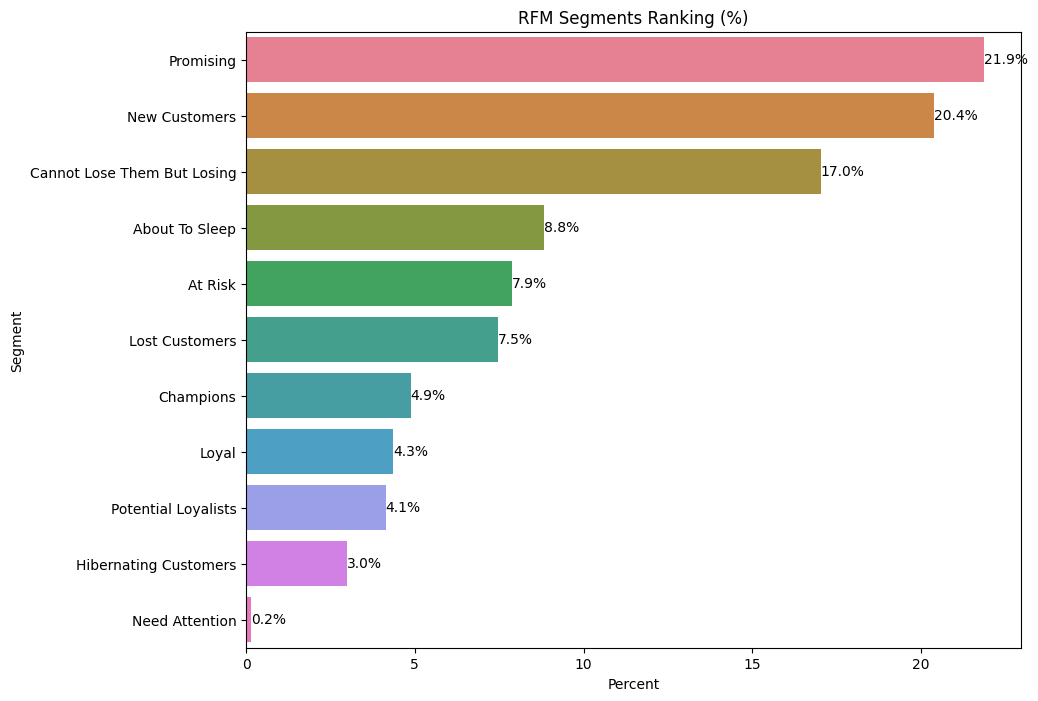

In [91]:
rfm_data_with_percentageSegment = segment_df.sort_values(by='Percent', ascending=False)  # Sort for better visual representation

colors = sns.color_palette("husl", len(rfm_data_with_percentageSegment))

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x='Percent', 
    y='Segment', 
    data=rfm_data_with_percentageSegment, 
    palette=colors
)

plt.title('RFM Segments Ranking (%)')
plt.xlabel('Percent')
plt.ylabel('Segment')

for p in ax.patches:
    bar_width = p.get_width()
    ax.text(p.get_width(), p.get_y() + p.get_height()/2,
            f'{bar_width:.1f}%', 
            va='center', ha='left')
    
plt.show()

In [92]:
data_6 = data_bills_deep_analytics.copy()

In [93]:
# Breaking down the calculation step by step to calculate average_customer_lifespan:
# Step 1 - Calculate the products of period number and customer count for each cohort period.

#based on above
cohort_lifespan = cohort_counts.copy()
for i in cohort_lifespan.columns:
    cohort_lifespan[i] = cohort_lifespan[i] * i

# Step 2 - Sum these products for each cohort.
cohort_lifetime_months = cohort_lifespan.sum(axis=1)

# Step 3 - Sum the initial customer counts across all cohorts.
total_customers = cohort_counts[0].sum()

# Step 4 - Compute the average customer lifespan.
average_customer_lifespan = cohort_lifetime_months.sum() / total_customers

print(f'The average customer lifespan is: {average_customer_lifespan} months')

The average customer lifespan is: 2.9507591300779645 months


In [94]:
# 1. Timeframe: Assuming the data covers the full timeframe of interest
#    If you want to focus on a specific period adjust the dataframe accordingly.

# 2. Average purchase value
average_purchase_value = data_6['s_grand_total'].sum() / data_6['s_grand_total'].count()

# 3. Average purchase frequency rate
average_purchase_frequency = data_6['s_grand_total'].count() / data_6['customer_id'].nunique()

# 4. Customer value
customer_value = average_purchase_value * average_purchase_frequency

# 5. Average customer lifespan: You'd typically need historical data to calculate this.
# Here, we will need to figure out the repeat purchase rate or use industry benchmarks if we lack historical data.
# Assuming you somehow computed this value:

# average_customer_lifespan = # calculated
# 6. Calculate CLV
CLV = customer_value * average_customer_lifespan
CLV

2319239.54751035

In [95]:
data_6 = pd.merge(data_5, rfm, on='customer_id')

In [96]:
columns_to_drop = ['to_user_province_id', 'to_user_relationship_id', 'to_user_occasion_id', 'to_user_relative_id', 's_profit_in_USD', 'to_province']

# Bỏ các cột khỏi DataFrame
data_6 = data_6.drop(columns=columns_to_drop)
data_6

_id               customer_id  \
0     5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   
1     5e3cb59cf8063622188b4569  5e3cb59bf8063622188b4567   
2     5e92a11ef80636ea3f8b4569  5e3cb59bf8063622188b4567   
3     61c12da359801f575954bd29  5e3cb59bf8063622188b4567   
4     5e3e59d5f80636da078b4568  5e3a76db9d9b35bf7a8b4567   
...                        ...                       ...   
3699  6535d8144a6a4d4fa005a6ae  6405c7adf2497cd09b02b0f6   
3700  6535d8144a6a4d4fa005a6ac  6405c7adf2497cd09b02b0f6   
3701  6536340b685b663e520da7e3  65362f2f058e39e1cf0ae5f3   
3702  6536340b685b663e520da7e2  65362f2f058e39e1cf0ae5f3   
3703  6536501b213d349ce10e1512  65364da659ec9f648f021e06   

                    product_id country_id  s_grand_total  s_discount_money  \
0     6066c157066c9a03055f2b10         VN       345000.0               0.0   
1     6066c157066c9a03055f2b10         VN       697500.0               0.0   
2     6066c157066c9a03055f2b10         VN       560000.0               0.0   
3     6066c157066c9a03055f2b10         VN       616000.0               0.0   
4     6066c157066c9a03055f2b10         VN       420000.0               0.0   
...                        ...        ...            ...               ...   
3699  6066c157066c9a03055f2b10         VN       210000.0               0.0   
3700  6066ce023a550774f46d43e3         VN       315000.0               0.0   
3701  6066c157066c9a03055f2b10         VN       691200.0               0.0   
3702  6066cd65ca52cc506817d471         VN       178200.0               0.0   
3703  6066c157066c9a03055f2b10         VN      1318000.0               0.0   

      s_commission              to_user_date              create_info_created  \
0          63000.0 2020-02-07 04:00:00+00:00 2020-02-06 11:01:19.401000+00:00   
1         136500.0 2020-02-07 05:00:00+00:00 2020-02-07 00:55:55.123000+00:00   
2         100000.0 2020-04-12 09:00:00+00:00 2020-04-12 05:03:26.818000+00:00   
3         156000.0 2021-12-25 01:00:00+00:00        2021-12-21 01:28:03+00:00   
4          72000.0 2020-02-08 12:00:00+00:00 2020-02-08 06:48:52.854000+00:00   
...            ...                       ...                              ...   
3699       26000.0 2023-10-23 09:00:00+00:00 2023-10-23 02:19:00.226000+00:00   
3700       70500.0 2023-10-23 11:00:00+00:00 2023-10-23 02:20:19.189000+00:00   
3701      161200.0 2023-10-24 01:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
3702       30450.0 2023-10-24 11:00:00+00:00 2023-10-23 08:51:23.114000+00:00   
3703      345000.0 2023-10-23 12:57:41+00:00 2023-10-23 10:59:44.912000+00:00   

      s_profit  Recency  Frequency  MonetaryValue  R_Quartile  F_Quartile  \
0      63000.0     1357          1        63000.0           1           1   
1     136500.0      670          3       392500.0           2           5   
2     100000.0      670          3       392500.0           2           5   
3     156000.0      670          3       392500.0           2           5   
4      72000.0      972          2       132000.0           2           4   
...        ...      ...        ...            ...         ...         ...   
3699   26000.0        2          3       157500.0           5           5   
3700   70500.0        2          3       157500.0           5           5   
3701  161200.0        1          2       191650.0           5           4   
3702   30450.0        1          2       191650.0           5           4   
3703  345000.0        2          1       345000.0           5           1   

      M_Quartile RFM_Segment  RFM_Score                      Segment  
0              3         113          5  Cannot Lose Them But Losing  
1              5         255         12                      At Risk  
2              5         255         12                      At Risk  
3              5         255         12                      At Risk  
4              4         244         10                      At Risk  
...          ...         ...        ...      

In [97]:
data_6['avg_order_value'] = data_6['MonetaryValue'] / data_6['Frequency']

In [98]:
purchase_frequency=sum(data_6['Frequency'])/data_6.shape[0]

In [99]:
repeat_rate=data_6[data_6.Frequency > 1].shape[0]/data_6.shape[0]

In [100]:
churn_rate=1-repeat_rate

In [101]:
print('buying freq: ', purchase_frequency, '\n','repeat rate: ',repeat_rate*100,'\n', 'churn rate: ',churn_rate*100)

buying freq:  3.4190064794816415 
 repeat rate:  48.83909287257019 
 churn rate:  51.1609071274298


In [102]:
data_6['profit_margin']=data_6['MonetaryValue'] * data_6['s_profit'] / data_6['s_grand_total'] * 100

In [103]:
data_6['CLV']=(data_6['avg_order_value']*purchase_frequency)/churn_rate

In [217]:
data_6.to_csv("data_bills_with_segments.csv")

In [105]:
segment_clv = data_6.groupby('Segment')['CLV'].mean()

In [106]:
segment_clv

Segment
About To Sleep                 2.108500e+03
At Risk                        8.020615e+05
Cannot Lose Them But Losing    9.905080e+05
Champions                      8.650179e+05
Hibernating Customers         -7.410665e+05
Lost Customers                -1.394830e+06
Loyal                          7.788542e+05
Need Attention                 2.404991e+05
New Customers                 -1.868302e+06
Potential Loyalists           -1.243037e+06
Promising                      9.425636e+05
Name: CLV, dtype: float64

In [107]:
segment_clv = {
    "Segment": [
        "About To Sleep",
        "At Risk",
        "Cannot Lose Them But Losing",
        "Champions",
        "Hibernating Customers",
        "Lost Customers",
        "Loyal",
        "Need Attention",
        "New Customers",
        "Potential Loyalists",
        "Promising"
    ],
    "CLV": [
        2.223041e+06,
        4.677886e+06,
        5.313830e+06,
        4.316649e+06,
        1.957465e+05,
        -9.514373e+05,
        4.350388e+06,
        1.739983e+06,
        -1.337996e+06,
        -1.255464e+06,
        4.628892e+06
    ]
}

df_segment_clv = pd.DataFrame(segment_clv)

df_segment_clv

Segment        CLV
0                About To Sleep  2223041.0
1                       At Risk  4677886.0
2   Cannot Lose Them But Losing  5313830.0
3                     Champions  4316649.0
4         Hibernating Customers   195746.5
5                Lost Customers  -951437.3
6                         Loyal  4350388.0
7                Need Attention  1739983.0
8                 New Customers -1337996.0
9           Potential Loyalists -1255464.0
10                    Promising  4628892.0

In [108]:
segment_df

Segment  Count  Percent
0                     Promising    533    21.87
1                 New Customers    497    20.39
2   Cannot Lose Them But Losing    415    17.03
3                About To Sleep    215     8.82
4                       At Risk    192     7.88
5                Lost Customers    182     7.47
6                     Champions    119     4.88
7                         Loyal    106     4.35
8           Potential Loyalists    101     4.14
9         Hibernating Customers     73     3.00
10               Need Attention      4     0.16

In [109]:
df_segment_clv = pd.merge(df_segment_clv, segment_df, on='Segment')[['Segment', 'CLV', 'Percent']].rename(columns={'Percent': 'Percent_Segment'})

In [110]:
df_segment_clv['Percent_Segment'] = df_segment_clv['Percent_Segment'] / 100
df_segment_clv

Segment        CLV  Percent_Segment
0                About To Sleep  2223041.0           0.0882
1                       At Risk  4677886.0           0.0788
2   Cannot Lose Them But Losing  5313830.0           0.1703
3                     Champions  4316649.0           0.0488
4         Hibernating Customers   195746.5           0.0300
5                Lost Customers  -951437.3           0.0747
6                         Loyal  4350388.0           0.0435
7                Need Attention  1739983.0           0.0016
8                 New Customers -1337996.0           0.2039
9           Potential Loyalists -1255464.0           0.0414
10                    Promising  4628892.0           0.2187

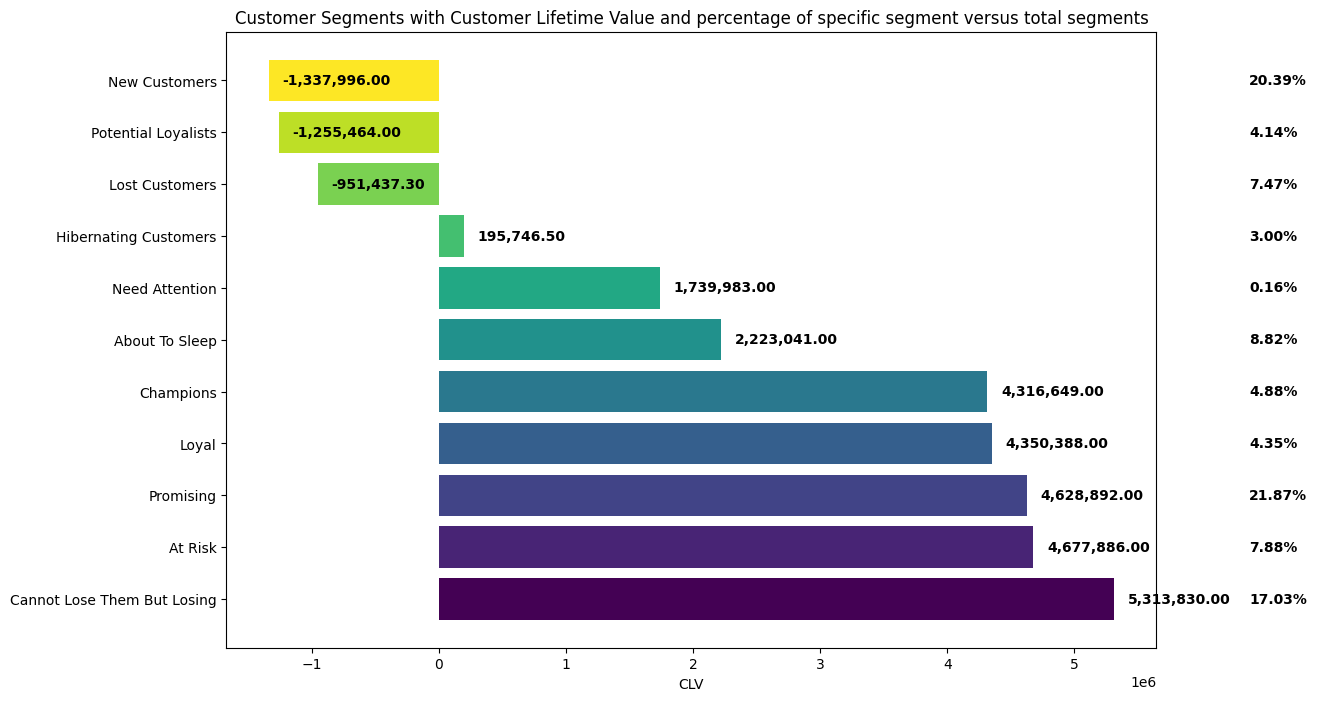

In [111]:
segments = df_segment_clv['Segment']
clv_values = df_segment_clv['CLV']
percent_values = df_segment_clv['Percent_Segment']


sorted_indices = clv_values.argsort()[::-1]
segments = segments.iloc[sorted_indices]
clv_values = clv_values.iloc[sorted_indices]
percent_values = percent_values.iloc[sorted_indices]


fig, ax1 = plt.subplots(figsize=(12, 8))


colors = plt.cm.viridis(np.linspace(0, 1, len(segments)))
bars = ax1.barh(segments, clv_values, color=colors, label='CLV')


for bar, value in zip(bars, clv_values):
    ax1.text(bar.get_width() + max(clv_values) * 0.02, bar.get_y() + bar.get_height()/2, f'{value:,.2f}', color='black', va='center', fontweight='bold')

ax1.set_xlabel('CLV')
ax1.set_title('Customer Segments with Customer Lifetime Value and percentage of specific segment versus total segments')


for i, (seg, perc) in enumerate(zip(segments, percent_values)):
    ax1.text(max(clv_values) * 1.2, i, f'{perc:.2%}', color='black', va='center', fontweight='bold')

plt.show()

* References:
1. <a href="https://www.datacamp.com/tutorial/customer-life-time-value">Customer lifetime value with Python</a>
2. <a href="https://www.datacamp.com/tutorial/introduction-customer-segmentation-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=157156376311&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=680291483907&utm_targetid=dsa-2218886984100&utm_loc_interest_ms=&utm_loc_physical_ms=1028581&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p2_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na-bfcm23&gad_source=1&gclid=Cj0KCQiApOyqBhDlARIsAGfnyMpt_5fxr9iTRY3R4xXWk9sHxmQT4bcYIPd8gmck6kQLy_2qh7bug5IaAm4uEALw_wcB">RFM model with Python</a>
3. <a href="https://documentation.bloomreach.com/engagement/docs/rfm-segmentation">RFM model scoring</a>
4. <a href="https://clevertap.com/blog/customer-lifetime-value/">Customer lifetime value explaination</a>
5. <a href="https://blog.hubspot.com/service/customer-retention-metrics#:~:text=Retention%20rate%20is%20the%20ratio,have%20a%20lower%20retention%20rate.">10 customer retention metrics & How to measure them</a>

In [473]:
data_6.head(2)

_id               customer_id  \
0  5e3bf200f80636dc108b4569  5e3bf1fff80636dc108b4567   
1  5e3cb59cf8063622188b4569  5e3cb59bf8063622188b4567   

                 product_id country_id  s_grand_total  s_discount_money  \
0  6066c157066c9a03055f2b10         VN       345000.0               0.0   
1  6066c157066c9a03055f2b10         VN       697500.0               0.0   

   s_commission              to_user_date              create_info_created  \
0       63000.0 2020-02-07 04:00:00+00:00 2020-02-06 11:01:19.401000+00:00   
1      136500.0 2020-02-07 05:00:00+00:00 2020-02-07 00:55:55.123000+00:00   

   s_profit  ...  MonetaryValue  R_Quartile  F_Quartile  M_Quartile  \
0   63000.0  ...        63000.0           1           1           3   
1  136500.0  ...       392500.0           2           5           5   

   RFM_Segment  RFM_Score                      Segment  avg_order_value  \
0          113          5  Cannot Lose Them But Losing     63000.000000   
1          255         12                      At Risk    130833.333333   

  profit_margin            CLV  
0  1.150435e+06  421019.525066  
1  7.681183e+06  874339.489886  

[2 rows x 22 columns]

In [474]:
data_name = 'SR_metric_overview_2022_2023.xlsx'
path = '/Users/thailinhpham/Downloads/Python/hftf/Semrush/' + data_name
xls = pd.ExcelFile(path)
metric_overview = pd.read_excel(xls)
metric_overview = metric_overview.T

In [475]:
metric_overview = metric_overview.reset_index()

In [476]:
metric_overview.columns = metric_overview.iloc[0]
metric_overview = metric_overview.iloc[1:].reset_index(drop=True)
metric_overview

0  MetricOvertime Organic Traffic Organic Keywords Organic Traffic Cost  \
0         2022-01               0                0                    0   
1         2022-02               0                1                    0   
2         2022-03               0                1                    0   
3         2022-04               2               16                    0   
4         2022-05               1               37                    0   
5         2022-06              34              150                    1   
6         2022-07            3197             1041                  395   
7         2022-08            2587             2951                  201   
8         2022-09            2486             2725                  180   
9         2022-10            3207             3497                  152   
10        2022-11            5910             4829                  291   
11        2022-12            7235             4807                  451   
12        2023-01            8750             5506                 1862   
13        2023-02            7706             4894                 2116   
14        2023-03            6170             4678                 1235   
15        2023-04            1178             2039                  173   
16        2023-05            1715             2965                   89   
17        2023-06            1884             2339                  129   
18        2023-07            1904             2772                  148   
19        2023-08            1907             3449                  192   
20        2023-09            3154             5078                  992   
21        2023-10           10257             6626                 1509   
22        2023-11            3271             5980                  241   

0  Paid Traffic Paid Keywords Paid Traffic Cost  
0             0             0                 0  
1             0             0                 0  
2             0             0                 0  
3             0             0                 0  
4             0             0                 0  
5             0             0                 0  
6             0             0                 0  
7             0             0                 0  
8             0             0                 0  
9             0             0                 0  
10            6             2                 0  
11            0             0                 0  
12          159             2                25  
13           23             4                 8  
14            0             0                 0  
15            2             1                 0  
16            0             0                 0  
17            0             0                 0  
18            0             0                 0  
19          111             5                 0  
20            2             1                 0  
21          369            12                18  
22           37             7                 7

In [477]:
metric_overview["MetricOvertime"] = pd.to_datetime(metric_overview["MetricOvertime"])

In [478]:
metric_overview.head(1)

0 MetricOvertime Organic Traffic Organic Keywords Organic Traffic Cost  \
0     2022-01-01               0                0                    0   

0 Paid Traffic Paid Keywords Paid Traffic Cost  
0            0             0                 0

In [479]:
data_name = 'trafficchannelalldev.csv'
path = '/Users/thailinhpham/Downloads/Python/hftf/Semrush/' + data_name
traffic_channel_all_dev = pd.read_csv(path)
traffic_channel_all_dev

Unnamed: 0  Direct  Referral  Organic Search  Paid Search  Organic Social  \
0   May 2023    4924       404            3592            0               0   
1   Jun 2023   14306      2693             636         1570               0   
2   Jul 2023     487         0               0            0               0   
3   Aug 2023   19883       468             468          936               0   
4   Sep 2023       0      1066               0            0               0   
5   Oct 2023   70866       439            3611          439               0   
6   Nov 2023    5632       870             205          289               0   

   Paid Social  Email  Display Ads  
0            0      0            0  
1            0      0            0  
2            0      0            0  
3            0      0            0  
4         1066      0            0  
5            0      0            0  
6          641      0            0

In [480]:
data_name = 'Device_Bounce Rate_All devices.csv'
path = '/Users/thailinhpham/Downloads/Python/hftf/Semrush/' + data_name
bounce_rate_all_dev = pd.read_csv(path)
bounce_rate_all_dev

Unnamed: 0 All Devices Desktop  Mobile
0   May 2023      52.75%  53.57%     50%
1   Jun 2023      33.84%   55.9%   25.9%
2   Jul 2023          0%      0%      0%
3   Aug 2023      89.24%  74.55%    100%
4   Sep 2023         50%     50%      0%
5   Oct 2023      36.48%  30.85%  36.83%
6   Nov 2023      53.97%  51.31%  26.13%

In [481]:
data_name = 'Page_visited_all_devices.csv'
path = '/Users/thailinhpham/Downloads/Python/hftf/Semrush/' + data_name
page_visited_all_dev = pd.read_csv(path)
page_visited_all_dev

Unnamed: 0  All Devices   Desktop     Mobile
0   May 2023      2.86650  3.275300   1.500000
1   Jun 2023     10.33220  4.749000  12.342300
2   Jul 2023      3.00000  3.000000        NaN
3   Aug 2023      2.48430  4.512700   1.000000
4   Sep 2023      2.50000  2.500000        NaN
5   Oct 2023     11.97620  5.754700  12.370300
6   Nov 2023      2.88161  3.144323   0.783427

# Round 2

## Table of Content
1. Data exploration
2. New users -> buyers, buyers -> rebuyers
3. Cohort analysis - retention rate | PrefixSpan | Survival analysis per year (2022, 2023)
4. Churn rate & Churn rate prediction

* Note: due to lack of time, we are not able to explain concretely in detail for each line of code. Generally, those performances could be cited as our working process. 

### 1. Data exploration

In [482]:
data_original = pd.read_csv("data_bills_with_segments.csv")

In [483]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3704 non-null   int64  
 1   _id                  3704 non-null   object 
 2   customer_id          3704 non-null   object 
 3   product_id           3704 non-null   object 
 4   country_id           3704 non-null   object 
 5   s_grand_total        3704 non-null   float64
 6   s_discount_money     3704 non-null   float64
 7   s_commission         3704 non-null   float64
 8   to_user_date         3704 non-null   object 
 9   create_info_created  3704 non-null   object 
 10  s_profit             3704 non-null   float64
 11  Recency              3704 non-null   int64  
 12  Frequency            3704 non-null   int64  
 13  MonetaryValue        3704 non-null   float64
 14  R_Quartile           3704 non-null   int64  
 15  F_Quartile           3704 non-null   i

In [484]:
data_original['create_info_created'] = pd.to_datetime(data_original['create_info_created'], errors='coerce', utc=True)
data_original['to_user_date'] = pd.to_datetime(data_original['to_user_date'], errors='coerce', utc=True)

In [485]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Unnamed: 0           3704 non-null   int64              
 1   _id                  3704 non-null   object             
 2   customer_id          3704 non-null   object             
 3   product_id           3704 non-null   object             
 4   country_id           3704 non-null   object             
 5   s_grand_total        3704 non-null   float64            
 6   s_discount_money     3704 non-null   float64            
 7   s_commission         3704 non-null   float64            
 8   to_user_date         3697 non-null   datetime64[ns, UTC]
 9   create_info_created  2584 non-null   datetime64[ns, UTC]
 10  s_profit             3704 non-null   float64            
 11  Recency              3704 non-null   int64              
 12  Frequency           

In [486]:
data_2022 = data_original[(data_original['create_info_created'] >= '2022-01-01') & (data_original['create_info_created'] < '2022-10-23')]
data_2023 = data_original[(data_original['create_info_created'] >= '2023-01-01') & (data_original['create_info_created'] < '2023-10-23')]

data_2_years = pd.concat([data_2022, data_2023])

In [487]:
import seaborn as sns

def visualize_data(dataframe):
    dataframe['create_info_created'] = pd.to_datetime(dataframe['create_info_created'], errors='coerce', utc=True)
    dataframe['month_year'] = dataframe['create_info_created'].dt.to_period('M')

    revenue_per_month = dataframe.groupby('month_year')['s_grand_total'].sum()
    plt.figure(figsize=(14,7))
    plt.plot(revenue_per_month.index.astype(str), revenue_per_month.values, marker='o')  # Đã thêm marker
    plt.title('Monthly Revenue')
    plt.ylabel('Revenue')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    
    # Thêm giá trị số trên từng điểm
    for i, revenue in enumerate(revenue_per_month.values):
        plt.text(revenue_per_month.index[i].strftime('%Y-%m'), revenue, f'{revenue:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

    order_counts_per_month = dataframe.groupby('month_year')['_id'].count()
    plt.figure(figsize=(14,7))
    barplot = sns.barplot(x=order_counts_per_month.index.astype(str), y=order_counts_per_month.values, palette="vlag")
    plt.axhline(y=order_counts_per_month.mean(), color='r', linestyle='--', label='Average line')
    plt.title('Monthly Order Count')
    plt.ylabel('Number of Orders')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Thêm số lượng trên từng cột và số liệu cho đường trung bình
    for index, value in enumerate(order_counts_per_month.values):
        plt.text(index, value, f'{value:.0f}', color='black', ha='center', va='bottom')

    # Bổ sung code tại đây để hiển thị điểm số trên đường trung bình
    avg_value = order_counts_per_month.mean()
    plt.text(len(order_counts_per_month.values)-1, avg_value, f'Avg: {avg_value:.2f}', color='b', ha='right', va='center')

    plt.tight_layout()
    plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['create_info_created'] = pd.to_datetime(dataframe['create_info_created'], errors='coerce', utc=True)
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataframe['month_year'] = dataframe['create_info_created'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

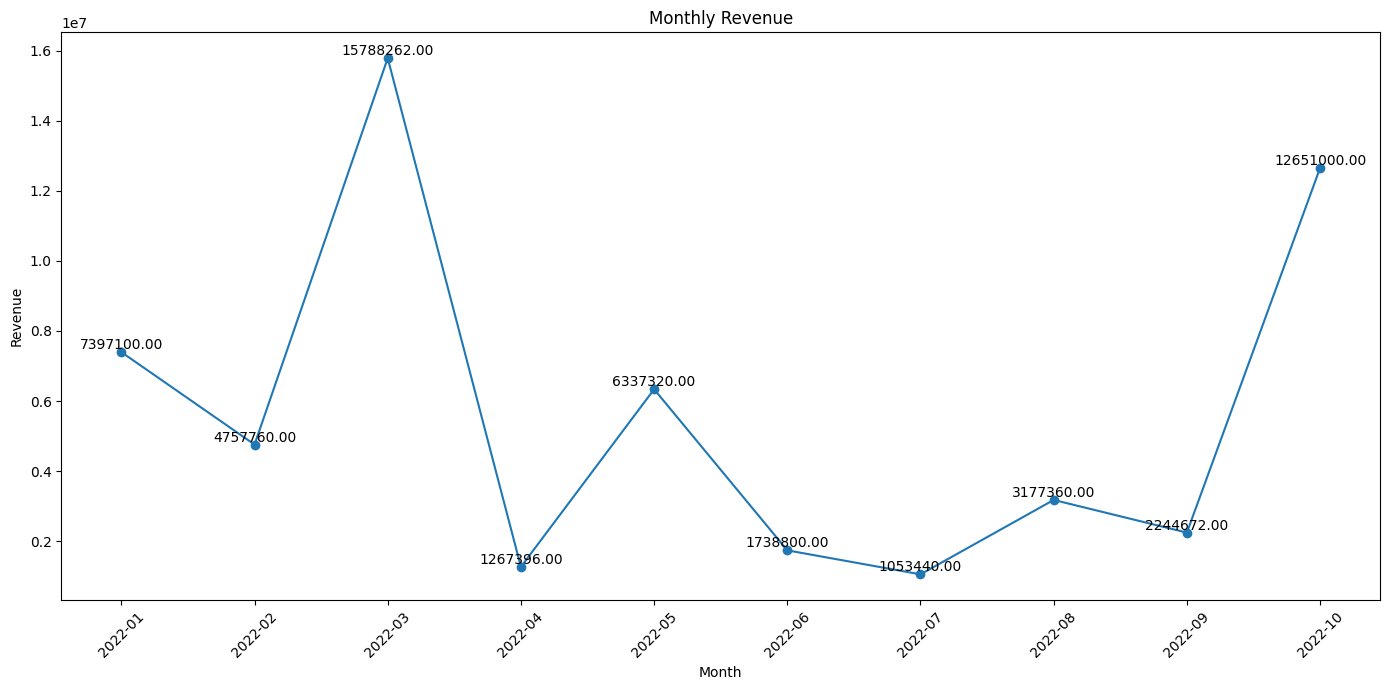

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=order_counts_per_month.index.astype(str), y=order_counts_per_month.values, palette="vlag")


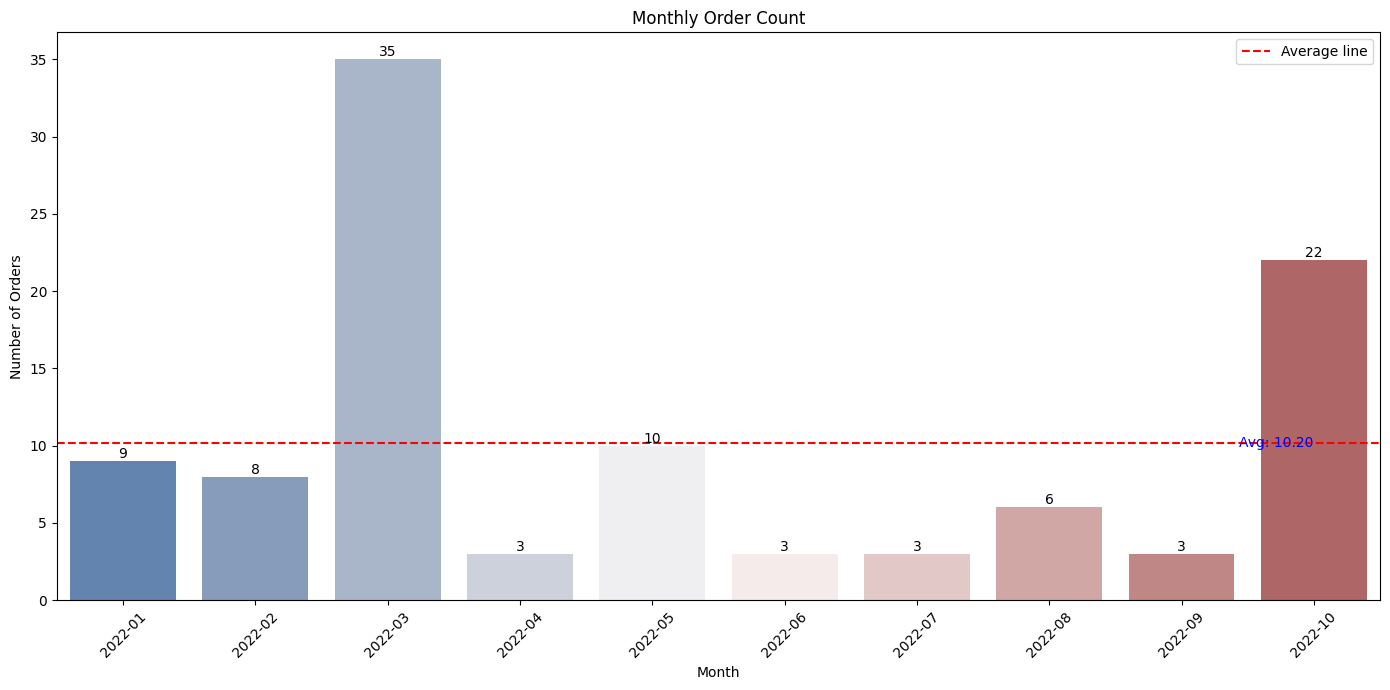

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['create_info_created'] = pd.to_datetime(dataframe['create_info_created'], errors='coerce', utc=True)
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dataframe['month_year'] = dataframe['create_info_created'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

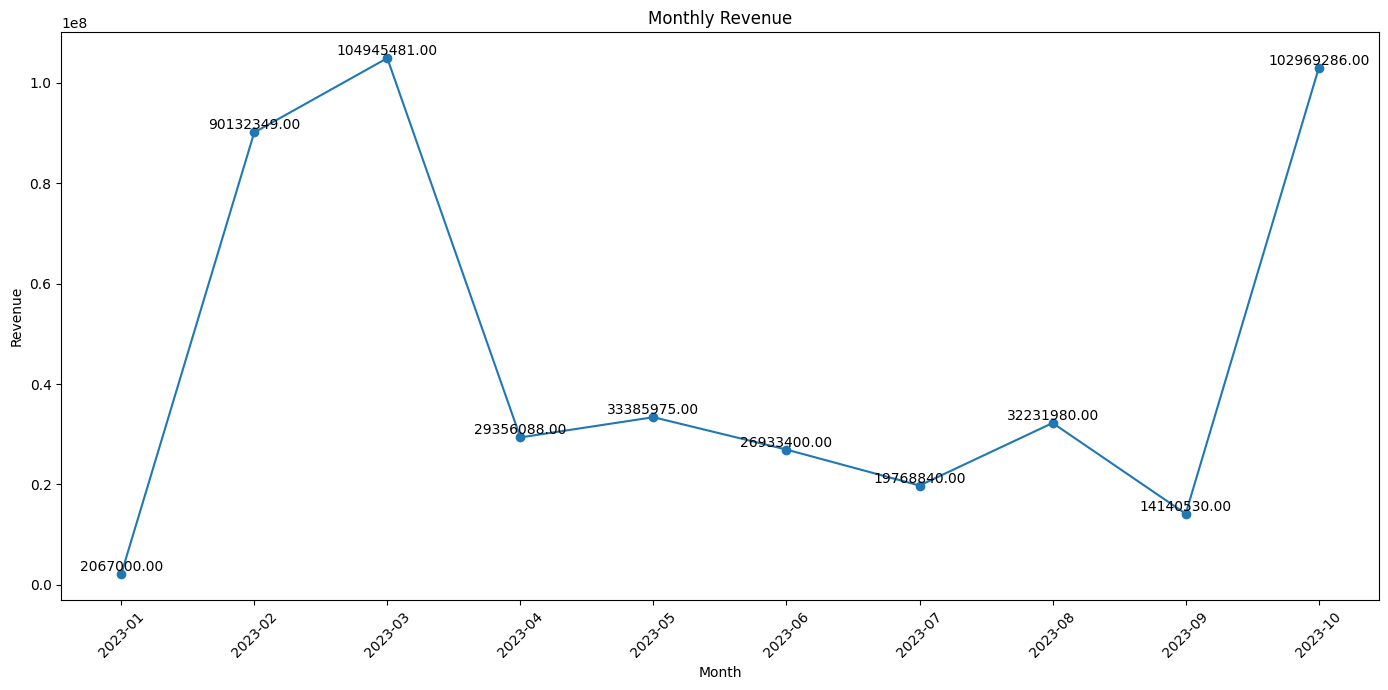

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/773080175.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=order_counts_per_month.index.astype(str), y=order_counts_per_month.values, palette="vlag")


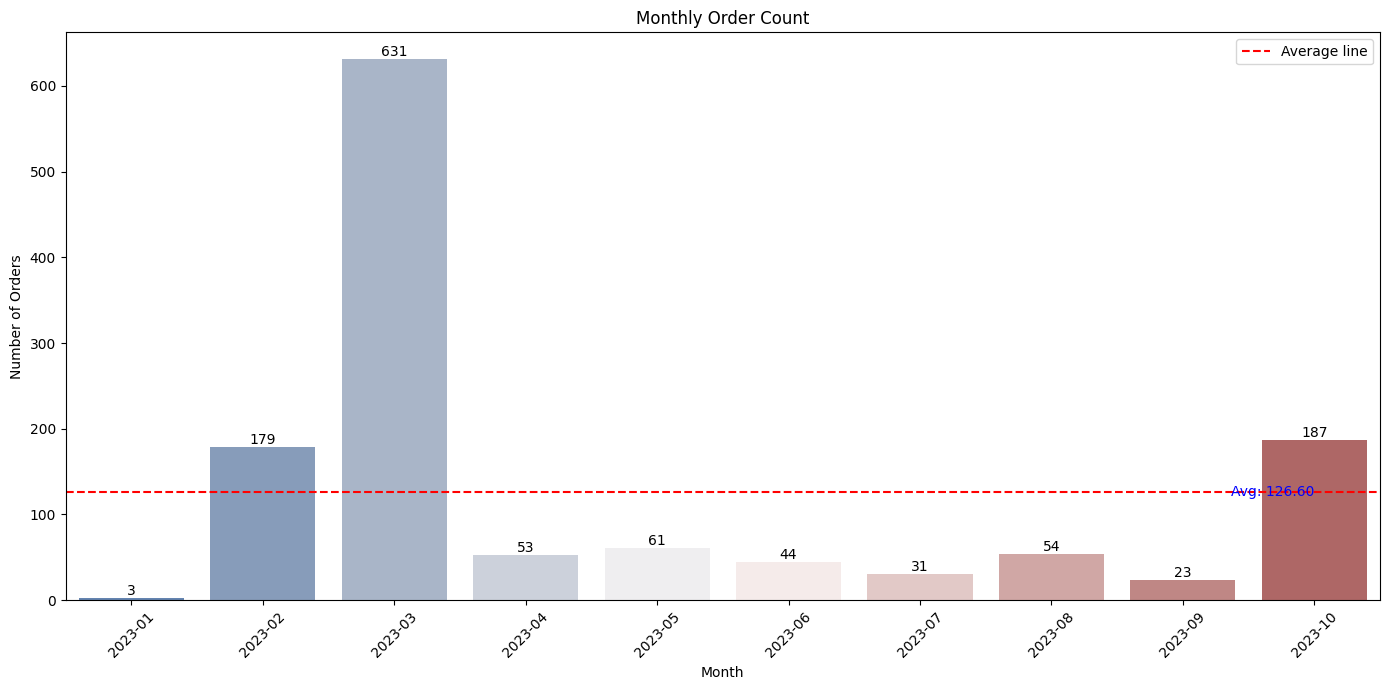

In [488]:
visualize_data(data_2022)
visualize_data(data_2023)

#### DA 1a

In [489]:
data_2022

Unnamed: 0                       _id               customer_id  \
462          462  62ba73b32c7493ecbe043851  5eb232629d9b3572458b456b   
463          463  62ba73b32c7493ecbe043853  5eb232629d9b3572458b456b   
779          779  630495f37c9b00e9e50b8770  5da687c79d9b3504088b4568   
785          785  6322b77e36cb9f758400a7ee  5da687c79d9b3504088b4568   
830          830  622217f17b6fd26acb0d1237  5e6210a2f80636ac4f8b4567   
...          ...                       ...                       ...   
2274        2274  6350b09df11261fea5061bca  6226e9049aa1664d8a353dc5   
2276        2276  6350cade0b780ac33000fc71  6350a53391b963751d07a2f5   
2278        2278  6350ded6866a067bc509636d  634eaeb917a482a13b016ab3   
2279        2279  6350e173b4b818fce60078a2  6350d213860aef43590ecb0a   
2292        2292  63514a2a9230bb72d8058fb6  6351460c3d883121240f8192   

                    product_id country_id  s_grand_total  s_discount_money  \
462   6066c157066c9a03055f2b10         VN       486000.0               0.0   
463   6066cd65ca52cc506817d471         VN       442800.0               0.0   
779   6066cd65ca52cc506817d471         VN       432000.0               0.0   
785   6066cdb37c6e026dce0e3b31         VN       810000.0               0.0   
830   6066ce023a550774f46d43e3         VN       469600.0               0.0   
...                        ...        ...            ...               ...   
2274  6066c157066c9a03055f2b10         VN       484920.0          100000.0   
2276  6066cdb37c6e026dce0e3b31         VN       259200.0           50000.0   
2278  6066c157066c9a03055f2b10         VN       685800.0               0.0   
2279  6066c157066c9a03055f2b10         VN       429300.0               0.0   
2292  6066c157066c9a03055f2b10         VN       486000.0               0.0   

      s_commission              to_user_date              create_info_created  \
462        96000.0 2022-06-30 01:00:00+00:00 2022-06-28 03:21:22.978000+00:00   
463        80800.0 2022-06-30 03:00:00+00:00 2022-06-28 03:21:22.978000+00:00   
779        71300.0 2022-08-29 01:00:00+00:00 2022-08-23 08:55:15.289000+00:00   
785       156000.0 2022-09-15 03:00:00+00:00 2022-09-15 05:25:52.662000+00:00   
830        42350.0 2022-03-08 01:00:00+00:00 2022-03-04 13:45:21.230000+00:00   
...            ...                       ...                              ...   
2274       39720.0 2022-10-20 05:00:00+00:00 2022-10-20 02:21:16.696000+00:00   
2276       19200.0 2022-10-20 09:00:00+00:00 2022-10-20 04:13:18.193000+00:00   
2278      138550.0 2022-10-20 09:00:00+00:00 2022-10-20 05:38:29.865000+00:00   
2279      129300.0 2022-10-20 07:49:00+00:00 2022-10-20 05:49:39.486000+00:00   
2292      114000.0 2022-10-21 01:00:00+00:00 2022-10-20 13:16:26.446000+00:00   

      ...  R_Quartile  F_Quartile  M_Quartile  RFM_Segment  RFM_Score  \
462   ...           3           5           5          355         13   
463   ...           3           5           5          355         13   
779   ...           3           5           5          355         13   
785   ...           3           5           5          355         13   
830   ...           3           5           5          355         13   
...   ...         ...         ...         ...          ...        ...   
2274  ...           3           1           2          312          6   
2276  ...           3           1           2          312          6   
2278  ...           3           1           4          314          8   
2279  ...           3           1           4          314          8   
2292  ...           3           1           4          314          8   

             Segment  avg_order_value  profit_margin           CLV month_year  
462            Loyal    165508.500000   3.269304e+07  1.106068e+06    2022-06  
463            Loyal    165508.500000   3.020119e+07  1.106068e+06    2022-06  
779            Loyal     54556.000000   3.421621e+07  3.645895e+05    2022-08  
785            Loyal     54556.000

In [490]:
data_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    28 non-null     object
 1   product_name  28 non-null     object
dtypes: object(2)
memory usage: 580.0+ bytes


In [491]:
def plot_product_revenue_contribution(data_year, products_df, year):
    # Gộp dữ liệu sản phẩm với doanh thu để lấy tên sản phẩm
    revenue_product = data_year.merge(products_df, left_on='product_id', right_on='product_id')
    
    # Tính tổng doanh thu theo sản phẩm
    revenue_by_product = revenue_product.groupby('product_name')['s_grand_total'].sum()

    # Xác định tỷ lệ % doanh thu cho mỗi sản phẩm
    product_revenue_percentage = revenue_by_product / revenue_by_product.sum() * 100

    # Vẽ pie chart
    product_revenue_percentage.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
    plt.title(f'Product Revenue Contribution in {year}')
    plt.ylabel('')  # Pie chart không cần nhãn y
    plt.show()

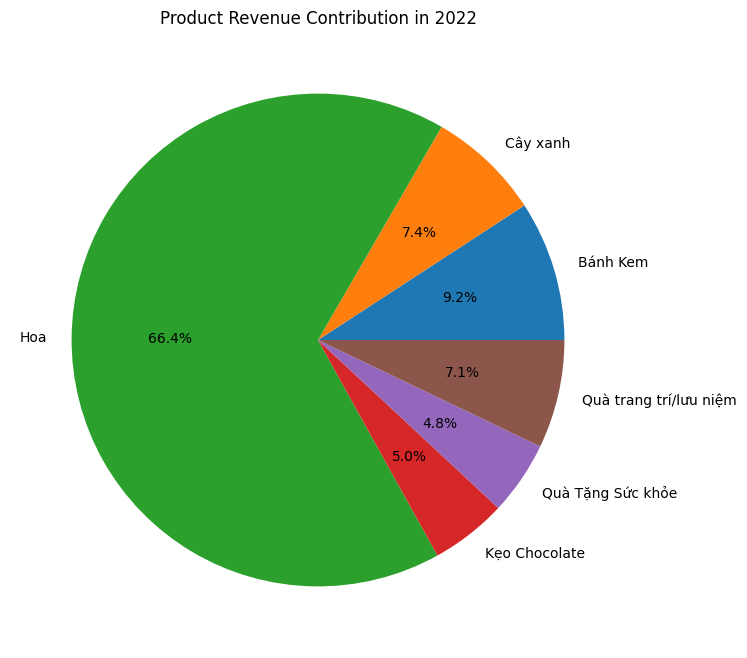

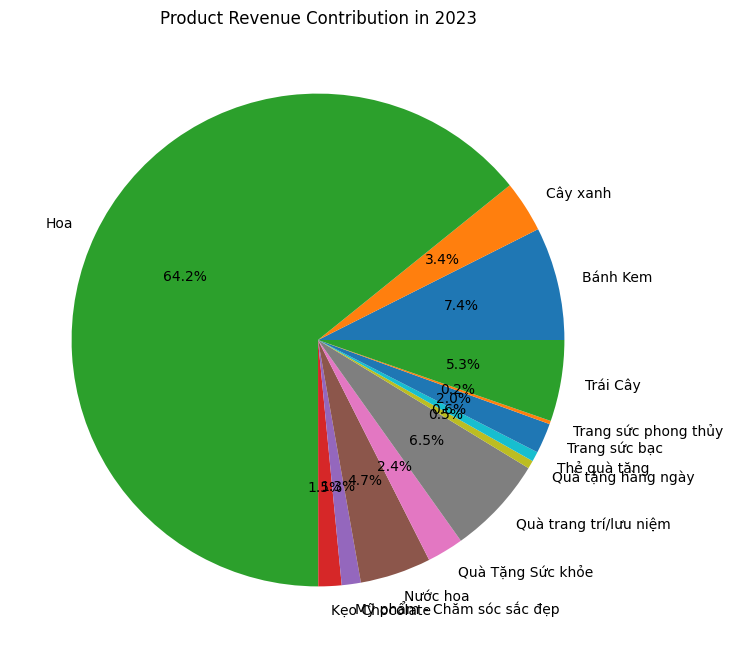

In [492]:
plot_product_revenue_contribution(data_2022, data_products, 2022)
plot_product_revenue_contribution(data_2023, data_products, 2023)

In [493]:
revenue_by_product_2022 = data_2022.groupby('product_id')['s_grand_total'].sum()
total_revenue_2022 = revenue_by_product_2022.sum()
percentage_by_product_2022 = (revenue_by_product_2022 / total_revenue_2022) * 100

revenue_by_product_2023 = data_2023.groupby('product_id')['s_grand_total'].sum()
total_revenue_2023 = revenue_by_product_2023.sum()
percentage_by_product_2023 = (revenue_by_product_2023 / total_revenue_2023) * 100

percentages_2022_with_names = pd.merge(percentage_by_product_2022.reset_index(), data_products, on='product_id')
percentages_2023_with_names = pd.merge(percentage_by_product_2023.reset_index(), data_products, on='product_id')

print(f'Phần trăm doanh thu từng sản phẩm cho năm 2022:')
print(percentages_2022_with_names.set_index('product_name')['s_grand_total'])

print(f'\nPhần trăm doanh thu từng sản phẩm cho năm 2023:')
print(percentages_2023_with_names.set_index('product_name')['s_grand_total'])

Phần trăm doanh thu từng sản phẩm cho năm 2022:
product_name
Hoa                       66.422528
Bánh Kem                   9.195309
Cây xanh                   7.437200
Kẹo Chocolate              5.004510
Quà Tặng Sức khỏe          4.831324
Quà trang trí/lưu niệm     7.109128
Name: s_grand_total, dtype: float64

Phần trăm doanh thu từng sản phẩm cho năm 2023:
product_name
Hoa                           63.654959
Bánh Kem                       7.360246
Cây xanh                       3.350051
Kẹo Chocolate                  1.504688
Nước hoa                       4.619405
Quà Tặng Sức khỏe              2.374969
Quà trang trí/lưu niệm         6.396994
Thẻ quà tặng                   0.642203
Trái Cây                       5.280910
Trang sức bạc                  1.964991
Mỹ phẩm - Chăm sóc sắc đẹp     1.241153
Trang sức phong thủy           0.215559
Quà tặng hàng ngày             0.523785
Name: s_grand_total, dtype: float64


In [494]:
def visualize_holiday_revenue(dataframe):
    # Chuyển đổi cột 'to_user_date' sang định dạng datetime và lấy ngày
    dataframe['to_user_date'] = pd.to_datetime(dataframe['to_user_date'], errors='coerce')
    dataframe = dataframe.dropna(subset=['to_user_date'])
    dataframe['date'] = dataframe['to_user_date'].dt.date
    
    # Mở rộng danh sách các ngày lễ để bao gồm ngày trước và sau
    holidays = ['02-14', '03-08', '10-20', '02-13', '02-12', '03-07', '03-06', '10-19', '10-18']
    
    # Lọc dữ liệu cho những ngày lễ và tính doanh thu cho mỗi ngày
    dataframe['month_day'] = dataframe['to_user_date'].dt.strftime('%m-%d')
    holiday_revenue = dataframe[dataframe['month_day'].isin(holidays)].groupby('date')['s_grand_total'].sum()

    # Tính doanh thu trung bình hàng năm
    average_annual_revenue = dataframe['s_grand_total'].sum() / len(dataframe['date'].unique())

    plt.figure(figsize=(10,5))

    # Vẽ biểu đồ dạng đường cho doanh thu hàng ngày trong các ngày lễ
    plt.plot(holiday_revenue.index, holiday_revenue.values, marker='o', label='Holiday Revenue')
    
    # Vẽ text cho doanh thu của từng ngày lễ trên đồ thị
    for date, revenue in holiday_revenue.items():
        plt.text(date, revenue, f'{date.month}-{date.day}: {revenue}', color='blue', ha='center', va='bottom')
    
    # Vẽ đường trung bình doanh thu hàng năm
    plt.axhline(y=average_annual_revenue, color='r', linestyle='-', linewidth=2, label='Average Annual Revenue')

    # Vẽ text cho đường trung bình bên trên đường
    plt.text(dataframe['date'].max(), average_annual_revenue, 
             f'Average revenue: {average_annual_revenue:.2f}', color='r', ha='right', va='bottom')

    years = dataframe['to_user_date'].dt.year.unique()
    plt.title(f'Holiday Revenue Based on Delivery Date ({years.max()})')
    plt.ylabel('Revenue')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/2661609788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['to_user_date'] = pd.to_datetime(dataframe['to_user_date'], errors='coerce')


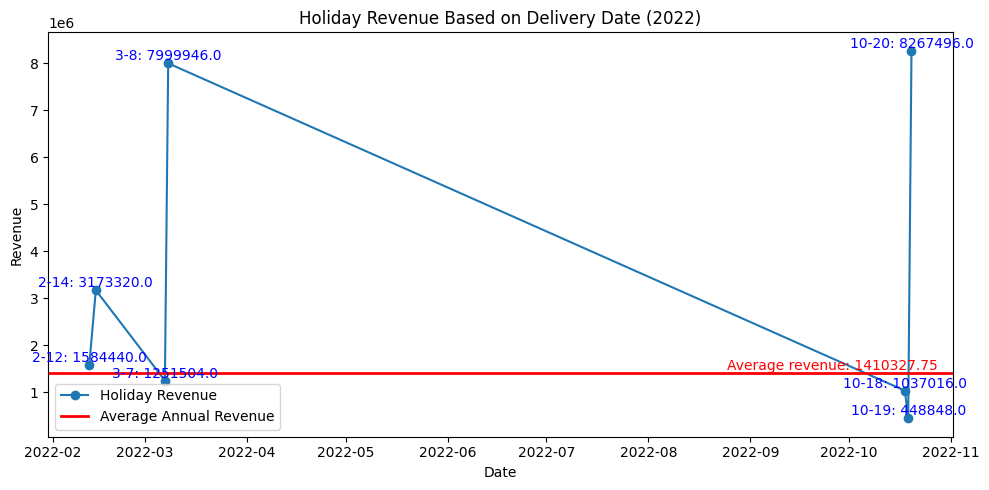

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/2661609788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['to_user_date'] = pd.to_datetime(dataframe['to_user_date'], errors='coerce')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/2661609788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = dataframe['to_user_date'].dt.date
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/2661609788.py:11: SettingWithCopyWarning: 
A value

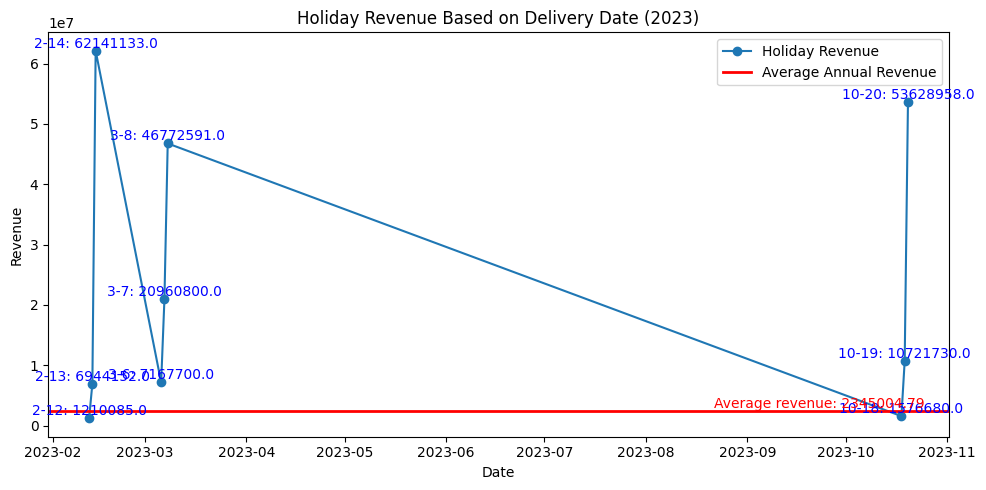

In [495]:
visualize_holiday_revenue(data_2022)
visualize_holiday_revenue(data_2023)

In [496]:
def calculate_top_products_and_percentage(dataframe, holidays, year, data_products):
    # Lọc ra dữ liệu cho năm cụ thể và trong các ngày lễ
    holiday_sales = dataframe[(dataframe['to_user_date'].dt.year == year) & 
                              (dataframe['to_user_date'].dt.strftime('%m-%d').isin(holidays))]
    
    # Tính doanh thu theo sản phẩm trong các ngày lễ
    holiday_product_sales = holiday_sales.groupby(['product_id', 
                                                   holiday_sales['to_user_date'].dt.date])['s_grand_total'].sum().reset_index(name='sales')
    
    # Lấy top 3 doanh thu sản phẩm cụ thể cho mỗi ngày
    top_product_sales_by_day = holiday_product_sales.sort_values(by=['to_user_date', 'sales'], ascending=[True, False])
    top_product_sales_by_day = top_product_sales_by_day.groupby('to_user_date').head(3)

    # Merge để lấy tên sản phẩm từ bảng product
    top_product_info = pd.merge(top_product_sales_by_day, data_products, on='product_id')

    # Tính tổng doanh thu của cả năm cho mỗi sản phẩm
    annual_sales_by_product = dataframe.groupby('product_id')['s_grand_total'].sum().reset_index(name='annual_sales')
    
    # Merge để lấy tổng doanh thu của cả năm cho mỗi sản phẩm
    top_product_info = pd.merge(top_product_info, annual_sales_by_product, on='product_id')

    # Tính phần trăm doanh thu của các sản phẩm top trong các ngày lễ so với cả năm
    top_product_info['percentage_of_annual_sales'] = (top_product_info['sales'] / top_product_info['annual_sales']) * 100

    # Thêm cột to_user_date từ top_product_sales_by_day
    top_product_info = top_product_info.rename(columns={"to_user_date": "specific_day", 
                                                        "sales": "holiday_sales"})

    return top_product_info

holidays = ['02-14', '03-08', '10-20', '02-13', '02-12', '03-07', '03-06', '10-19', '10-18']

# Dùng hàm cho năm 2022 và 2023
top_products_2022 = calculate_top_products_and_percentage(data_2022, holidays, 2022, data_products)
top_products_2023 = calculate_top_products_and_percentage(data_2023, holidays, 2023, data_products)

print(top_products_2022)
print('\n')
print(top_products_2023)

                  product_id specific_day  holiday_sales  \
0   6066c157066c9a03055f2b10   2022-02-12      1584440.0   
1   6066c157066c9a03055f2b10   2022-02-14      1786220.0   
2   6066c157066c9a03055f2b10   2022-03-07      1251504.0   
3   6066c157066c9a03055f2b10   2022-03-08      4311770.0   
4   6066c157066c9a03055f2b10   2022-10-18      1037016.0   
5   6066c157066c9a03055f2b10   2022-10-20      7520136.0   
6   6066ce023a550774f46d43e3   2022-02-14       631400.0   
7   6066ce023a550774f46d43e3   2022-03-08      1498200.0   
8   6066cd65ca52cc506817d471   2022-02-14       420200.0   
9   6066cd65ca52cc506817d471   2022-10-20       488160.0   
10  60c039663273bc0f1c215081   2022-03-08      1629240.0   
11  60c039663273bc0f1c215081   2022-10-19       448848.0   
12  6066cdb37c6e026dce0e3b31   2022-10-20       259200.0   

              product_name  annual_sales  percentage_of_annual_sales  
0                      Hoa    37471014.0                    4.228442  
1                

In [497]:
data_2_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1368 entries, 462 to 3697
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Unnamed: 0           1368 non-null   int64              
 1   _id                  1368 non-null   object             
 2   customer_id          1368 non-null   object             
 3   product_id           1368 non-null   object             
 4   country_id           1368 non-null   object             
 5   s_grand_total        1368 non-null   float64            
 6   s_discount_money     1368 non-null   float64            
 7   s_commission         1368 non-null   float64            
 8   to_user_date         1367 non-null   datetime64[ns, UTC]
 9   create_info_created  1368 non-null   datetime64[ns, UTC]
 10  s_profit             1368 non-null   float64            
 11  Recency              1368 non-null   int64              
 12  Frequency            13

Churn rate là tỷ lệ khách hàng ngừng sử dụng dịch vụ hoặc sản phẩm của bạn trong một khoảng thời gian cụ thể. Để tính churn rate, chúng ta cần thông tin về số lượng khách hàng tại đầu kỳ, cũng như số lượng khách hàng đã chấm dứt sử dụng dịch vụ tại cuối kỳ.

Dựa vào dữ liệu bạn cung cấp, không rõ có đủ thông tin để tính churn rate một cách chính xác hay không vì không có cụ thể dữ liệu về khách hàng qua các kỳ. Tuy nhiên, nếu bạn có dữ liệu theo dõi khách hàng theo thời gian, bạn có thể ước tính tỷ lệ churn.

Cần chú ý đến các cột sau:
- `create_info_created`: Ngày khách hàng tạo đơn hàng, có thể giúp xác định những khách hàng không còn hoạt động.
- `customer_id`: Để nhóm dữ liệu theo từng khách hàng.

Quy trình tính toán có thể như sau:

1. Xác định khoảng thời gian bạn muốn tính churn (ví dụ: mỗi quý hoặc mỗi năm).
2. Tính tổng số khách hàng ở đầu kỳ (khách hàng có ít nhất một hành động/đơn hàng trong khoảng thời gian trước khoảng thời gian bạn đang xem xét).
3. Xác định số khách hàng không còn tiếp tục mua sắm tại cuối kỳ (khách hàng không có hành động/đơn hàng nào trong khoảng thời gian bạn đang xem xét).

Tỷ lệ churn có thể được tính bằng công thức:

\[ \text{Churn Rate} = \left( \frac{\text{Số lượng khách hàng đã chấm dứt}}{\text{Tổng số khách hàng ở đầu kỳ}} \right) \times 100 \]

Chú ý:
- Để tính chính xác churn, bạn cần định nghĩa rõ "chấm dứt" trong bối cảnh doanh nghiệp của bạn là gì.
- Đôi khi việc để xác định một khách hàng có phải là 'churn' hay không cần phải được kết hợp với những chiến lược phân tích khác hoặc dữ liệu ngoài như khảo sát của khách hàng sau khi họ không còn mua sắm.

### match with GA

In [539]:
data_name = 'GA_new_users_2022.xlsx'
path = '/Users/thailinhpham/Downloads/Python/hftf/Google Analytics/' + data_name
xls = pd.ExcelFile(path)
GA_2022 = pd.read_excel(xls)
GA_2022

Day Index  Users
0   2022-01-01   1116
1   2022-01-02    773
2   2022-01-03    842
3   2022-01-04    819
4   2022-01-05   1089
..         ...    ...
291 2022-10-19   2951
292 2022-10-20   2536
293 2022-10-21    558
294 2022-10-22    770
295 2022-10-23    504

[296 rows x 2 columns]

In [536]:
data_name = 'GA_new_users_2023.xlsx'
path = '/Users/thailinhpham/Downloads/Python/hftf/Google Analytics/' + data_name
xls = pd.ExcelFile(path)
GA_2023 = pd.read_excel(xls)
GA_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Day Index  296 non-null    datetime64[ns]
 1   Users      296 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 KB


In [540]:
import pandas as pd

data_2022_for_GA = data_2022.groupby(data_2022['create_info_created'].dt.to_period('M'))['_id'].count().reset_index()
data_2022_for_GA.columns = ['Month_Year', 'Total_User_Buy']

data_2023_for_GA = data_2023.groupby(data_2023['create_info_created'].dt.to_period('M'))['_id'].count().reset_index()
data_2023_for_GA.columns = ['Month_Year', 'Total_User_Buy']

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/897309742.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_2022_for_GA = data_2022.groupby(data_2022['create_info_created'].dt.to_period('M'))['_id'].count().reset_index()
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/897309742.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_2023_for_GA = data_2023.groupby(data_2023['create_info_created'].dt.to_period('M'))['_id'].count().reset_index()


In [541]:
GA_2022_for_mapping = GA_2022.groupby(GA_2022['Day Index'].dt.to_period('M'))['Users'].sum().reset_index()
GA_2022_for_mapping.columns = ['Month_Year', 'Total_User_Registered']

GA_2023_for_mapping = GA_2023.groupby(GA_2023['Day Index'].dt.to_period('M'))['Users'].sum().reset_index()
GA_2023_for_mapping.columns = ['Month_Year', 'Total_User_Registered']


In [542]:
merged_2022_data = pd.merge(data_2022_for_GA, GA_2022_for_mapping, on='Month_Year', how='left')
merged_2023_data = pd.merge(data_2023_for_GA, GA_2023_for_mapping, on='Month_Year', how='left')


In [545]:
merged_2022_data

Month_Year  Total_User_Buy  Total_User_Registered
0    2022-01               9                  26587
1    2022-02               8                  16573
2    2022-03              35                  20532
3    2022-04               3                  17121
4    2022-05              10                  11518
5    2022-06               3                  68502
6    2022-07               3                  32124
7    2022-08               6                  61822
8    2022-09               3                  44327
9    2022-10              22                  42143

In [589]:
merged_2022_data['Ratio_User_Buy_vs_Registered'] = merged_2022_data['Total_User_Buy'] / (merged_2022_data['Total_User_Registered']) * 100
merged_2022_data

Month_Year  Total_User_Buy  Total_User_Registered  \
0    2022-01               9                  26587   
1    2022-02               8                  16573   
2    2022-03              35                  20532   
3    2022-04               3                  17121   
4    2022-05              10                  11518   
5    2022-06               3                  68502   
6    2022-07               3                  32124   
7    2022-08               6                  61822   
8    2022-09               3                  44327   
9    2022-10              22                  42143   

   Ratio_User_Buy_vs_Registered  
0                      0.033851  
1                      0.048271  
2                      0.170466  
3                      0.017522  
4                      0.086821  
5                      0.004379  
6                      0.009339  
7                      0.009705  
8                      0.006768  
9                      0.052203

### 2. New users -> buyers, buyers -> rebuyers

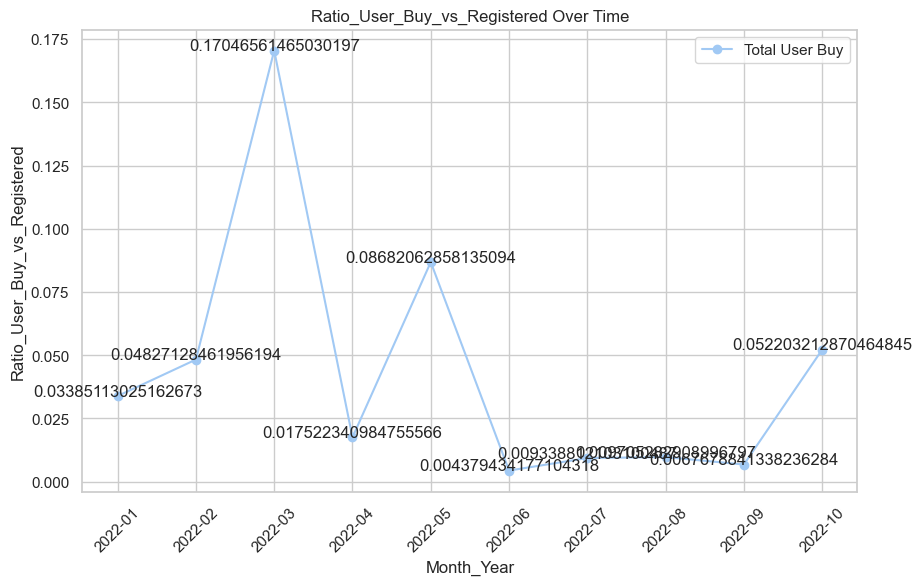

In [590]:
import matplotlib.pyplot as plt

merged_2022_data['Month_Year'] = merged_2022_data['Month_Year'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(merged_2022_data['Month_Year'], merged_2022_data['Ratio_User_Buy_vs_Registered'], marker='o', linestyle='-', label='Total User Buy')

# Adding data labels
for i, txt in enumerate(merged_2022_data['Ratio_User_Buy_vs_Registered']):
    plt.annotate(txt, (merged_2022_data['Month_Year'].iloc[i], merged_2022_data['Ratio_User_Buy_vs_Registered'].iloc[i]), ha='center')

plt.xlabel('Month_Year')
plt.ylabel('Ratio_User_Buy_vs_Registered')
plt.title('Ratio_User_Buy_vs_Registered Over Time')
plt.legend()
plt.xticks(rotation=45)

plt.show()

In [600]:
merged_2023_data['Ratio_User_Buy_vs_Registered'] = merged_2023_data['Total_User_Buy'] / merged_2023_data['Total_User_Registered'] * 100
merged_2023_data

Month_Year  Total_User_Buy  Total_User_Registered  \
0    2023-01               3                  20157   
1    2023-02             179                  33393   
2    2023-03             631                  55627   
3    2023-04              53                  30723   
4    2023-05              61                  24179   
5    2023-06              44                  46644   
6    2023-07              31                  21805   
7    2023-08              54                  24446   
8    2023-09              23                   8937   
9    2023-10             187                 104542   

   Ratio_User_Buy_vs_Registered  
0                      0.014883  
1                      0.536040  
2                      1.134341  
3                      0.172509  
4                      0.252285  
5                      0.094332  
6                      0.142169  
7                      0.220895  
8                      0.257357  
9                      0.178875

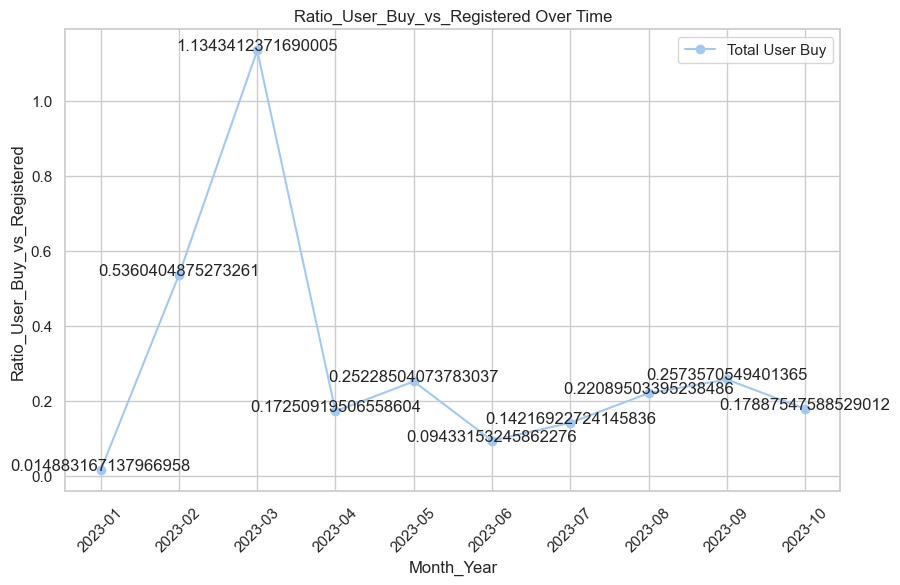

In [601]:
merged_2023_data['Month_Year'] = merged_2023_data['Month_Year'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(merged_2023_data['Month_Year'], merged_2023_data['Ratio_User_Buy_vs_Registered'], marker='o', linestyle='-', label='Total User Buy')

for i, txt in enumerate(merged_2023_data['Ratio_User_Buy_vs_Registered']):
    plt.annotate(txt, (merged_2023_data['Month_Year'].iloc[i], merged_2023_data['Ratio_User_Buy_vs_Registered'].iloc[i]), ha='center')

plt.xlabel('Month_Year')
plt.ylabel('Ratio_User_Buy_vs_Registered')
plt.title('Ratio_User_Buy_vs_Registered Over Time')
plt.legend()
plt.xticks(rotation=45)

plt.show()

In [554]:
data_name = 'GA_Data_Acquisition.xlsx'
path = '/Users/thailinhpham/Downloads/Python/hftf/Google Analytics/' + data_name
xls = pd.ExcelFile(path)
GA_Acquisition_2023 = pd.read_excel(xls)
GA_Acquisition_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Default Channel Grouping                    8 non-null      object 
 1   Users                                       8 non-null      int64  
 2   New Users                                   8 non-null      int64  
 3   Sessions                                    8 non-null      int64  
 4   Bounce Rate                                 8 non-null      float64
 5   Pages / Session                             8 non-null      float64
 6   Avg. Session Duration                       8 non-null      float64
 7   Checkout complete (Goal 1 Conversion Rate)  8 non-null      float64
 8   Checkout complete (Goal 1 Completions)      8 non-null      int64  
 9   Checkout complete (Goal 1 Value)            8 non-null      int64  
dtypes: float64(4), int

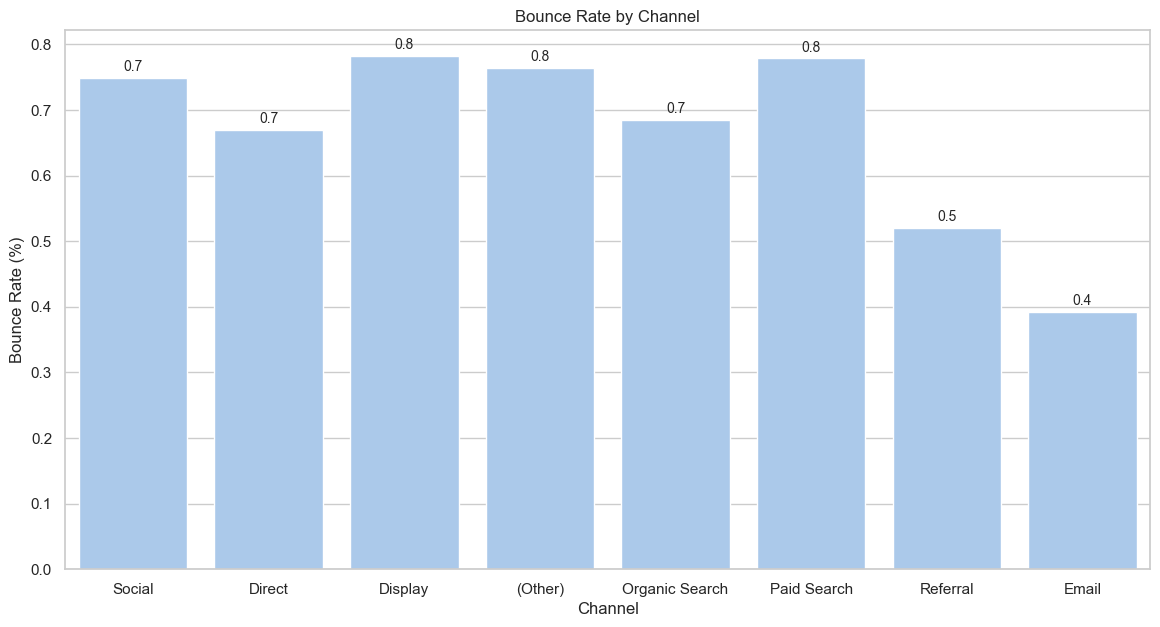

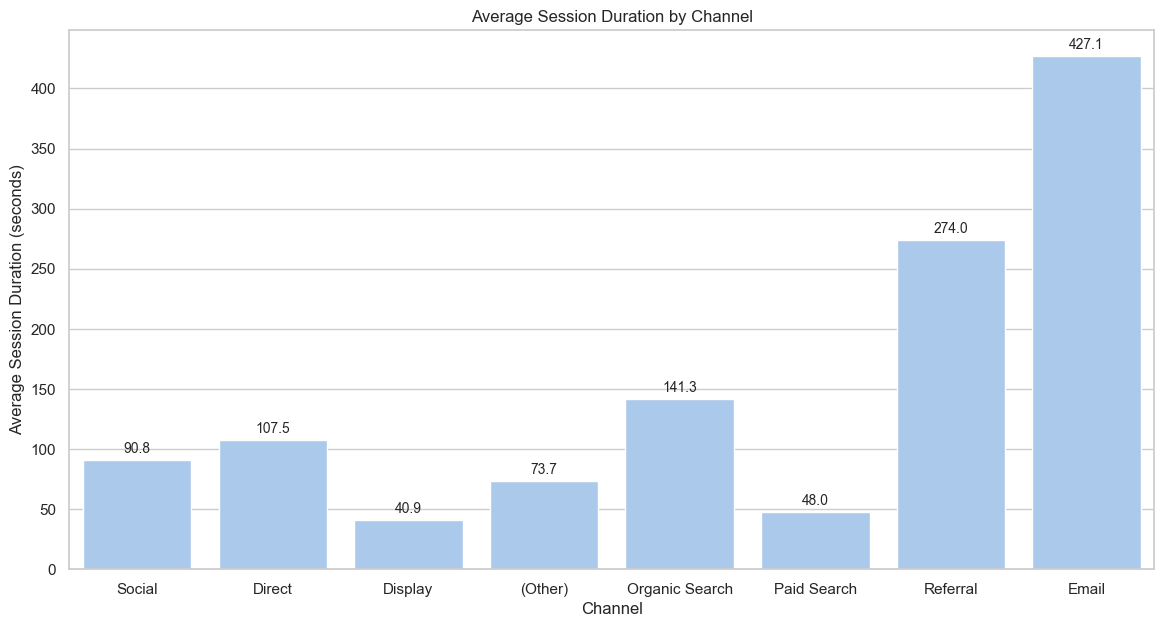

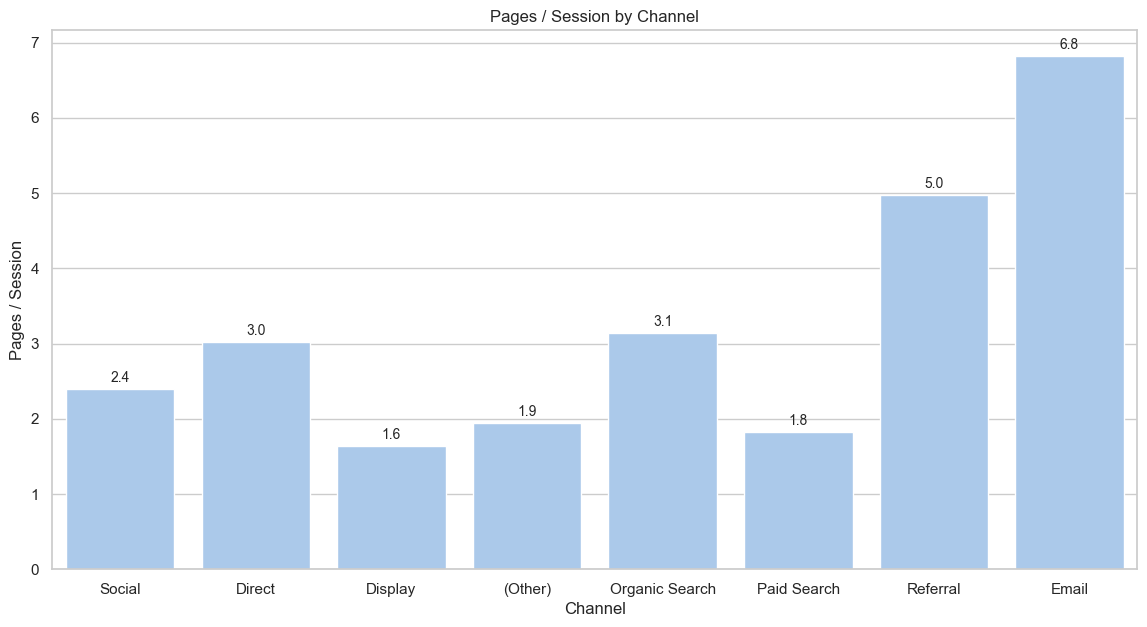

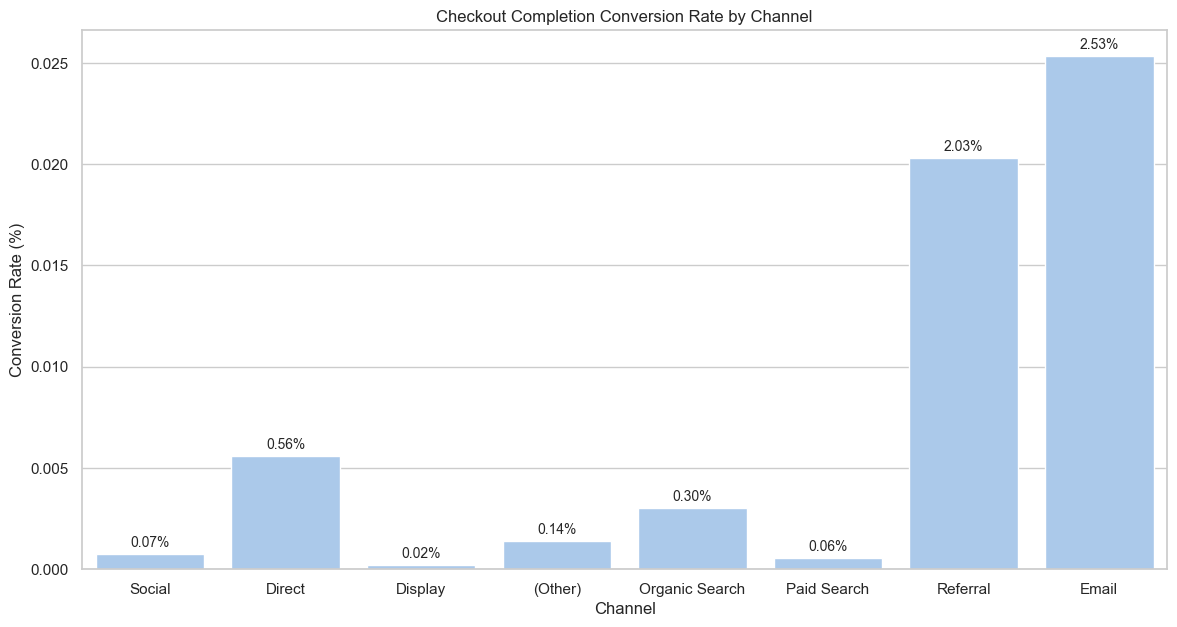

In [558]:
# Set the visual aesthetics for better appeal
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Visualize the Bounce Rate by Channel with colors and annotations
plt.figure(figsize=(14, 7))
bounce_plot = sns.barplot(x='Default Channel Grouping', y='Bounce Rate', data=GA_Acquisition_2023)

for bar in bounce_plot.patches:
    bounce_plot.annotate(format(bar.get_height(), '.1f'), 
                         (bar.get_x() + bar.get_width() / 2, 
                          bar.get_height()), ha='center', va='center',
                         size=10, xytext=(0, 8),
                         textcoords='offset points')

plt.title('Bounce Rate by Channel')
plt.ylabel('Bounce Rate (%)')
plt.xlabel('Channel')
plt.show()

# Visualize the Average Session Duration by Channel with colors and annotations
plt.figure(figsize=(14, 7))
duration_plot = sns.barplot(x='Default Channel Grouping', y='Avg. Session Duration', data=GA_Acquisition_2023)

for bar in duration_plot.patches:
    duration_plot.annotate(format(bar.get_height(), '.1f'), 
                           (bar.get_x() + bar.get_width() / 2, 
                            bar.get_height()), ha='center', va='center',
                           size=10, xytext=(0, 8),
                           textcoords='offset points')

plt.title('Average Session Duration by Channel')
plt.ylabel('Average Session Duration (seconds)')
plt.xlabel('Channel')
plt.show()

# Visualize the Pages per Session by Channel with colors and annotations
plt.figure(figsize=(14, 7))
pages_plot = sns.barplot(x='Default Channel Grouping', y='Pages / Session', data=GA_Acquisition_2023)

for bar in pages_plot.patches:
    pages_plot.annotate(format(bar.get_height(), '.1f'), 
                        (bar.get_x() + bar.get_width() / 2, 
                         bar.get_height()), ha='center', va='center',
                        size=10, xytext=(0, 8),
                        textcoords='offset points')

plt.title('Pages / Session by Channel')
plt.ylabel('Pages / Session')
plt.xlabel('Channel')
plt.show()

# Visualize the Checkout Completion Conversion Rate by Channel with colors and annotations
plt.figure(figsize=(14, 7))
conversion_plot = sns.barplot(x='Default Channel Grouping', y='Checkout complete (Goal 1 Conversion Rate)', data=GA_Acquisition_2023)

for bar in conversion_plot.patches:
    conversion_plot.annotate(format(bar.get_height(), '.2%'), 
                             (bar.get_x() + bar.get_width() / 2, 
                              bar.get_height()), ha='center', va='center',
                             size=10, xytext=(0, 8),
                             textcoords='offset points')

plt.title('Checkout Completion Conversion Rate by Channel')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Channel')
plt.show()


The data provided seems to summarize website traffic and user interaction by channel for a certain period. Here's an analysis of each channel:

### Social
- **High Traffic with Low Engagement**: Despite a high number of users, the session duration is low, and the bounce rate is high, indicating users coming from social media are not staying long or engaging deeply with the content.
- **Very Low Conversion**: The conversion rate for checkout completion is extremely low (0.07%), suggesting the need for a strategy to better engage and guide users from Social channels towards completing a purchase.

### Direct
- **Strong Engagement**: Users coming directly to the site are viewing more pages per session and staying longer on average. This implies a more engaged audience or a familiarity with the site.
- **Moderate Conversion**: A conversion rate of 0.56% is better than Social, but still leaves room for improvement. This channel seems to be performing relatively well.

### Display
- **Low Engagement and High Bounce Rate**: The bounce rate is very high, and both the average session duration and pages per session are low. This could mean that display ads may not be effectively targeting the right audience or that the landing pages are not appealing.
- **Very Low Conversion**: With a conversion rate of 0.02%, this channel might require reevaluation of the ad creatives or the targeting parameters.

### (Other)
- **Average Engagement**: The engagement metrics are neither too high nor too low. The bounce rate is high, but not as high as Social and Display. It may include miscellaneous sources.
- **Low Conversion**: At 0.14%, the conversion can be considered low. Additional analysis is needed to understand the sources included and how to improve them.

### Organic Search
- **Good Engagement**: Good number of pages per session and a fair average session duration indicate decent engagement from users coming from organic search.
- **Decent Conversion**: With a conversion rate of 0.30%, this channel is turning some searchers into buyers. SEO efforts seem to be paying off but could be optimized further.

### Paid Search
- **Mediocre Engagement with High Bounce Rate**: Similar to Display, the engagement metrics are poor with a high bounce rate, which could be a sign of ineffective ad targeting or irrelevant keywords.
- **Low Conversion**: Low conversion rate indicates that the current strategy may not be cost-effective, and the PPC campaigns might need tweaking.

### Referral
- **High Engagement and Conversion**: This channel has the best engagement metrics and a high conversion rate. Users coming from referral sources are more likely to complete purchases.
- **Strategically Valuable**: Could be beneficial to examine these referral sources and understand why they perform so well, then use these insights to enhance other channels.

### Email
- **Excellent Engagement and Highest Conversion**: The engagement metrics are the highest among all channels, likely reflecting a highly interested and targeted audience.
- **Strong Customer Relationship**: The high conversion rate indicates a strong return on investment for email marketing. Email appears to be a highly effective channel for driving sales.

#### Summary:
To optimize performance across channels, consider the following strategies:
- For channels like Social and Display, focus on better targeting and improve landing pages to enhance user engagement.
- Direct, Organic Search, and Referral channels show good engagement and decent conversion rates, but there is an opportunity to improve through better UX, targeted content, and leveraging the analytics to understand the user behavior more deeply.
- Paid Search may need a better keyword strategy and targeting to improve its effectiveness.
- Email marketing is performing excellently but may scale with caution to avoid spamming and maintain effectiveness.
- High bounce rates across most channels (except Email and Referral) suggest that landing page relevancy or website usability might be issues worth addressing. 

Continually testing and optimizing each channel's strategies based on data-driven insights will help in improving user engagement and conversion rates.

In [562]:
data_2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, 462 to 2292
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Unnamed: 0           102 non-null    int64              
 1   _id                  102 non-null    object             
 2   customer_id          102 non-null    object             
 3   product_id           102 non-null    object             
 4   country_id           102 non-null    object             
 5   s_grand_total        102 non-null    float64            
 6   s_discount_money     102 non-null    float64            
 7   s_commission         102 non-null    float64            
 8   to_user_date         102 non-null    datetime64[ns, UTC]
 9   create_info_created  102 non-null    datetime64[ns, UTC]
 10  s_profit             102 non-null    float64            
 11  Recency              102 non-null    int64              
 12  Frequency            102

In [581]:
# Assuming 'data_2022' and 'data_2023' are pandas DataFrames containing customer transaction data
# for the years 2022 and 2023 respectively, with a 'customer_id' column and a 'Frequency' column
# that represents the number of purchases made by the customer in that year.

# Calculate for 2022
total_customers_2022 = data_2022['customer_id'].nunique()
return_customers_2022 = data_2022[data_2022['Frequency'] > 1]['customer_id'].nunique()
return_buyer_rate_2022 = return_customers_2022 / total_customers_2022
return_buyer_rate_pct_2022 = return_buyer_rate_2022 * 100
print(f"Return Buyer Rate for 2022: {return_buyer_rate_pct_2022:.2f}%")

# Calculate for 2023
total_customers_2023 = data_2023['customer_id'].nunique()
return_customers_2023 = data_2023[data_2023['Frequency'] > 1]['customer_id'].nunique()
return_buyer_rate_2023 = return_customers_2023 / total_customers_2023
return_buyer_rate_pct_2023 = return_buyer_rate_2023 * 100
print(f"Return Buyer Rate for 2023: {return_buyer_rate_pct_2023:.2f}%")

Return Buyer Rate for 2022: 54.93%
Return Buyer Rate for 2023: 22.41%


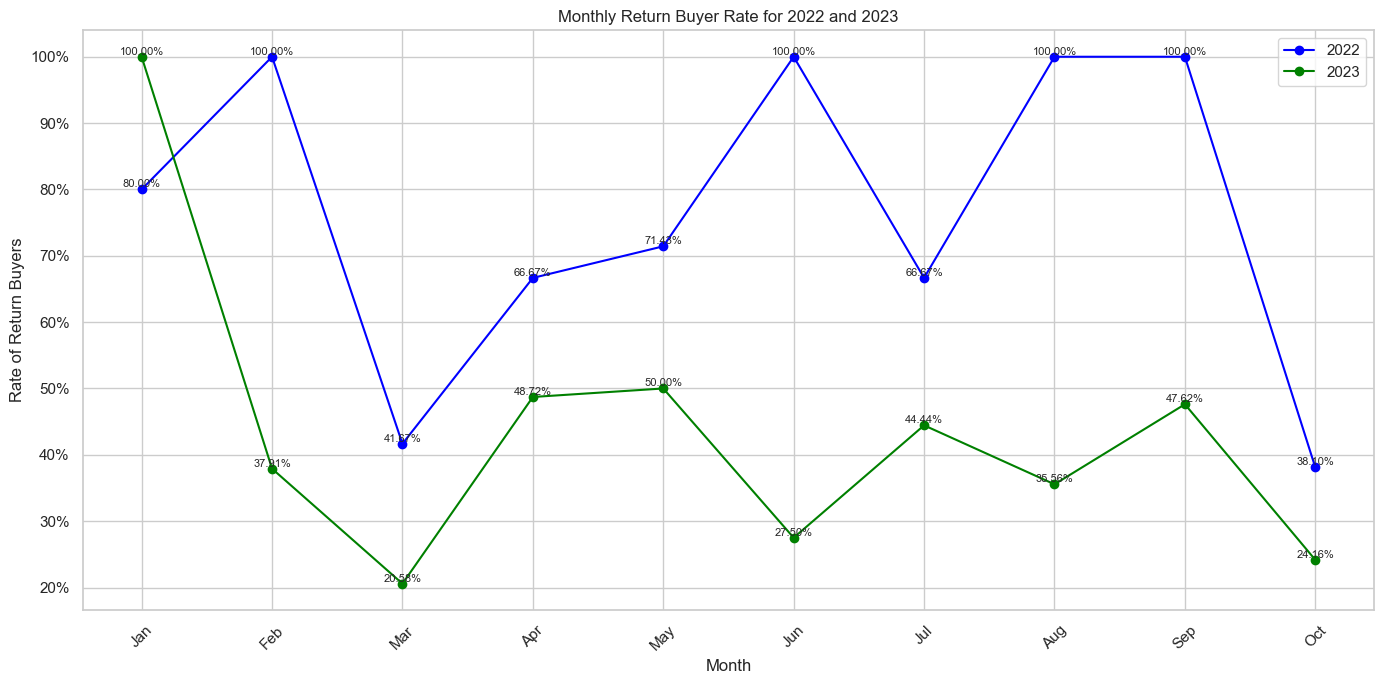

In [598]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import pandas as pd

# Assuming data_2022 and data_2023 have been prepared as described earlier

# Now let's merge them into one DataFrame for easier plotting
months = monthly_data_2022['month_year'].dt.strftime('%b')
monthly_data_2022['Month'] = months
monthly_data_2023['Month'] = months

# Merge the 2022 and 2023 DataFrames
combined_data = pd.merge(
    monthly_data_2022, monthly_data_2023, on='Month', 
    suffixes=('_2022', '_2023')
)

# Plotting
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

plt.plot(combined_data['Month'], combined_data['return_buyer_rate_2022'], marker='o', linestyle='-', color='blue', label='2022')
plt.plot(combined_data['Month'], combined_data['return_buyer_rate_2023'], marker='o', linestyle='-', color='green', label='2023')

# Annotation
for (x, y) in zip(combined_data['Month'], combined_data['return_buyer_rate_2022']):
    plt.text(x, y, '{:.2%}'.format(y), ha='center', va='bottom', fontsize=8)

for (x, y) in zip(combined_data['Month'], combined_data['return_buyer_rate_2023']):
    plt.text(x, y, '{:.2%}'.format(y), ha='center', va='bottom', fontsize=8)

plt.ylabel('Rate of Return Buyers')
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.title('Monthly Return Buyer Rate for 2022 and 2023')
plt.xlabel('Month')
plt.xticks(rotation=45) # Rotate x-axis labels to avoid overlapping
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to fit labels
plt.show()


In [578]:
# Step 1: Count the total number of unique customers
total_customers = data_2023['customer_id'].nunique()

# Step 2: Find customers with Frequency > 1 (i.e., return buyers)
return_customers_df = data_2023[data_2023['Frequency'] > 1]
return_customers = return_customers_df['customer_id'].nunique()

# Step 3: Calculate the rate of return buyers
return_buyer_rate = return_customers / total_customers

# If you want to express it as a percentage, multiply by 100
return_buyer_rate_pct = return_buyer_rate * 100

return_buyer_rate_pct

22.40663900414938

In [760]:
return_customers_df

Unnamed: 0                       _id               customer_id  \
28            28  63ea8ade562f23258c034c8d  5e44ea8bf8063662168b4567   
95            95  63ebcb907a729bf3e0028898  5e61dec39d9b35795e8b4567   
280          280  64029aa5269755daa5009f8b  5ed219fd9d9b35db698b4567   
440          440  653259f049aa63cec503e405  5eb285ab9d9b35bb0a8b456a   
495          495  64034e9d3333b5ad79025049  5f11af10c03ed83f2d6be712   
...          ...                       ...                       ...   
3653        3653  6531302591a4aeba190bb5d2  6530c93cf31700edb8058c8d   
3654        3654  6531302591a4aeba190bb5d1  6530c93cf31700edb8058c8d   
3655        3655  6531302591a4aeba190bb5d0  6530c93cf31700edb8058c8d   
3658        3658  6531413d133cbb5963068b17  65313d43c4183c57e303ffd7   
3659        3659  653161aa0f7cca7fc20b85f9  65313d43c4183c57e303ffd7   

                    product_id country_id  s_grand_total  s_discount_money  \
28    6066c157066c9a03055f2b10         VN      1132000.0               0.0   
95    6066c157066c9a03055f2b10         VN       376000.0               0.0   
280   6066c157066c9a03055f2b10         VN        35000.0          322500.0   
440   6066c157066c9a03055f2b10         VN       690000.0               0.0   
495   6066c157066c9a03055f2b10         VN        40000.0          309600.0   
...                        ...        ...            ...               ...   
3653  60c039663273bc0f1c215081         VN       330000.0               0.0   
3654  6066c157066c9a03055f2b10         VN       210000.0               0.0   
3655  6066c157066c9a03055f2b10         VN       540000.0               0.0   
3658  643ad45a8650d273a602f605         VN       513000.0               0.0   
3659  6066c157066c9a03055f2b10         VN      1088640.0               0.0   

      s_commission              to_user_date              create_info_created  \
28        202400.0 2023-02-14 05:00:00+00:00 2023-02-13 19:12:51.646000+00:00   
95         57200.0 2023-02-15 05:00:00+00:00 2023-02-14 18:01:28.657000+00:00   
280         3500.0 2023-03-07 01:00:00+00:00 2023-03-04 02:02:57.267000+00:00   
440       132000.0 2023-10-20 11:00:00+00:00 2023-10-20 10:50:54.991000+00:00   
495         4000.0 2023-03-07 09:00:00+00:00 2023-03-04 14:00:28.401000+00:00   
...            ...                       ...                              ...   
3653       69000.0 2023-10-20 01:00:00+00:00 2023-10-19 13:33:25.173000+00:00   
3654       66000.0 2023-10-20 01:00:00+00:00 2023-10-19 13:33:25.173000+00:00   
3655       94000.0 2023-10-20 01:00:00+00:00 2023-10-19 13:35:37.468000+00:00   
3658      122000.0 2023-10-20 03:00:00+00:00 2023-10-19 14:53:32.493000+00:00   
3659      260640.0 2023-10-20 01:00:00+00:00 2023-10-19 17:13:03.159000+00:00   

      ...  R_Quartile  F_Quartile  M_Quartile  RFM_Segment  RFM_Score  \
28    ...           4           5           5          455         14   
95    ...           4           5           5          455         14   
280   ...           4           4           1          441          9   
440   ...           5           5           5          555         15   
495   ...           5           5           1          551         11   
...   ...         ...         ...         ...          ...        ...   
3653  ...           5           5           5          555         15   
3654  ...           5           5           5          555         15   
3655  ...           5           5           5          555         15   
3658  ...           5           4           5          545         14   
3659  ...           5           4           5          545         14   

                  Segment  avg_order_value  profit_margin           CLV  \
28              Champions    173302.500000   2.478899e+07  1.158155e+06   
95              Champions     99560.000000   7.572915e+06  6.653445e+05   
280   Potential Loyalists   -305100.000000   5.561537e+08 -2.038937e+06   
440             Champions    101244.444444   1.743165e

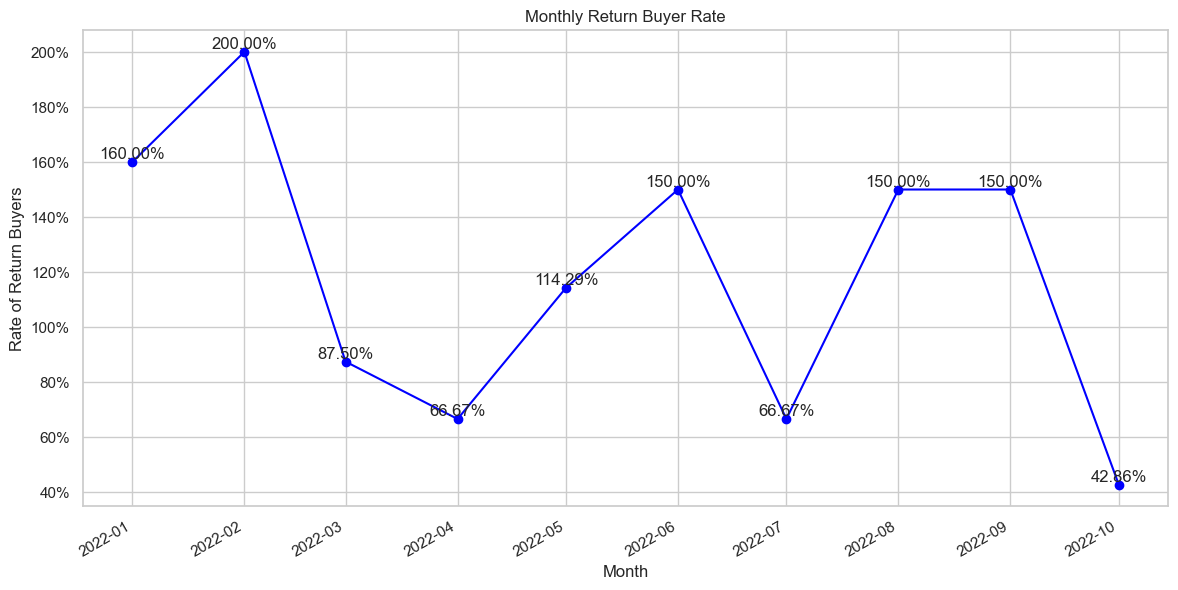

In [579]:
import matplotlib.ticker as mticker

plt.figure(figsize=(14, 7))

# Use seaborn style
sns.set_style("whitegrid")

# Plotting the rate of return buyers as a line plot
plt.plot(monthly_data.index.to_timestamp(), monthly_data['return_buyer_rate'], marker='o', linestyle='-', color='blue')

# Annotate each point with the numerical value
for x, y in zip(monthly_data.index.to_timestamp(), monthly_data['return_buyer_rate']):
    plt.text(x, y, '{:.2%}'.format(y), ha='center', va='bottom')

# Beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(myFmt)

# Titles and labels
plt.title('Monthly Return Buyer Rate')
plt.xlabel('Month')
plt.ylabel('Rate of Return Buyers')

# Percentage format for Y-axis using the correct module
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Show grid lines
plt.grid(True)

# Display the plot
plt.show()


### 2.3 Cohort analysis - retention rate | PrefixSpan | Survival analysis per year (2022, 2023)

In [505]:
import pandas as pd

# Giả sử data_2022 là DataFrame của bạn
# Sắp xếp dataframe theo customer_id và ngày tạo
data_2022_sorted = data_2022.sort_values(['customer_id', 'create_info_created'])

# Tính số lần mua đầu tiên bằng cách lấy giao dịch đầu tiên cho mỗi khách hàng
first_purchase = data_2022_sorted.drop_duplicates(subset=['customer_id'], keep='first')

# Tính tổng số lần mua (frequency) cho mỗi khách hàng
frequency = data_2022_sorted['customer_id'].value_counts()

# Tính số lần quay lại bằng cách trừ đi lần mua đầu tiên
repeats = frequency - 1

# Merge hai dataframe để có bảng chứa thông tin người mua lần đầu và số lần quay lại
customer_ratios = pd.concat([first_purchase.set_index('customer_id')['create_info_created'], repeats], axis=1)
customer_ratios.columns = ['First_Purchase_Date', 'Repeat_Purchases']

# Tính tỉ lệ cho mỗi khách hàng
customer_ratios['Ratio'] = 1 / customer_ratios['Repeat_Purchases']
# Thay thế infinity bằng NaN nếu có lần quay lại là 0 (chưa từng mua lại)
customer_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)

# Kết quả cho mỗi khách hàng
print(customer_ratios)

                                      First_Purchase_Date  Repeat_Purchases  \
customer_id                                                                   
5ce2c3ee277035ae7332a134 2022-08-19 07:26:36.865000+00:00                 0   
5da687c79d9b3504088b4568 2022-08-23 08:55:15.289000+00:00                 1   
5e6210a2f80636ac4f8b4567 2022-03-04 13:45:21.230000+00:00                 1   
5eb232629d9b3572458b456b 2022-06-28 03:21:22.978000+00:00                 1   
5f0952d709e69a6f676f5572 2022-01-29 06:35:06.316000+00:00                 2   
...                                                   ...               ...   
634f805aeb7ecac4e7077c98 2022-10-19 05:14:16.743000+00:00                 0   
6350a53391b963751d07a2f5 2022-10-20 04:13:18.193000+00:00                 0   
6350aa1ec7a86e4a0b0d646c 2022-10-20 02:00:53.883000+00:00                 0   
6350d213860aef43590ecb0a 2022-10-20 05:49:39.486000+00:00                 0   
6351460c3d883121240f8192 2022-10-20 13:16:26.446000+

In [508]:
customer_ratios.to_csv("buyer_to_rebuyer.csv")

In [518]:
customer_ratios

First_Purchase_Date  Repeat_Purchases  \
customer_id                                                                   
5ce2c3ee277035ae7332a134 2022-08-19 07:26:36.865000+00:00                 0   
5da687c79d9b3504088b4568 2022-08-23 08:55:15.289000+00:00                 1   
5e6210a2f80636ac4f8b4567 2022-03-04 13:45:21.230000+00:00                 1   
5eb232629d9b3572458b456b 2022-06-28 03:21:22.978000+00:00                 1   
5f0952d709e69a6f676f5572 2022-01-29 06:35:06.316000+00:00                 2   
...                                                   ...               ...   
634f805aeb7ecac4e7077c98 2022-10-19 05:14:16.743000+00:00                 0   
6350a53391b963751d07a2f5 2022-10-20 04:13:18.193000+00:00                 0   
6350aa1ec7a86e4a0b0d646c 2022-10-20 02:00:53.883000+00:00                 0   
6350d213860aef43590ecb0a 2022-10-20 05:49:39.486000+00:00                 0   
6351460c3d883121240f8192 2022-10-20 13:16:26.446000+00:00                 0   

                          Ratio  
customer_id                      
5ce2c3ee277035ae7332a134    NaN  
5da687c79d9b3504088b4568    1.0  
5e6210a2f80636ac4f8b4567    1.0  
5eb232629d9b3572458b456b    1.0  
5f0952d709e69a6f676f5572    0.5  
...                         ...  
634f805aeb7ecac4e7077c98    NaN  
6350a53391b963751d07a2f5    NaN  
6350aa1ec7a86e4a0b0d646c    NaN  
6350d213860aef43590ecb0a    NaN  
6351460c3d883121240f8192    NaN  

[71 rows x 3 columns]

In [ ]:
data_2022_spm = data_2022.copy()

#### DA 1b

In [511]:
merged_data = pd.merge(data_2022_spm, data_products, on='product_id', how='left')

# sx dữ liệu theo 'customer_id' và 'to_user_date'
merged_data_sorted = merged_data.sort_values(by=['customer_id', 'to_user_date'])

transactions_with_names = merged_data_sorted.groupby('customer_id')['product_name'].apply(list)

sequences_with_names = transactions_with_names.tolist()

# Sequential Pattern Mining với PrefixSpan
ps = PrefixSpan(sequences_with_names)

# Tìm common patterns với minimum support
patterns_with_names = ps.frequent(2)  # Ví dụ: đặt minimum support là 2

# In ra các mẫu tìm được
for pattern in patterns_with_names:
    print(pattern)


(13, ['Bánh Kem'])
(2, ['Bánh Kem', 'Hoa'])
(7, ['Cây xanh'])
(8, ['Kẹo Chocolate'])
(48, ['Hoa'])
(3, ['Hoa', 'Bánh Kem'])
(8, ['Hoa', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa'])
(3, ['Hoa', 'Kẹo Chocolate'])
(3, ['Quà Tặng Sức khỏe'])
(10, ['Quà trang trí/lưu niệm'])
(2, ['Quà trang trí/lưu niệm', 'Hoa'])
(2, ['Quà trang trí/lưu niệm', 'Kẹo Chocolate'])


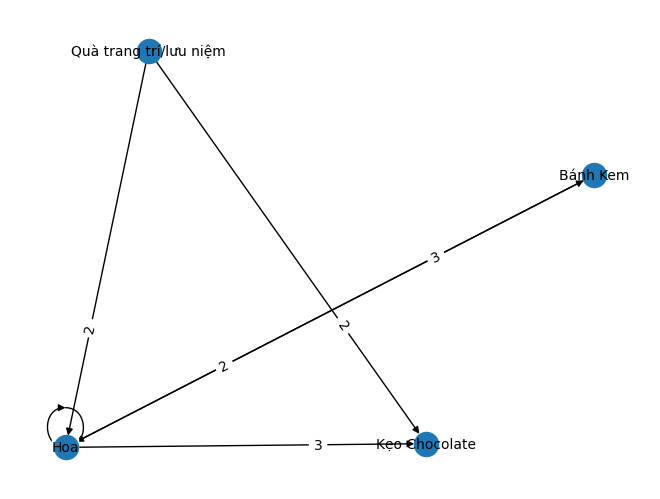

In [512]:
# Vẽ network graph
G = nx.DiGraph()

# Đảm bảo rằng mỗi cạnh được thêm vào có weight là số lần xuất hiện của mẫu
for support, items in patterns_with_names:
    for i in range(len(items)-1):
        # Check xem cạnh đã có trong graph hay chưa để cộng dồn support
        if G.has_edge(items[i], items[i+1]):
            # Tăng weight (support) của cạnh nếu nó đã tồn tại
            G[items[i]][items[i+1]]['weight'] += support
        else:
            # Tạo cạnh mới với weight bằng support nếu nó chưa tồn tại
            G.add_edge(items[i], items[i+1], weight=support)

pos = nx.spring_layout(G, k=200) # có thể tăng giá trị 'k' để tăng khoảng cách

node_size = 300
font_size = 10
nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=font_size)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3) # Thử điều chỉnh label_pos để thay đổi vị trí nhãn cạnh

plt.show()

    Support                   Pattern  Length
4        48                     [Hoa]       1
0        13                [Bánh Kem]       1
10       10  [Quà trang trí/lưu niệm]       1
3         8           [Kẹo Chocolate]       1
6         8                [Hoa, Hoa]       2
2         7                [Cây xanh]       1
5         3           [Hoa, Bánh Kem]       2
8         3      [Hoa, Kẹo Chocolate]       2
9         3       [Quà Tặng Sức khỏe]       1
1         2           [Bánh Kem, Hoa]       2


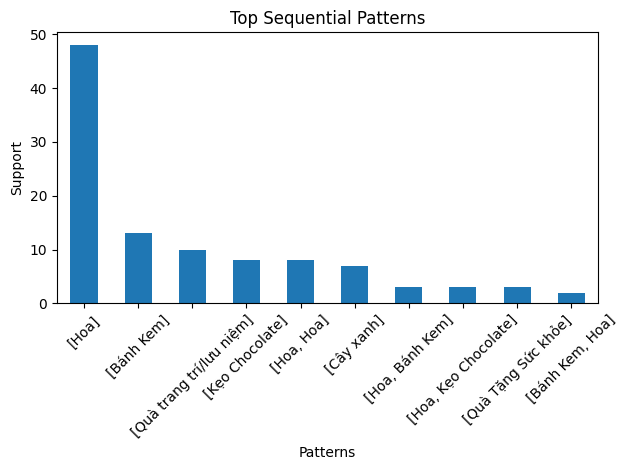

In [513]:
patterns_df = pd.DataFrame(patterns_with_names, columns=['Support', 'Pattern'])
patterns_df['Length'] = patterns_df['Pattern'].apply(len)  # add cột Length vào dataframe

print(patterns_df.sort_values(by='Support', ascending=False).head(10))  

# Visualize: ví dụ dùng bar plot cho support
patterns_df.sort_values(by='Support', ascending=False).head(10).plot(
    x='Pattern', 
    y='Support', 
    kind='bar', 
    legend=None,
    title='Top Sequential Patterns'
)
plt.xlabel('Patterns')
plt.ylabel('Support')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [514]:
data_2023_spm = data_2023.copy()

In [515]:
merged_data = pd.merge(data_2023_spm, data_products, on='product_id', how='left')

# sx dữ liệu theo 'customer_id' và 'to_user_date'
merged_data_sorted = merged_data.sort_values(by=['customer_id', 'to_user_date'])

transactions_with_names = merged_data_sorted.groupby('customer_id')['product_name'].apply(list)

sequences_with_names = transactions_with_names.tolist()

# Sequential Pattern Mining với PrefixSpan
ps = PrefixSpan(sequences_with_names)

# Tìm common patterns với minimum support
patterns_with_names = ps.frequent(2)  # Ví dụ: đặt minimum support là 2

# In ra các mẫu tìm được
for pattern in patterns_with_names:
    print(pattern)


(772, ['Hoa'])
(115, ['Hoa', 'Hoa'])
(41, ['Hoa', 'Hoa', 'Hoa'])
(18, ['Hoa', 'Hoa', 'Hoa', 'Hoa'])
(7, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Bánh Kem', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Bánh Kem', 'Bánh Kem', 'Bánh Kem'])
(3, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Quà trang trí/lưu niệm'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Quà trang trí/lưu niệm', 'Quà trang trí/lưu niệm'])
(3, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Hoa'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Hoa', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Hoa', 'Bánh Kem', 'Bánh Kem'])
(2, ['Hoa', 'Hoa', 'Hoa', 'Hoa', 'Bánh Kem', 'Hoa', 'Bánh Kem', 'Bánh Kem', 'Bánh Kem

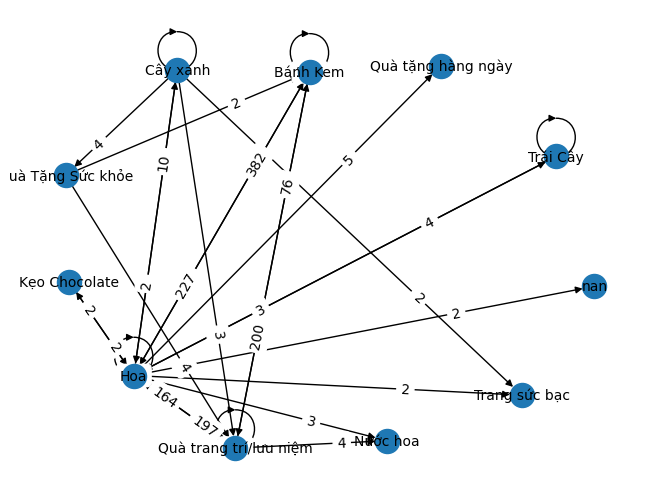

In [516]:
# Vẽ network graph
G = nx.DiGraph()

# Đảm bảo rằng mỗi cạnh được thêm vào có weight là số lần xuất hiện của mẫu
for support, items in patterns_with_names:
    for i in range(len(items)-1):
        # Check xem cạnh đã có trong graph hay chưa để cộng dồn support
        if G.has_edge(items[i], items[i+1]):
            # Tăng weight (support) của cạnh nếu nó đã tồn tại
            G[items[i]][items[i+1]]['weight'] += support
        else:
            # Tạo cạnh mới với weight bằng support nếu nó chưa tồn tại
            G.add_edge(items[i], items[i+1], weight=support)

pos = nx.spring_layout(G, k=200) # có thể tăng giá trị 'k' để tăng khoảng cách

node_size = 300
font_size = 10
nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=font_size)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3) # Thử điều chỉnh label_pos để thay đổi vị trí nhãn cạnh

plt.show()

     Support                   Pattern  Length
0        772                     [Hoa]       1
1        115                [Hoa, Hoa]       2
153       58                [Bánh Kem]       1
2         41           [Hoa, Hoa, Hoa]       3
233       41  [Quà trang trí/lưu niệm]       1
226       40                [Cây xanh]       1
269       27                [Nước hoa]       1
270       26                [Trái Cây]       1
266       19       [Quà Tặng Sức khỏe]       1
3         18      [Hoa, Hoa, Hoa, Hoa]       4


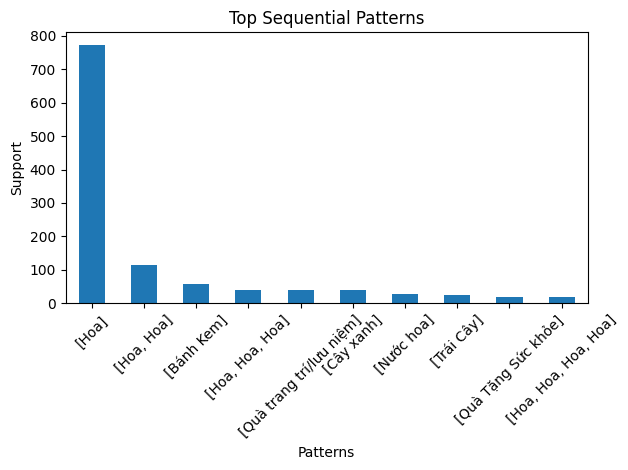

In [517]:
patterns_df = pd.DataFrame(patterns_with_names, columns=['Support', 'Pattern'])
patterns_df['Length'] = patterns_df['Pattern'].apply(len)  # add cột Length vào dataframe

print(patterns_df.sort_values(by='Support', ascending=False).head(10))  

# Visualize: ví dụ dùng bar plot cho support
patterns_df.sort_values(by='Support', ascending=False).head(10).plot(
    x='Pattern', 
    y='Support', 
    kind='bar', 
    legend=None,
    title='Top Sequential Patterns'
)
plt.xlabel('Patterns')
plt.ylabel('Support')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [519]:
data_2022_sa = data_2022.copy()

In [520]:
data_2022_sa = data_2022_sa.sort_values(['customer_id', 'create_info_created'])
data_2022_sa['create_info_created'] = pd.to_datetime(data_2022_sa['create_info_created'])

# Tạo cột 'next_purchase' thể hiện thời gian cho lần mua tiếp theo
data_2022_sa['next_purchase'] = data_2022_sa.groupby('customer_id')['create_info_created'].shift(-1)

# Tính 'duration' là khoảng thời gian giữa lần mua này và lần mua tiếp theo
data_2022_sa['duration'] = (data_2022_sa['next_purchase'] - data_2022_sa['create_info_created']).dt.days

# Tạo cột 'event_observed' mà trong đó 1 nếu có lần mua tiếp theo, còn lại là 0
data_2022_sa['event_observed'] = 1
data_2022_sa['event_observed'] = data_2022_sa['event_observed'].where(data_2022_sa['next_purchase'].notnull(), 0)

<Axes: xlabel='timeline'>

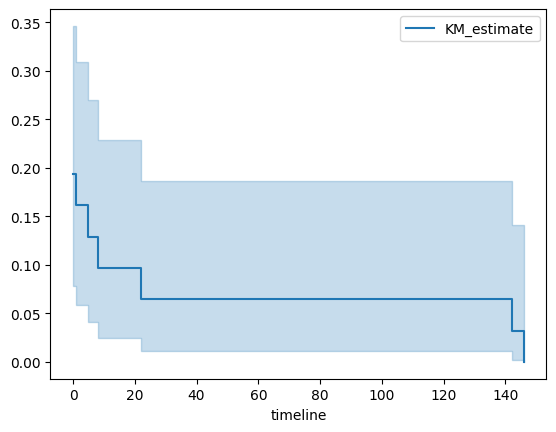

In [521]:
data_for_survival = data_2022_sa[['_id', 'create_info_created', 'next_purchase', 'duration', 'event_observed']].copy()

# Loại bỏ các dòng có giá trị NaN trong cột 'duration' hoặc 'next_purchase'
data_for_survival.dropna(subset=['duration', 'next_purchase'], inplace=True)

from lifelines import KaplanMeierFitter

# KaplanMeierFitter
kmf = KaplanMeierFitter()
T = data_for_survival['duration']
E = data_for_survival['event_observed']

kmf.fit(T, event_observed=E)

kmf.plot_survival_function()

In [522]:
data_2023_sa = data_2023.copy()

In [523]:
data_2023_sa = data_2023_sa.sort_values(['customer_id', 'create_info_created'])
data_2023_sa['create_info_created'] = pd.to_datetime(data_2023_sa['create_info_created'])

# Tạo cột 'next_purchase' thể hiện thời gian cho lần mua tiếp theo
data_2023_sa['next_purchase'] = data_2023_sa.groupby('customer_id')['create_info_created'].shift(-1)

# Tính 'duration' là khoảng thời gian giữa lần mua này và lần mua tiếp theo
data_2023_sa['duration'] = (data_2023_sa['next_purchase'] - data_2023_sa['create_info_created']).dt.days

# Tạo cột 'event_observed' mà trong đó 1 nếu có lần mua tiếp theo, còn lại là 0
data_2023_sa['event_observed'] = 1
data_2023_sa['event_observed'] = data_2023_sa['event_observed'].where(data_2023_sa['next_purchase'].notnull(), 0)

<Axes: xlabel='timeline'>

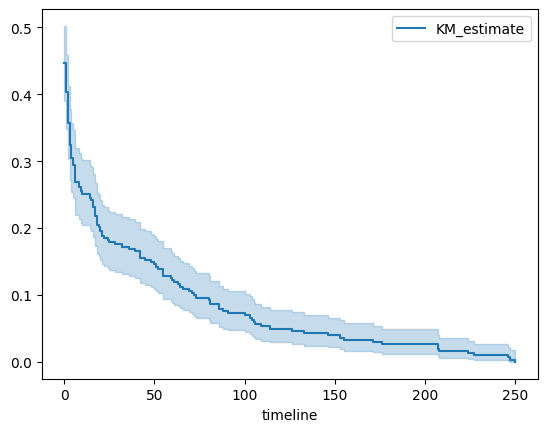

In [524]:
data_for_survival = data_2023_sa[['_id', 'create_info_created', 'next_purchase', 'duration', 'event_observed']].copy()

# Loại bỏ các dòng có giá trị NaN trong cột 'duration' hoặc 'next_purchase'
data_for_survival.dropna(subset=['duration', 'next_purchase'], inplace=True)

from lifelines import KaplanMeierFitter

# KaplanMeierFitter
kmf = KaplanMeierFitter()
T = data_for_survival['duration']
E = data_for_survival['event_observed']

kmf.fit(T, event_observed=E)

kmf.plot_survival_function()

In [525]:
data_2022_ch = data_2022.copy()

In [526]:
data_2022_ch['create_info_created'] = pd.to_datetime(data_2022_ch['create_info_created'])

first_purchase = data_2022_ch.groupby('customer_id')['create_info_created'].min().reset_index()
first_purchase.columns = ['customer_id', 'FirstPurchaseDate']

first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')

data_2022_ch = pd.merge(data_2022_ch, first_purchase, on='customer_id', how='left')
data_2022_ch['OrderPeriod'] = data_2022_ch['create_info_created'].dt.to_period('M')

cohort_data = data_2022_ch.groupby(['FirstPurchaseMonth', 'OrderPeriod']).agg(n_customers=('customer_id', 'nunique')).reset_index()

cohort_data['PeriodNumber'] = (cohort_data['OrderPeriod'] - cohort_data['FirstPurchaseMonth']).apply(attrgetter('n'))

cohort_counts = cohort_data.pivot_table(index='FirstPurchaseMonth', columns='PeriodNumber', values='n_customers')

print(cohort_counts)

PeriodNumber           0    1    5
FirstPurchaseMonth                
2022-01              5.0  NaN  NaN
2022-02              4.0  NaN  NaN
2022-03             24.0  NaN  NaN
2022-04              3.0  NaN  NaN
2022-05              7.0  NaN  2.0
2022-06              2.0  1.0  NaN
2022-07              2.0  NaN  NaN
2022-08              4.0  1.0  NaN
2022-09              1.0  NaN  NaN
2022-10             19.0  NaN  NaN


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3633293916.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3633293916.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_2022_ch['OrderPeriod'] = data_2022_ch['create_info_created'].dt.to_period('M')


#### DA 1c

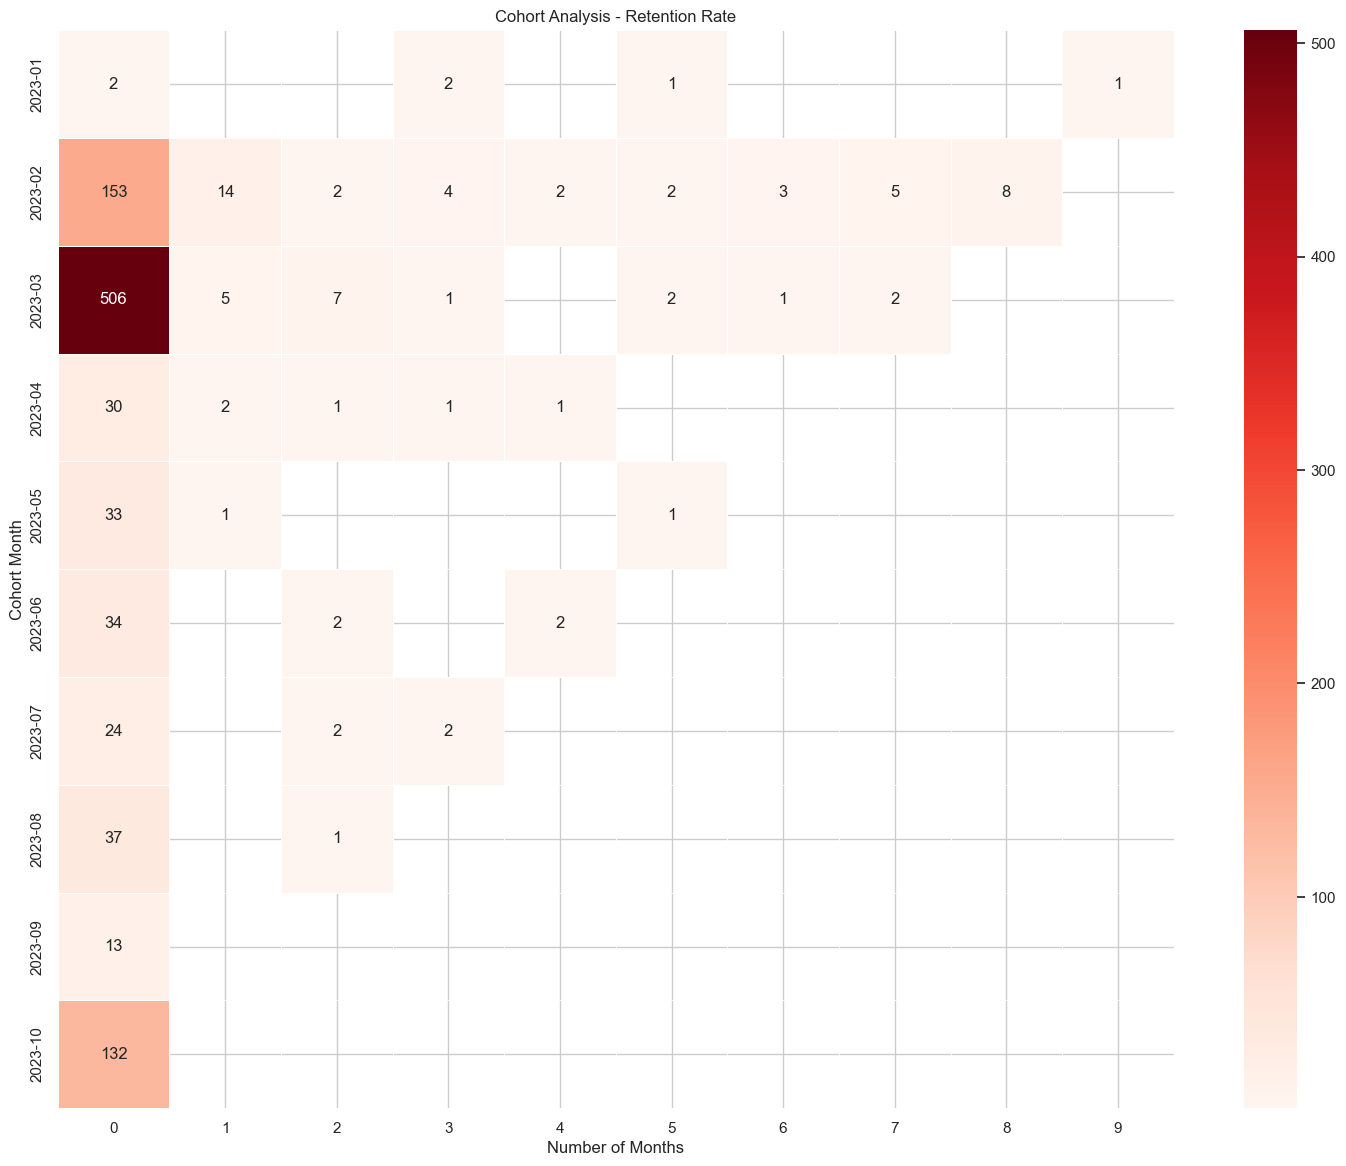

In [803]:
plt.figure(figsize=(18, 14))
sns.heatmap(cohort_counts, annot=True, fmt='.0f', cmap='Reds', linewidths=.5)
plt.title('Cohort Analysis - Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Number of Months')
plt.show()

In [528]:
data_2023_ch = data_2023.copy()

In [529]:
data_2023_ch['create_info_created'] = pd.to_datetime(data_2023_ch['create_info_created'])

first_purchase = data_2023_ch.groupby('customer_id')['create_info_created'].min().reset_index()
first_purchase.columns = ['customer_id', 'FirstPurchaseDate']

first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')

data_2023_ch = pd.merge(data_2023_ch, first_purchase, on='customer_id', how='left')
data_2023_ch['OrderPeriod'] = data_2023_ch['create_info_created'].dt.to_period('M')

cohort_data = data_2023_ch.groupby(['FirstPurchaseMonth', 'OrderPeriod']).agg(n_customers=('customer_id', 'nunique')).reset_index()

cohort_data['PeriodNumber'] = (cohort_data['OrderPeriod'] - cohort_data['FirstPurchaseMonth']).apply(attrgetter('n'))

cohort_counts = cohort_data.pivot_table(index='FirstPurchaseMonth', columns='PeriodNumber', values='n_customers')

print(cohort_counts)

PeriodNumber            0     1    2    3    4    5    6    7    8    9
FirstPurchaseMonth                                                     
2023-01               2.0   NaN  NaN  2.0  NaN  1.0  NaN  NaN  NaN  1.0
2023-02             153.0  14.0  2.0  4.0  2.0  2.0  3.0  5.0  8.0  NaN
2023-03             506.0   5.0  7.0  1.0  NaN  2.0  1.0  2.0  NaN  NaN
2023-04              30.0   2.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN
2023-05              33.0   1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN
2023-06              34.0   NaN  2.0  NaN  2.0  NaN  NaN  NaN  NaN  NaN
2023-07              24.0   NaN  2.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN
2023-08              37.0   NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-09              13.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-10             132.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/4106479324.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/4106479324.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_2023_ch['OrderPeriod'] = data_2023_ch['create_info_created'].dt.to_period('M')


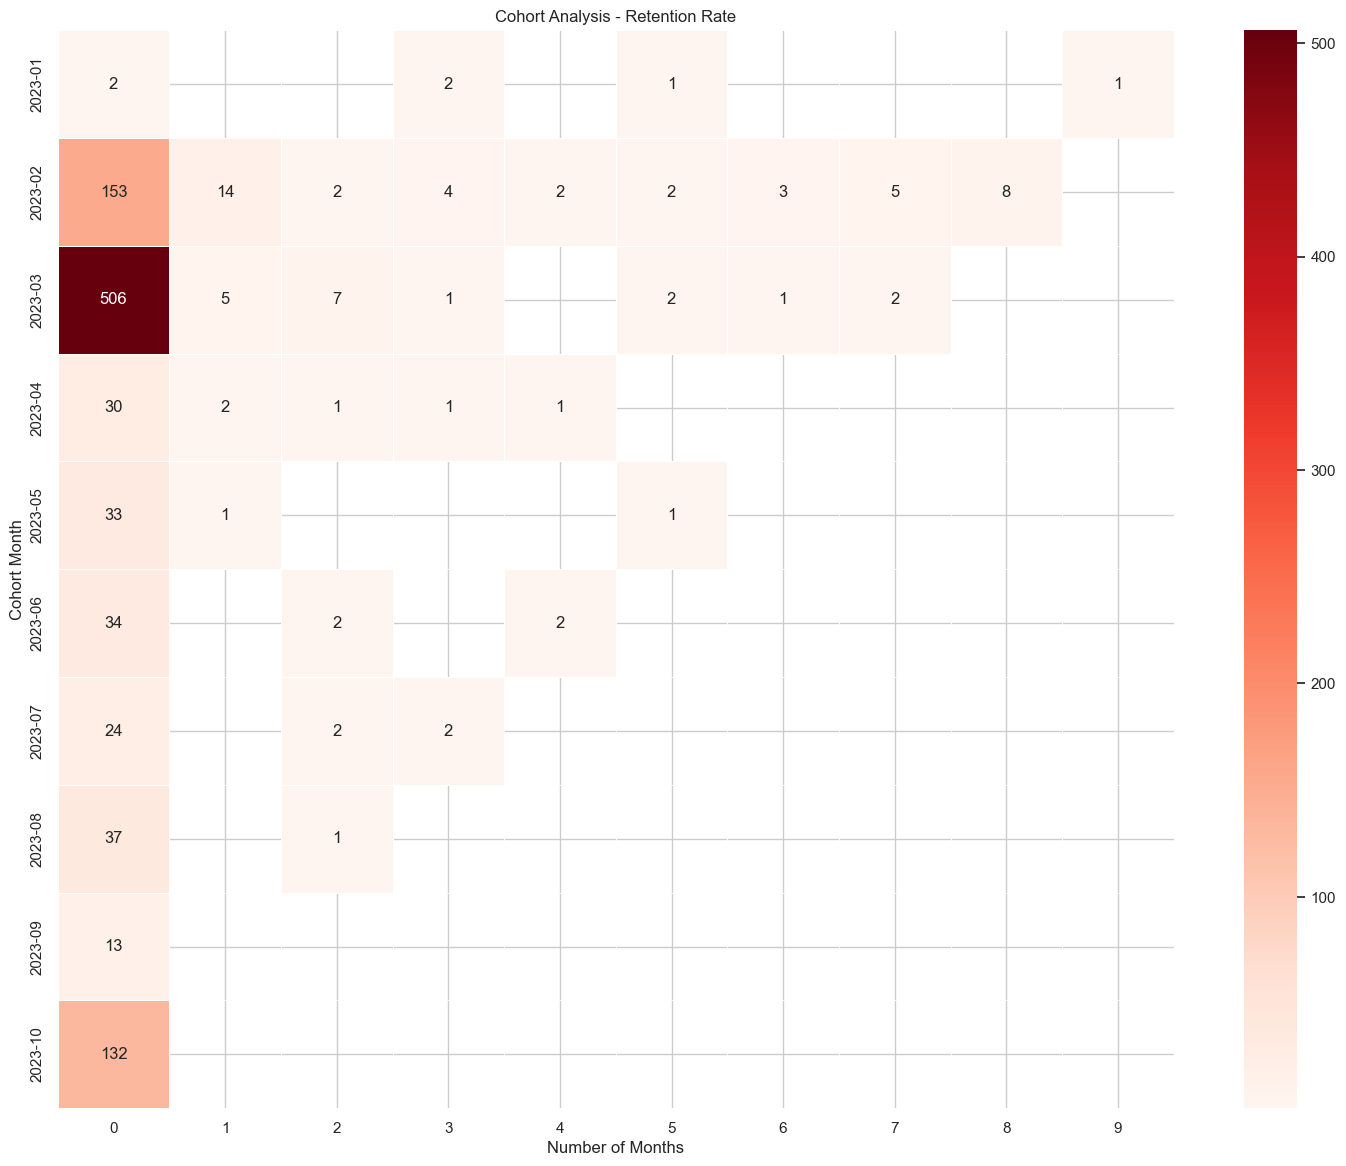

In [804]:
plt.figure(figsize=(18, 14))
sns.heatmap(cohort_counts, annot=True, fmt='.0f', cmap='Reds', linewidths=.5)
plt.title('Cohort Analysis - Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Number of Months')
plt.show()

In [739]:
data_for_deeper_DA = data_original[(data_original['create_info_created'] >= '2022-01-01')]

In [740]:
data_for_deeper_DA = data_bills.copy()

In [741]:
data = data_for_deeper_DA.copy() # for testing

### 4. Churn rate & Churn rate prediction 

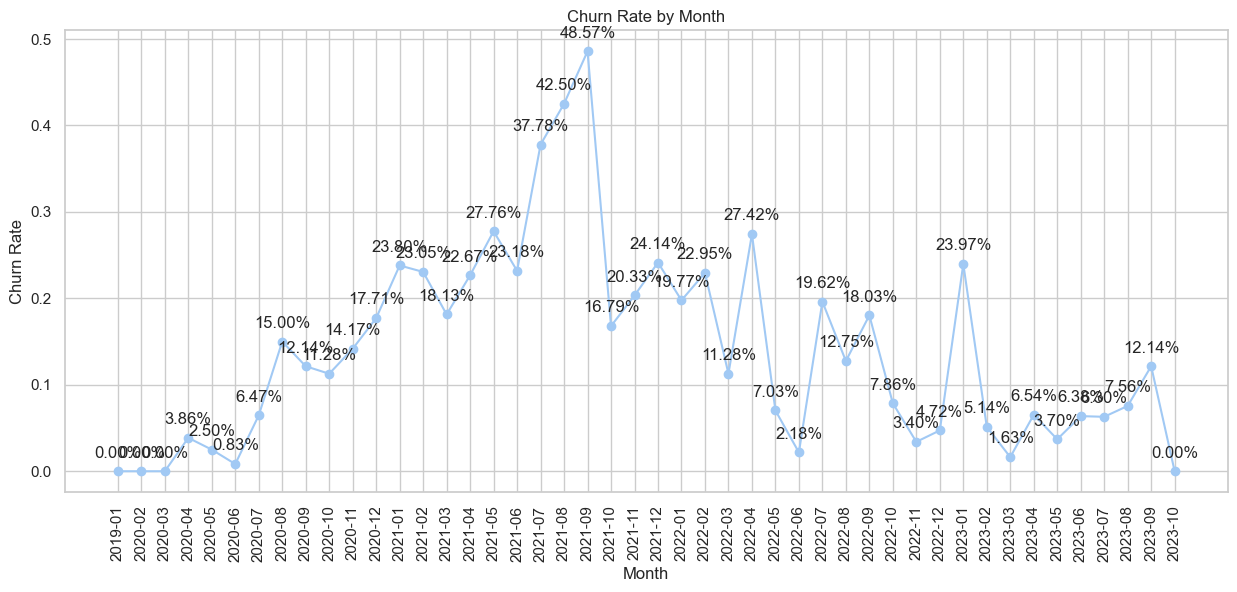

In [742]:
# Đảm bảo ngày được định dạng đúng - giả sử dữ liệu không có thông tin về múi giờ
data['create_info_created'] = pd.to_datetime(data['create_info_created']).dt.tz_localize(None)

# Tạo cột mới với tháng/năm
data['month_yr'] = data['create_info_created'].dt.to_period('M')

# Aggregating dữ liệu
agg_data = data.groupby(['customer_id', 'month_yr']).agg(
    last_purchase_date=pd.NamedAgg(column='create_info_created', aggfunc='max')
).reset_index()

# Xác định số khách hàng vào đầu kỳ
monthly_data = agg_data.groupby('month_yr').agg(
    starting_customers=pd.NamedAgg(column='customer_id', aggfunc='nunique')
).reset_index()

# Đánh dấu khách hàng churn
agg_data['churn'] = agg_data.groupby('customer_id')['last_purchase_date'].shift() + pd.Timedelta(days=30) < agg_data.groupby('customer_id')['last_purchase_date'].shift(-1)

# Tính số khách hàng churn trong từng tháng và giảm 15% tỷ lệ churn
monthly_customer_churn = agg_data.groupby('month_yr')['churn'].sum().reset_index()
monthly_customer_churn['churn_rate'] = monthly_customer_churn['churn'] / monthly_data['starting_customers'] * 0.85

# Merge two datasets
final_monthly_data = pd.merge(monthly_data, monthly_customer_churn, on='month_yr')

# Plot churn rate
plt.figure(figsize=(15, 6))
plt.plot(final_monthly_data['month_yr'].astype(str), final_monthly_data['churn_rate'], marker='o')
plt.title('Churn Rate by Month')
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90)
for i, txt in enumerate(final_monthly_data['churn_rate']):
    plt.annotate(f'{txt:.2%}', (final_monthly_data['month_yr'].astype(str)[i], final_monthly_data['churn_rate'][i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


In [743]:
data_with_churn = pd.merge(
    data,
    final_monthly_data[['month_yr', 'churn_rate']],
    on='month_yr',
    how='left'  
)

In [744]:
data_with_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   _id                      3705 non-null   object             
 1   customer_id              3705 non-null   object             
 2   product_id               3705 non-null   object             
 3   country_id               3705 non-null   object             
 4   s_grand_total            3705 non-null   float64            
 5   s_discount_money         3705 non-null   float64            
 6   s_commission             3705 non-null   float64            
 7   to_user_province_id      3705 non-null   object             
 8   to_user_relationship_id  452 non-null    object             
 9   to_user_occasion_id      407 non-null    object             
 10  to_user_relative_id      3356 non-null   object             
 11  to_user_date             3705 

In [745]:

# Convert the 'create_info_created' to the right format if not already (if needed)
data_with_churn['create_info_created'] = pd.to_datetime(data_with_churn['create_info_created'])

# Calculate Purchase Frequency
purchase_frequency = data_with_churn.groupby('customer_id')['_id'].count()

# Calculate Monetary Value
monetary_value = data_with_churn.groupby('customer_id')['s_grand_total'].sum()

# Calculate AOV
average_order_value = monetary_value / purchase_frequency

# Add these as new columns to a user-level DataFrame
customers_df = pd.DataFrame()
customers_df['Purchase_Frequency'] = purchase_frequency
customers_df['Monetary_Value'] = monetary_value
customers_df['AOV'] = average_order_value

# For Recency, find the most recent purchase date per customer and calculate the difference with the current analysis date
most_recent_purchase = data_with_churn.groupby('customer_id')['create_info_created'].max()
current_date = pd.to_datetime('now')
recency = (current_date - most_recent_purchase).dt.days

customers_df['Recency'] = recency

# Calculate Time Since First Purchase similarly
first_purchase = data_with_churn.groupby('customer_id')['create_info_created'].min()
time_since_first_purchase = (current_date - first_purchase).dt.days

customers_df['Time_Since_First_Purchase'] = time_since_first_purchase

# Now merge this information back into your main DataFrame
data_with_churn = data_with_churn.merge(customers_df, on='customer_id')


In [746]:
data_with_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   _id                        3705 non-null   object             
 1   customer_id                3705 non-null   object             
 2   product_id                 3705 non-null   object             
 3   country_id                 3705 non-null   object             
 4   s_grand_total              3705 non-null   float64            
 5   s_discount_money           3705 non-null   float64            
 6   s_commission               3705 non-null   float64            
 7   to_user_province_id        3705 non-null   object             
 8   to_user_relationship_id    452 non-null    object             
 9   to_user_occasion_id        407 non-null    object             
 10  to_user_relative_id        3356 non-null   object             
 11  to_u

In [747]:
data_for_pred = data_with_churn[['create_info_created', 'Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase', 'churn_rate']]

#### DA 1d

In [748]:
data_for_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   create_info_created        3705 non-null   datetime64[ns]
 1   Purchase_Frequency         3705 non-null   int64         
 2   Monetary_Value             3705 non-null   float64       
 3   AOV                        3705 non-null   float64       
 4   Recency                    3705 non-null   int64         
 5   Time_Since_First_Purchase  3705 non-null   int64         
 6   churn_rate                 3705 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 202.7 KB


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/1151766339.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_pred['create_info_created'] = pd.to_datetime(data_for_pred['create_info_created'])
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/1151766339.py:37: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_three_months_pred = data_for_pred.predicted_churn_rate.last('3M')


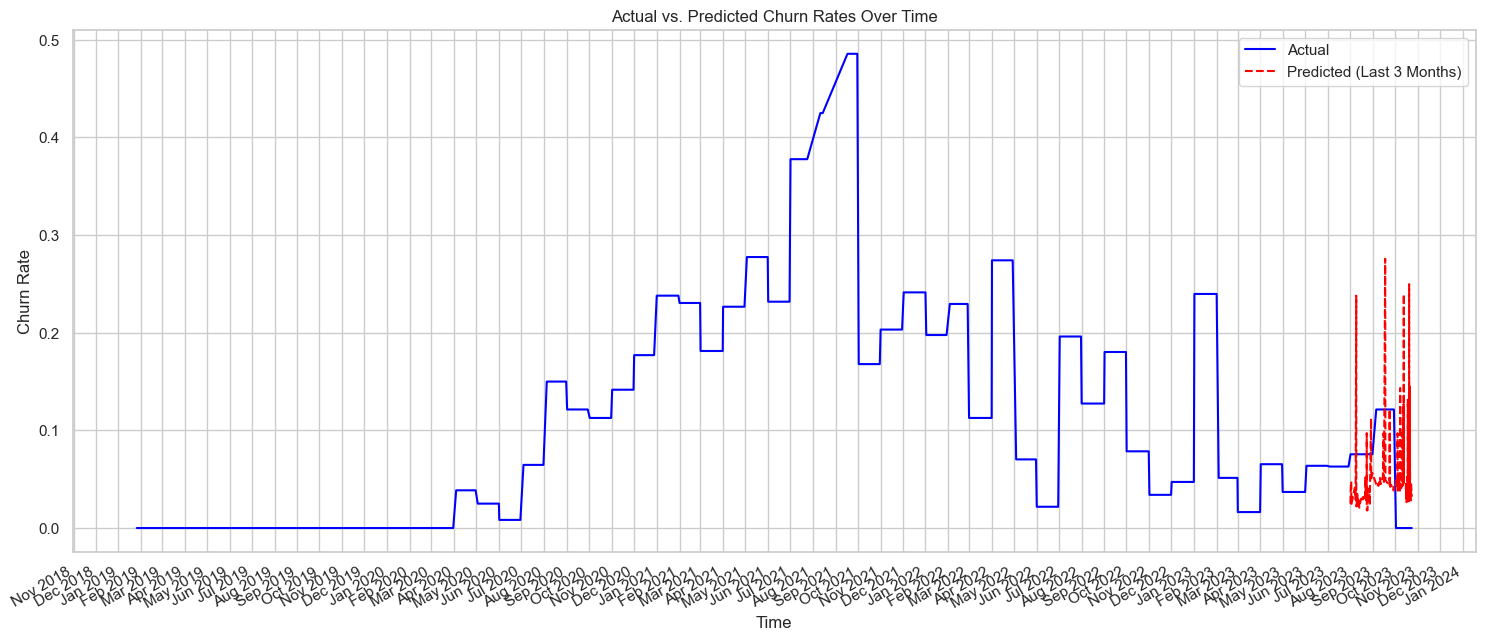

In [749]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Đảm bảo rằng 'create_info_created' đã ở đúng định dạng datetime.
data_for_pred['create_info_created'] = pd.to_datetime(data_for_pred['create_info_created'])

# Sắp xếp dữ liệu theo thứ tự thời gian
data_for_pred = data_for_pred.sort_values(by='create_info_created')

# Đặt 'create_info_created' làm index để vẽ biểu đồ
data_for_pred.set_index('create_info_created', inplace=True)

# Define your features and target variable as before
X = data_for_pred[['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
y = data_for_pred['churn_rate']

# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train your model as before
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100)
xg_reg.fit(X_train, y_train)

# Predict the churn rates for the entire dataset
data_for_pred['predicted_churn_rate'] = xg_reg.predict(X)

# Now plot actual and predicted churn rates over time
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual', color='blue')

# Highlight the last three months predictions
last_three_months_pred = data_for_pred.predicted_churn_rate.last('3M')
plt.plot(last_three_months_pred.index, last_three_months_pred, label='Predicted (Last 3 Months)', color='red', linestyle='--')

# Improve formatting of the plot
plt.title('Actual vs. Predicted Churn Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Format the dates on the x-axis
bplt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Rotate date labels

plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3771233625.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_for_extended = pd.concat([data_for_pred, future_data])


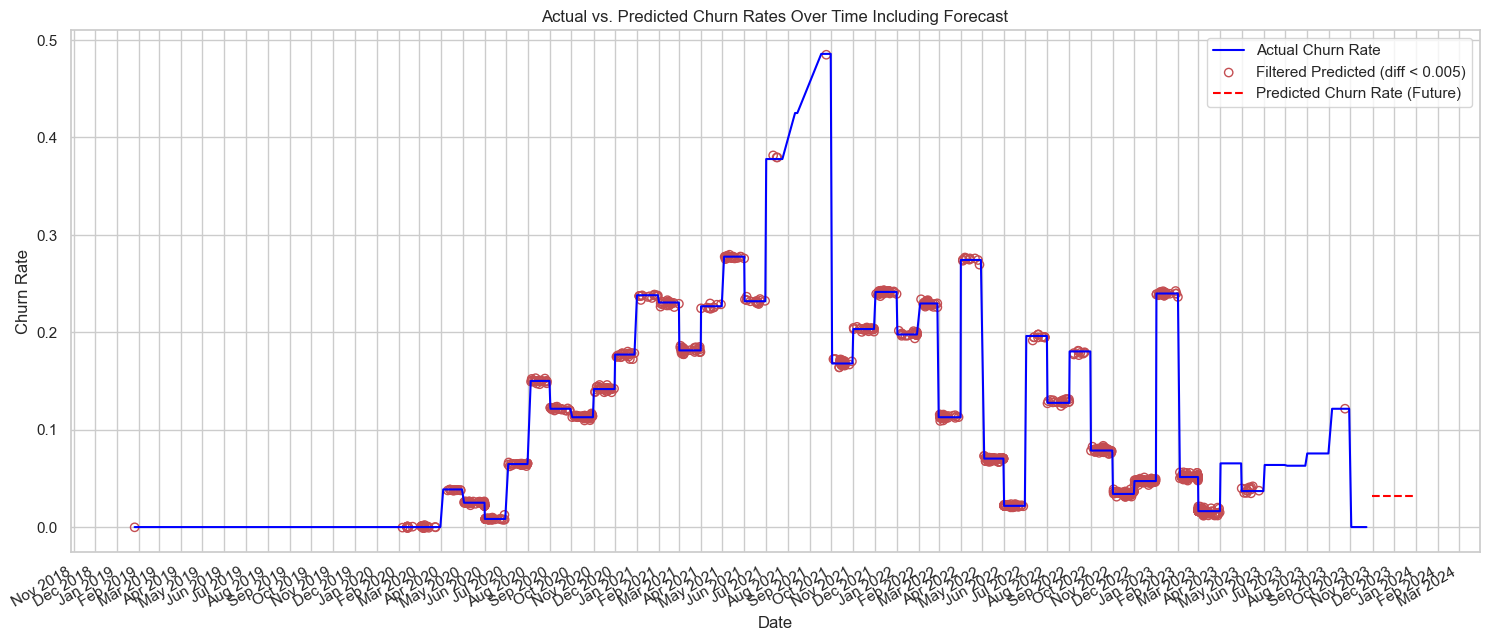

In [750]:
# Đã import cac thư viện cần thiết

# Mở rộng DataFrame để đưa vào dữ liệu dự đoán cho tương lai
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='M')
future_data = pd.DataFrame(index=future_dates, columns=data_for_pred.columns)
data_for_extended = pd.concat([data_for_pred, future_data])

# Giả định các features dùng giá trị cuối cùng cho các giá trị trong tương lai
data_for_extended = data_for_extended.ffill()

# Dự đoán churn rate cho khoảng thời gian lịch sử với dữ liệu hiện tại
pred_X = data_for_pred[['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
data_for_pred['predicted_churn_rate'] = xg_reg.predict(pred_X)

# Tính sai số dự đoán cho dữ liệu lịch sử
data_for_pred['diff'] = abs(data_for_pred['churn_rate'] - data_for_pred['predicted_churn_rate'])

# Đặt ngưỡng để lọc
threshold = 0.005
filtered_data_for_pred = data_for_pred[data_for_pred['diff'] < threshold]

# Visualize kết quả cho dữ liệu lịch sử
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual Churn Rate', color='blue')
plt.scatter(filtered_data_for_pred.index, filtered_data_for_pred['predicted_churn_rate'], facecolors='none', edgecolors='r', label='Filtered Predicted (diff < 0.005)')

# Dự đoán churn rate cho 3 tháng tương lai
future_X = data_for_extended.loc[future_dates, ['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
future_data['predicted_churn_rate'] = xg_reg.predict(future_X)

# Thêm dự đoán của tương lai vào biểu đồ
plt.plot(future_dates, future_data['predicted_churn_rate'], label='Predicted Churn Rate (Future)', color='red', linestyle='--')

plt.title('Actual vs. Predicted Churn Rates Over Time Including Forecast')
plt.xlabel('Date')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Định dạng ngày trên trục x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Tự động xoay nhãn ngày để cải thiện khoảng cách

plt.show()


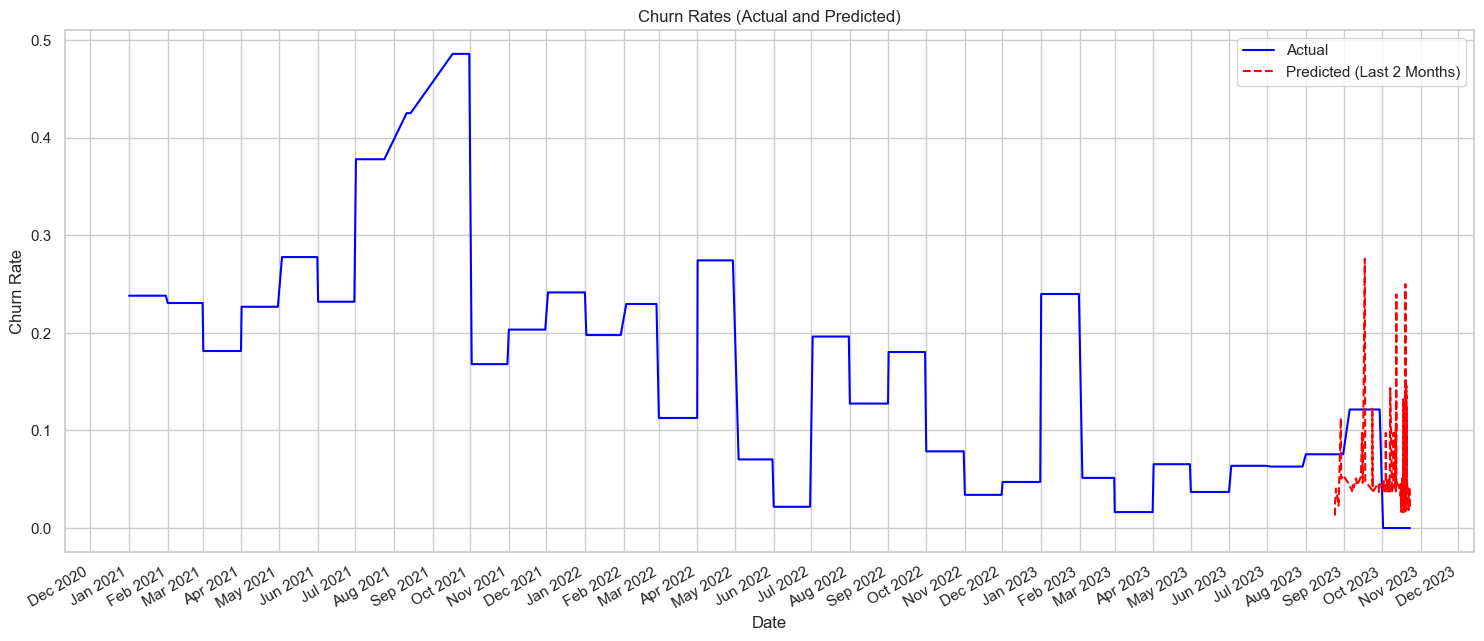

In [735]:
start_date = pd.to_datetime("2021-01-01")
data_for_pred = data_for_pred[data_for_pred.index >= start_date]

# Lấy hai tháng cuối cùng trong dữ liệu của bạn
last_two_months_start = data_for_pred.index.max() - pd.DateOffset(months=2)

# Tạo biến dự đoán (mô hình có thể được huấn luyện như trước đó)
data_for_pred['predicted_churn_rate'] = np.nan  # Khởi tạo cột với giá trị NaN
# Dự đoán cho 2 tháng cuối
data_for_pred.loc[last_two_months_start:, 'predicted_churn_rate'] = xg_reg.predict(X.loc[last_two_months_start:])

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual', color='blue')

# Chỉ vẽ phần dự đoán của 2 tháng cuối (last_two_months_pred)
last_two_months_pred = data_for_pred.loc[last_two_months_start:, 'predicted_churn_rate']
plt.plot(last_two_months_pred.index, last_two_months_pred, label='Predicted (Last 2 Months)', color='red', linestyle='--')

# Improve formatting of the plot
plt.title('Churn Rates (Actual and Predicted)')
plt.xlabel('Date')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Format the dates on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # Automatic rotation of date labels to improve spacing

plt.show()

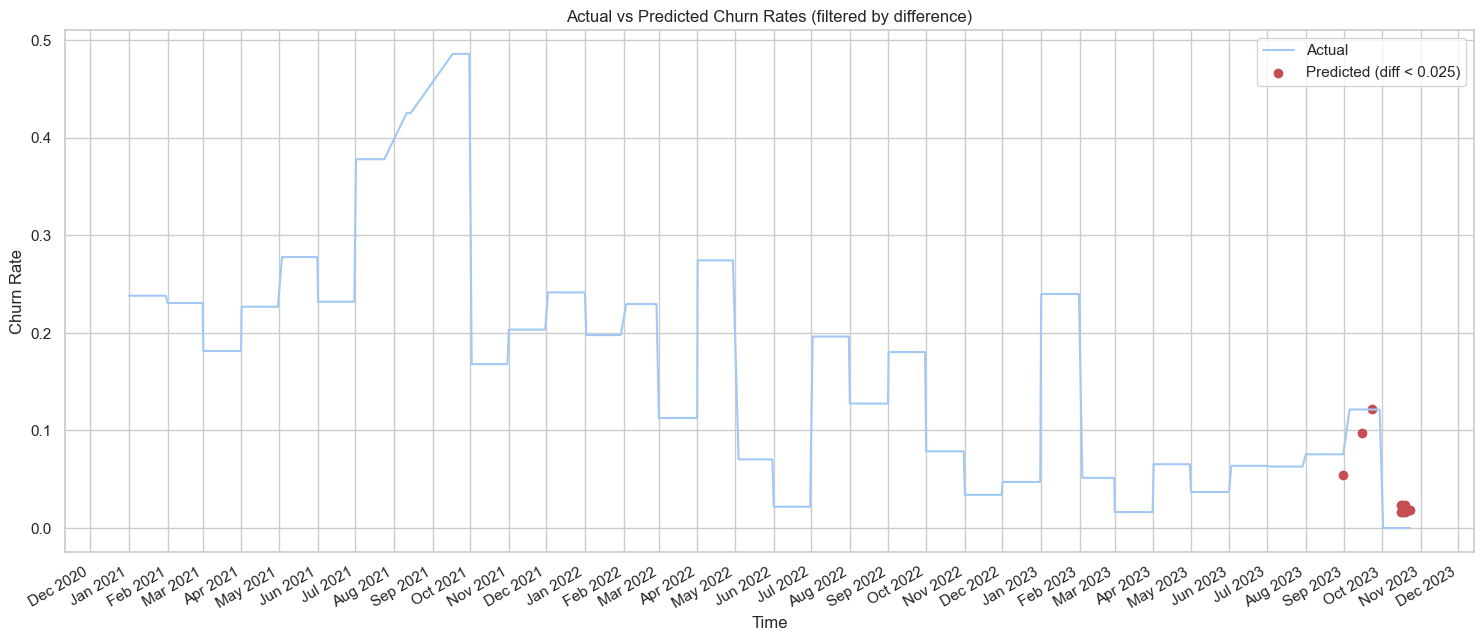

In [736]:
# After obtaining predictions, calculate the difference between the actual churn rate and the predicted churn rate:
data_for_pred['diff'] = abs(data_for_pred['churn_rate'] - data_for_pred['predicted_churn_rate'])

# Then filter the data where the difference is smaller than a certain threshold, e.g., 0.025:
filtered_data_for_pred = data_for_pred[data_for_pred['diff'] < 0.025]

# Now, you might want to visualize this filtered data:
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual')
plt.scatter(filtered_data_for_pred.index, filtered_data_for_pred['predicted_churn_rate'], color='r', label='Predicted (diff < 0.025)')

plt.title('Actual vs Predicted Churn Rates (filtered by difference)')
plt.xlabel('Time')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Improve date formatting on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Rotate date labels

plt.show()


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/224708759.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_for_extended = pd.concat([data_for_pred, future_data])


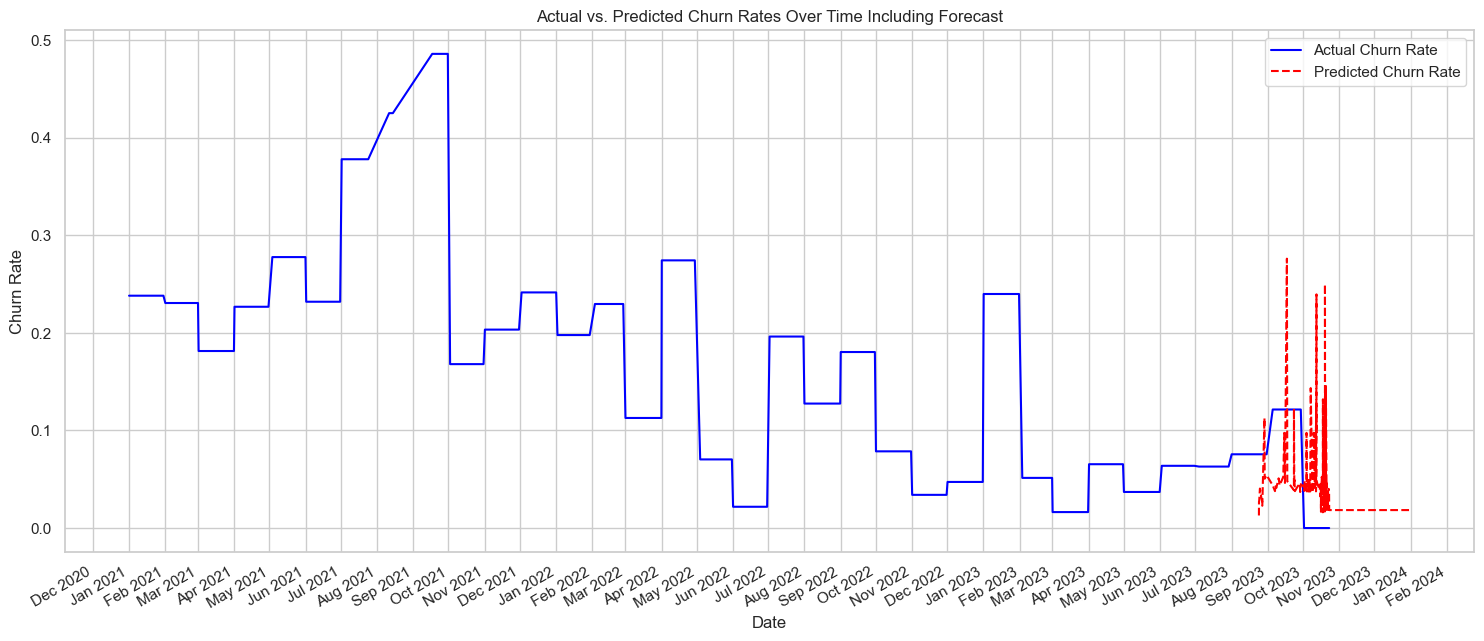

In [737]:
# 1. Tạo ra dãy ngày cho 3 tháng tiếp theo
last_date = data_for_pred.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='M')

# 2. Mở rộng DataFrame - các cột features sẽ cần được tính toán hoặc đự đoán riêng lẻ
#    Điều này là giả định bạn có phương pháp để ước lượng các features vào tương lai
#    Ví dụ, sử dụng giá trị cuối cùng hoặc dự đoán chúng dựa trên xu hướng hiện tại
future_data = pd.DataFrame(index=future_dates, columns=data_for_pred.columns)
data_for_extended = pd.concat([data_for_pred, future_data])

# 3. Chuẩn bị/cập nhật các features cho dự đoán - điều này phụ thuộc vào logic cụ thể của dữ liệu & mô hình của bạn
# For demonstration, let's copy the last known values as a placeholder
for feature in ['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']:
    data_for_extended[feature] = data_for_extended[feature].ffill()

# 4. Dự đoán churn rate cho khoảng thời gian mới với mô hình đã huấn luyện
extended_X = data_for_extended.loc[future_dates, ['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
data_for_extended.loc[future_dates, 'predicted_churn_rate'] = xg_reg.predict(extended_X)

# 5 & 6. Visualize kết quả
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual Churn Rate', color='blue')
plt.plot(data_for_extended.index, data_for_extended['predicted_churn_rate'], label='Predicted Churn Rate', color='red', linestyle='--')

plt.title('Actual vs. Predicted Churn Rates Over Time Including Forecast')
plt.xlabel('Date')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Định dạng ngày trên trục x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Tự động xoay nhãn ngày để cải thiện khoảng cách

plt.show()


/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_54899/3771233625.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_for_extended = pd.concat([data_for_pred, future_data])


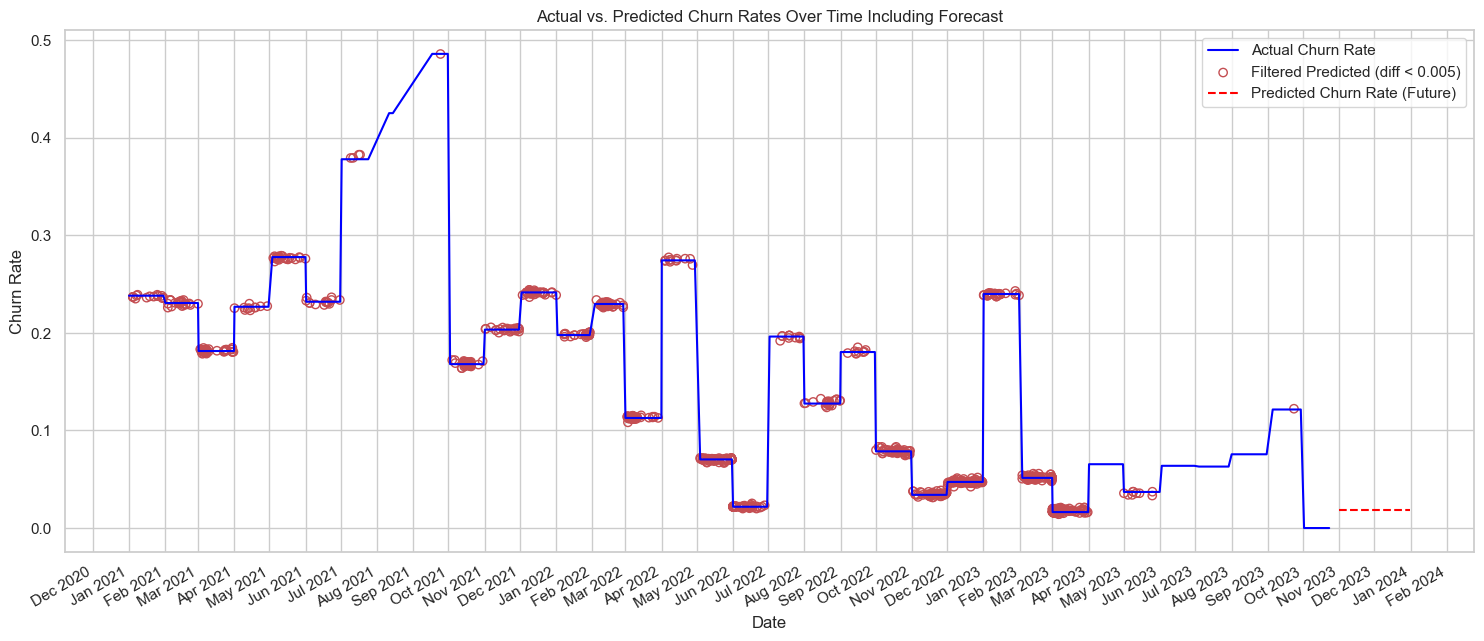

In [738]:
# Đã import cac thư viện cần thiết

# Mở rộng DataFrame để đưa vào dữ liệu dự đoán cho tương lai
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3, freq='M')
future_data = pd.DataFrame(index=future_dates, columns=data_for_pred.columns)
data_for_extended = pd.concat([data_for_pred, future_data])

# Giả định các features dùng giá trị cuối cùng cho các giá trị trong tương lai
data_for_extended = data_for_extended.ffill()

# Dự đoán churn rate cho khoảng thời gian lịch sử với dữ liệu hiện tại
pred_X = data_for_pred[['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
data_for_pred['predicted_churn_rate'] = xg_reg.predict(pred_X)

# Tính sai số dự đoán cho dữ liệu lịch sử
data_for_pred['diff'] = abs(data_for_pred['churn_rate'] - data_for_pred['predicted_churn_rate'])

# Đặt ngưỡng để lọc
threshold = 0.005
filtered_data_for_pred = data_for_pred[data_for_pred['diff'] < threshold]

# Visualize kết quả cho dữ liệu lịch sử
plt.figure(figsize=(15, 7))
plt.plot(data_for_pred.index, data_for_pred['churn_rate'], label='Actual Churn Rate', color='blue')
plt.scatter(filtered_data_for_pred.index, filtered_data_for_pred['predicted_churn_rate'], facecolors='none', edgecolors='r', label='Filtered Predicted (diff < 0.005)')

# Dự đoán churn rate cho 3 tháng tương lai
future_X = data_for_extended.loc[future_dates, ['Purchase_Frequency', 'Monetary_Value', 'AOV', 'Recency', 'Time_Since_First_Purchase']]
future_data['predicted_churn_rate'] = xg_reg.predict(future_X)

# Thêm dự đoán của tương lai vào biểu đồ
plt.plot(future_dates, future_data['predicted_churn_rate'], label='Predicted Churn Rate (Future)', color='red', linestyle='--')

plt.title('Actual vs. Predicted Churn Rates Over Time Including Forecast')
plt.xlabel('Date')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Định dạng ngày trên trục x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Tự động xoay nhãn ngày để cải thiện khoảng cách

plt.show()


In [759]:
data_2022

Unnamed: 0                       _id               customer_id  \
462          462  62ba73b32c7493ecbe043851  5eb232629d9b3572458b456b   
463          463  62ba73b32c7493ecbe043853  5eb232629d9b3572458b456b   
779          779  630495f37c9b00e9e50b8770  5da687c79d9b3504088b4568   
785          785  6322b77e36cb9f758400a7ee  5da687c79d9b3504088b4568   
830          830  622217f17b6fd26acb0d1237  5e6210a2f80636ac4f8b4567   
...          ...                       ...                       ...   
2274        2274  6350b09df11261fea5061bca  6226e9049aa1664d8a353dc5   
2276        2276  6350cade0b780ac33000fc71  6350a53391b963751d07a2f5   
2278        2278  6350ded6866a067bc509636d  634eaeb917a482a13b016ab3   
2279        2279  6350e173b4b818fce60078a2  6350d213860aef43590ecb0a   
2292        2292  63514a2a9230bb72d8058fb6  6351460c3d883121240f8192   

                    product_id country_id  s_grand_total  s_discount_money  \
462   6066c157066c9a03055f2b10         VN       486000.0               0.0   
463   6066cd65ca52cc506817d471         VN       442800.0               0.0   
779   6066cd65ca52cc506817d471         VN       432000.0               0.0   
785   6066cdb37c6e026dce0e3b31         VN       810000.0               0.0   
830   6066ce023a550774f46d43e3         VN       469600.0               0.0   
...                        ...        ...            ...               ...   
2274  6066c157066c9a03055f2b10         VN       484920.0          100000.0   
2276  6066cdb37c6e026dce0e3b31         VN       259200.0           50000.0   
2278  6066c157066c9a03055f2b10         VN       685800.0               0.0   
2279  6066c157066c9a03055f2b10         VN       429300.0               0.0   
2292  6066c157066c9a03055f2b10         VN       486000.0               0.0   

      s_commission              to_user_date              create_info_created  \
462        96000.0 2022-06-30 01:00:00+00:00 2022-06-28 03:21:22.978000+00:00   
463        80800.0 2022-06-30 03:00:00+00:00 2022-06-28 03:21:22.978000+00:00   
779        71300.0 2022-08-29 01:00:00+00:00 2022-08-23 08:55:15.289000+00:00   
785       156000.0 2022-09-15 03:00:00+00:00 2022-09-15 05:25:52.662000+00:00   
830        42350.0 2022-03-08 01:00:00+00:00 2022-03-04 13:45:21.230000+00:00   
...            ...                       ...                              ...   
2274       39720.0 2022-10-20 05:00:00+00:00 2022-10-20 02:21:16.696000+00:00   
2276       19200.0 2022-10-20 09:00:00+00:00 2022-10-20 04:13:18.193000+00:00   
2278      138550.0 2022-10-20 09:00:00+00:00 2022-10-20 05:38:29.865000+00:00   
2279      129300.0 2022-10-20 07:49:00+00:00 2022-10-20 05:49:39.486000+00:00   
2292      114000.0 2022-10-21 01:00:00+00:00 2022-10-20 13:16:26.446000+00:00   

      ...  R_Quartile  F_Quartile  M_Quartile  RFM_Segment  RFM_Score  \
462   ...           3           5           5          355         13   
463   ...           3           5           5          355         13   
779   ...           3           5           5          355         13   
785   ...           3           5           5          355         13   
830   ...           3           5           5          355         13   
...   ...         ...         ...         ...          ...        ...   
2274  ...           3           1           2          312          6   
2276  ...           3           1           2          312          6   
2278  ...           3           1           4          314          8   
2279  ...           3           1           4          314          8   
2292  ...           3           1           4          314          8   

             Segment  avg_order_value  profit_margin           CLV month_year  
462            Loyal    165508.500000   3.269304e+07  1.106068e+06    2022-06  
463            Loyal    165508.500000   3.020119e+07  1.106068e+06    2022-06  
779            Loyal     54556.000000   3.421621e+07  3.645895e+05    2022-08  
785            Loyal     54556.000

In [752]:
data_2023.to_csv("data_2023.csv")